<a href="https://colab.research.google.com/github/aghosh92/mode_coupling/blob/main/hypotheses_energy_trilinear_clear_layered.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook has been prepared by Ayana Ghosh.

## Email: research.aghosh@gmail.com


# It shows an example implementation of hypothesis-driven active learning framework to identify Landau energy expression for double perovskite oxides with A-site clear-layered ordering.

### Full dataset is available via [Zeonodo repository](https://zenodo.org/records/6570994) from [this paper](https://pubs.acs.org/doi/full/10.1021/acs.chemmater.2c00217).


Install packages

In [1]:
!pip install -q git+https://github.com/ziatdinovmax/gpax

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.0/371.0 kB 29.6 MB/s eta 0:00:00


import libraries

In [2]:
import pandas as pd
import plotly.express as px
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy import stats as st
from decimal import Decimal
import math
from typing import Union, Dict, Type
import os
import warnings

import gpax
import jax
import jaxlib
import jax.numpy as jnp
import jax.random as jra
import numpy as onp
import numpyro
from matplotlib import colorbar
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

gpax.utils.enable_x64()

In [3]:
#@title Plotting and data utilities { form-width: "20%" }

def get_training_data(X, Y, num_seed_points=2, rng_seed=42, **kwargs):
    onp.random.seed(rng_seed)
    indices = jnp.arange(len(X[:,0]))
    idx = kwargs.get("list_of_indices")
    if idx is not None:
        idx = onp.array(idx)
    else:
        idx = onp.random.randint(0, len(X[:,0]), num_seed_points)
    idx = onp.unique(idx)
    X_train, y_train = X[idx], Y[idx]
    indices_train = indices[idx]
    X_test = jnp.delete(X, (idx), 0)
    y_test = jnp.delete(Y, idx)
    indices_test = jnp.delete(indices, idx)
    return X_train, y_train, X_test, y_test, indices_train, indices_test

def plot_results_new(X_measured, y_measured, X_unmeasured, y_pred, y_sampled, obj, model_idx, rewards, **kwargs):
    X = jnp.concatenate([X_measured, X_unmeasured], axis=0).sort()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 5))
    im1 = ax1.scatter(X_measured[:,0], X_measured[:,1], marker='x', s=150, c=y_measured, label="Measured points", zorder=1, cmap='RdBu')
    cb1 = plt.colorbar(im1, ax=ax1)
    cb1.ax.tick_params(labelsize=18)
    ax1.set_xlabel("$Q{_R+}$ (Å)", fontsize=18)
    ax1.set_ylabel("$Q{_T}$ (Å)", fontsize=18)
    ax1.legend()

    im2 = ax2.scatter(X[:,1], X[:,0], s=150, c=y_pred, label='Model reconstruction', zorder=0, cmap='viridis')
    cb2 = plt.colorbar(im2, ax=ax2)
    cb2.ax.tick_params(labelsize=18)
    ax2.set_xlabel("$Q{_R+}$ (Å)", fontsize=18)
    ax2.set_ylabel("$Q{_T}$ (Å)", fontsize=18)
    ax2.legend()

    im3 = ax3.scatter(X_unmeasured[:,0], X_unmeasured[:,1], c=obj, label='Acqusition function', s=150, cmap='PRGn')
    cb3 = plt.colorbar(im3, ax=ax3)
    cb3.ax.tick_params(labelsize=18)
    ax3.set_xlabel("$Q_{R+}$ (Å)", fontsize=18)
    ax3.set_ylabel("$Q{_T}$ (Å)", fontsize=18)
    ax3.legend()

    step = kwargs.get("e", 0)
    plt.suptitle("Step: {},  Sampled Model: {}, Rewards: {}".format(
        step+1, model_idx, onp.around(rewards, 3).tolist()), fontsize=24)
    fig.savefig("./{}.png".format(step))
    plt.show()


def plot_acq(x, obj, idx):
    plt.plot(x.squeeze(), obj, c='k')
    plt.vlines(x[idx], obj.min(), obj.max(), linestyles='dashed')
    plt.xlabel("$Q{_R+}$ (Å)", fontsize=18)
    plt.ylabel("Acquisition function", fontsize=18)
    plt.show()


def plot_final_result(X, y, X_test, y_pred, y_sampled, seed_points):
    plt.figure(dpi=100)
    plt.scatter(X[seed_points:,0], X[seed_points:,1], c = y[seed_points:], s=120, alpha=0.5,
                cmap='viridis', label="Sampled points", zorder=2)
    cbar = plt.colorbar(label="Energy (eV)")
    cbar_ticks = jnp.arange(2, len(X[seed_points:,0]) + 1, 2)
    cbar.set_ticks(cbar_ticks)
    plt.scatter(X[:seed_points,0], X[:seed_points,1], c=y[:seed_points], marker='x', s=120,
                label="Seed points", cmap='PRGn',zorder=1)
    # plt.plot(X_test, y_pred, '--', c='red', label='Model reconstruction', zorder=1)
    # plt.plot(X_test, y_dft, c='k', label="Ground truth", zorder=0)
    # plt.fill_between(X_test, y_pred - y_sampled.std(0), y_pred + y_sampled.std(0),
    #                         color='r', alpha=0.2, label="Model uncertainty", zorder=0)
    plt.xlabel("$Q_{R+}$ (Å)", fontsize=18)
    plt.ylabel("$Q{_T}$ (Å)", fontsize=18)
    #plt.title("Enthalpy (Hartree/g/mol)", fontsize=12)
    plt.legend(fontsize=9, loc='upper left')
    #plt.ylim(1.8, 6.6)
    plt.show()

In [4]:
#read data
df_real = pd.read_csv("https://zenodo.org/record/6570994/files/Model_V_VI_VII.csv?download=1", on_bad_lines='skip')

In [5]:
df_real

Index Compound name A site A'site B site B'site  C_A  C_A'  Cn_A  \
0      Comp_0    BaCeMnNiO6     Ba     Ce     Mn     Ni    2     4     8   
1      Comp_1    BaDyMnNiO6     Ba     Dy     Mn     Ni    2     3     8   
2      Comp_2    BaGdMnNiO6     Ba     Gd     Mn     Ni    2     3     8   
3      Comp_3    BaHfMnNiO6     Ba     Hf     Mn     Ni    2     4     8   
4      Comp_4    BaPbMnNiO6     Ba     Pb     Mn     Ni    2     4     8   
..        ...           ...    ...    ...    ...    ...  ...   ...   ...   
96    Comp_96    SrTmMnNiO6     Sr     Tm     Mn     Ni    2     3     8   
97    Comp_97    SrZrMnNiO6     Sr     Zr     Mn     Ni    2     4     8   
98    Comp_98    TmSnMnNiO6     Tm     Sn     Mn     Ni    3     2     8   
99    Comp_99    ZnCeMnNiO6     Zn     Ce     Mn     Ni    2     4     8   
100  Comp_100    ZnSnMnNiO6     Zn     Sn     Mn     Ni    2     4     8   

     Cn_A'  ...    Energy_R  Energy_diff  Energy_diff(meV)  \
0        8  ... -143.235174    -0.777355        -777.35500   
1        8  ... -134.597100     0.096400          96.40000   
2        8  ... -135.075600     0.098900          98.90000   
3        8  ... -140.862156     0.293447         293.44689   
4        8  ... -120.046558     0.076686          76.68614   
..     ...  ...         ...          ...               ...   
96       8  ... -138.994933    -0.273602        -273.60200   
97       8  ... -139.954844     0.347826         347.82570   
98       8  ... -139.016890     0.603153         603.15300   
99       8  ... -128.237730     0.476530         476.53000   
100      8  ... -108.406319     0.105570         105.57023   

     Energy_5-atom_unitcell     Q_R+      Q_T  Q_AFE_(A)  Q_AFE_(O)  CD_(2D)  \
0               -194.338750  0.82939  0.71380   0.726945    0.80275  0.00593   
1                 24.100000  0.73213  0.90981   0.335060    0.72531  0.02463   
2                 24.725000  0.54713  0.82856   0.258255    0.68509  0.01008   
3                 73.361722  1.49716  0.87948   0.414095    1.16537  0.07588   
4                 19.171535  1.10536  1.08879   0.460660    0.82897  0.01824   
..                      ...      ...      ...        ...        ...      ...   
96               -68.400500  1.07435  1.19708   0.611605    0.55794  0.02983   
97                86.956425  1.43406  1.40721   0.726425    0.86498  0.05638   
98               150.788250  1.28589  1.93392   1.039830    0.25922  0.06775   
99               119.132500  1.28376  1.69260   1.419660    0.39736  0.05928   
100               26.392557  1.62581  1.97708   0.685580    0.46564  0.08039   

     target_label  
0               1  
1               0  
2               0  
3               0  
4               0  
..            ...  
96              1  
97              0  
98              0  
99              0  
100             0  

[101 rows x 79 columns]

In [6]:
X_R = jnp.array(df_real['Q_R+'])
X_T = jnp.array(df_real['Q_T'])

X_all = jnp.vstack((X_R, X_T)).T
y_all = jnp.array(df_real['Energy'])

In [7]:
#indices of seed points
l_train = [0, 6, 24, 42, 54]

Define possible models of system's behavior (hypothesis) as dereministic functions

In [8]:
def comb1(x, params): #x[:,0] is QR+ , x[:,1] is QT, a1, a2 are coefficients
    return (params["a1"] * x[:,0]**2) + (params["a2"] * x[:,1]**2)

def comb2(x, params): #x[:,0] is QR+ , x[:,1] is QT, a1, a2 are coefficients
    return (params["a1"] * x[:,0]**2) + (params["a2"] * x[:,1]**2) + (params["alpha"] * x[:,0]*x[:,1]*params["QAFEA"])

def comb3(x, params): #x[:,0] is QR+ , x[:,1] is QT, a1, a2, a3 are coefficients
    return (params["a1"] * x[:,0]**2) + (params["a2"] * x[:,1]**2) + (params["a3"] * params["QAFEA"]) + (params["alpha"] * x[:,0]*x[:,1]*params["QAFEA"])

def comb4(x, params): #x[:,0] is QR+ , x[:,1] is QT, a1, a2, a3 are coefficients
    return (params["a1"] * x[:,0]**2) + (params["a2"] * x[:,1]**2) + (params["a3"] * params["QAFEA"]**2)

Put priors over parameters of each model to make them probabilistic

In [9]:
def comb1_priors() -> Dict[str, jnp.ndarray]:
    a1 = numpyro.sample("a1", numpyro.distributions.Normal(-54, 1))
    a2 = numpyro.sample("a2", numpyro.distributions.Normal(-54, 1))
    return {"a1": a1, "a2": a2}

def comb2_priors() -> Dict[str, jnp.ndarray]:
    a1 = numpyro.sample("a1", numpyro.distributions.Normal(-54, 1))
    a2 = numpyro.sample("a2", numpyro.distributions.Normal(-54, 1))
    alpha = numpyro.sample("alpha", numpyro.distributions.Normal(-5, 1))
    QAFEA = numpyro.sample("QAFEA", numpyro.distributions.LogNormal(0, 0.5))
    return {"a1": a1, "a2": a2, "alpha":alpha, "QAFEA":QAFEA}

def comb3_priors() -> Dict[str, jnp.ndarray]:
    a1 = numpyro.sample("a1", numpyro.distributions.Normal(-54, 1))
    a2 = numpyro.sample("a2", numpyro.distributions.Normal(-54, 1))
    a3 = numpyro.sample("a3", numpyro.distributions.Normal(1, 0.5))
    alpha = numpyro.sample("alpha", numpyro.distributions.Normal(-15, 1))
    QAFEA = numpyro.sample("QAFEA", numpyro.distributions.LogNormal(1, 0.5))
    return {"a1": a1, "a2": a2, "a3": a3, "alpha":alpha, "QAFEA":QAFEA}

def comb4_priors() -> Dict[str, jnp.ndarray]:
    a1 = numpyro.sample("a1", numpyro.distributions.Normal(-54,1))
    a2 = numpyro.sample("a2", numpyro.distributions.Normal(-54,1))
    a3 = numpyro.sample("a3", numpyro.distributions.Normal(0, 0.5))
    QAFEA = numpyro.sample("QAFEA", numpyro.distributions.LogNormal(1, 0.5))
    return {"a1": a1, "a2": a2, "a3": a3, "QAFEA":QAFEA}

Let's also specify custom priors over GP kernel:

In [10]:
def gp_kernel_prior() -> Dict[str, jnp.ndarray]:
    length = numpyro.sample("k_length", numpyro.distributions.Uniform(0, 1))
    scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
    return {"k_length": length, "k_scale": scale}

In [11]:
# custom kernel prior for models
# custom kernel prior for model 1
def kernel_prior1() -> Dict[str, jnp.ndarray]:
    # kernel lengthscale prior for the first input dimension
    k_length1 = numpyro.sample("k_length1", numpyro.distributions.Gamma(2, 1))
    # kernel lengthscale prior for the second input dimension
    k_length2 = numpyro.sample("k_length2", numpyro.distributions.Gamma(2, 1))
    # Put them together
    k_length = numpyro.deterministic("k_length", jnp.array([k_length1, k_length2]))
    # Sample output scale
    k_scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
    return {"k_length": k_length, "k_scale": k_scale}

In [12]:
#@title Helper functions for hypothesis learning
def get_best_model(record):
    return record[:,1].argmax()

def update_record(record: onp.ndarray, action: int, r: float) -> onp.ndarray:
    new_r = (record[action, 0] * record[action, 1] + r) / (record[action, 0] + 1)
    record[action, 0] += 1
    record[action, 1] = new_r
    return record

def get_reward(obj_history, obj):
    """A reward of +/-1 is given if the integral uncertainty at the current step
    is smaller/larger than the median uncertainty at the previous step"""
    if jnp.nanmedian(obj) < obj_history[-1]:  # one can use integral uncertainty instead of median
        r = 1
    else:
        r = -1
    return r

def step(model,model_prior,kernel_prior,
         X_train, y_train, X_new,num_restarts=1):
    """Compute model posterior and use it to derive acqusition function"""
    sgr = numpyro.diagnostics.split_gelman_rubin
    for i in range(num_restarts):
        rng_key, rng_key_predict = gpax.utils.get_keys(i)
        # Get/update model posterior
        gp_model = gpax.ExactGP(
            2, 'RBF', model, kernel_prior, model_prior,
            noise_prior=lambda: numpyro.sample("noise", numpyro.distributions.LogNormal(0, 1)))
        gp_model.fit(
            rng_key, X_train, y_train, num_warmup=1000,
            num_samples=1000, num_chains=1)
        rhats = [sgr(v).max() for v in gp_model.get_samples(1).values()]
        if max(rhats) < 1.2:
            break
    # Compute acquisition function
    _, samples = gp_model.predict(rng_key, X_new)
    #_, samples = gp_model.predict_in_batches(rng_key, X_new, 50)
    obj = samples.var(0).squeeze()
    print(jnp.isnan(obj).any())
    return obj, gp_model

def update_datapoints(next_point_idx, train, test):
    """Update "measured" dummy data points"""
    X_train, y_train, indices_train = train
    X_test, y_test, indices_test = test
    X_train = jnp.append(X_train, X_test[next_point_idx][None], 0)
    X_test = jnp.delete(X_test, (next_point_idx), 0)
    y_train = jnp.append(y_train, y_test[next_point_idx])
    y_test = jnp.delete(y_test, next_point_idx)
    indices_train = jnp.append(indices_train, next_point_idx)
    indices_test = jnp.delete(indices_test, next_point_idx)
    return (X_train, y_train, indices_train), (X_test, y_test, indices_test)

warnings.filterwarnings("ignore")

Generate seed points:

In [13]:
(X_train, y_train, X_test, y_test,
     indices_train, indices_test) = get_training_data(X_all, y_all, list_of_indices=l_train)
num_seed_points = len(X_train)

Hypothesis-driven active learning:

Warmup step 1/3


sample: 100%|██████████| 2000/2000 [00:11<00:00, 176.44it/s, 7 steps of size 6.14e-01. acc. prob=0.83]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         a1    -53.82      0.98    -53.81    -55.27    -52.15    958.90      1.00
         a2    -53.72      1.04    -53.73    -55.63    -52.25   1013.60      1.00
k_length[0]      2.08      1.29      1.75      0.55      4.19    976.59      1.00
k_length[1]      0.60      0.15      0.59      0.31      0.78    815.75      1.00
  k_length1      2.08      1.29      1.75      0.55      4.19    976.59      1.00
  k_length2      0.60      0.15      0.59      0.31      0.78    815.75      1.00
    k_scale   3774.93   1149.12   3567.27   2158.57   5652.68    909.30      1.00
      noise      1.56      1.82      1.03      0.04      3.40   1105.41      1.00

False


sample: 100%|██████████| 2000/2000 [00:05<00:00, 391.96it/s, 7 steps of size 5.21e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      0.87      0.40      0.78      0.27      1.44   1203.81      1.00
         a1    -53.82      1.06    -53.84    -55.63    -52.16   2006.53      1.00
         a2    -53.72      0.97    -53.70    -55.27    -52.20   1091.01      1.00
      alpha     -4.80      0.92     -4.81     -6.31     -3.28   1332.08      1.00
k_length[0]      1.96      1.26      1.66      0.30      3.83    763.82      1.00
k_length[1]      0.63      0.27      0.60      0.34      0.84    263.56      1.01
  k_length1      1.96      1.26      1.66      0.30      3.83    763.82      1.00
  k_length2      0.63      0.27      0.60      0.34      0.84    263.56      1.01
    k_scale   4152.88   1434.22   3888.17   2170.44   6053.98   1258.35      1.00
      noise      1.65      1.94      1.06      0.06      3.75    766.63      1.00

False


sample: 100%|██████████| 2000/2000 [00:05<00:00, 377.41it/s, 7 steps of size 4.73e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.21      0.46      1.13      0.50      1.85   1262.73      1.00
         a1    -53.85      1.05    -53.87    -55.41    -52.04   1468.38      1.00
         a2    -53.79      0.97    -53.76    -55.54    -52.31   1235.69      1.00
         a3      1.02      0.47      1.03      0.17      1.71   1138.91      1.00
      alpha    -14.71      0.97    -14.74    -16.17    -13.02   2069.33      1.00
k_length[0]      1.89      1.18      1.57      0.40      3.59   1277.08      1.00
k_length[1]      0.64      0.16      0.62      0.37      0.86   1180.47      1.00
  k_length1      1.89      1.18      1.57      0.40      3.59   1277.08      1.00
  k_length2      0.64      0.16      0.62      0.37      0.86   1180.47      1.00
    k_scale   5414.86   1914.70   5046.50   2781.76   8241.24   1029.39      1.00
      noise      1.59      1.84      0.98      0.08      3.58   1092.71      1.00

False


sample: 100%|██████████| 2000/2000 [00:05<00:00, 335.88it/s, 7 steps of size 4.73e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.31      1.87      2.84      0.77      5.72    781.10      1.00
         a1    -53.82      1.04    -53.81    -55.53    -52.11   1575.91      1.00
         a2    -53.67      0.96    -53.64    -55.17    -52.08   1316.19      1.00
         a3      0.12      0.49      0.14     -0.59      1.02    950.63      1.00
k_length[0]      1.98      1.28      1.66      0.30      3.73   1160.45      1.00
k_length[1]      0.61      0.16      0.59      0.35      0.85    698.68      1.00
  k_length1      1.98      1.28      1.66      0.30      3.73   1160.45      1.00
  k_length2      0.61      0.16      0.59      0.35      0.85    698.68      1.00
    k_scale   3796.21   1358.25   3567.62   1799.85   5488.78    719.43      1.00
      noise      1.58      1.75      1.02      0.07      3.50   1102.72      1.00

False
Warmup step 2/3


sample: 100%|██████████| 2000/2000 [00:04<00:00, 478.07it/s, 7 steps of size 4.78e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         a1    -53.85      1.00    -53.85    -55.36    -52.12   1064.88      1.00
         a2    -53.72      0.99    -53.72    -55.28    -52.10   1133.60      1.00
k_length[0]      0.62      0.20      0.61      0.33      0.97    720.19      1.00
k_length[1]      0.86      0.32      0.83      0.46      1.31    519.16      1.00
  k_length1      0.62      0.20      0.61      0.33      0.97    720.19      1.00
  k_length2      0.86      0.32      0.83      0.46      1.31    519.16      1.00
    k_scale   4252.81   1544.48   3925.19   2257.94   6478.73    690.17      1.00
      noise      1.65      2.53      1.00      0.04      3.32    893.02      1.00

False


sample: 100%|██████████| 2000/2000 [00:04<00:00, 415.43it/s, 7 steps of size 5.68e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      0.87      0.39      0.79      0.29      1.46   1088.71      1.00
         a1    -53.81      1.03    -53.84    -55.41    -52.06   2266.57      1.00
         a2    -53.69      1.01    -53.70    -55.46    -52.11   1727.65      1.00
      alpha     -4.79      0.95     -4.80     -6.41     -3.27   1892.26      1.00
k_length[0]      0.61      0.19      0.60      0.30      0.93    863.97      1.00
k_length[1]      0.84      0.27      0.80      0.43      1.29    920.17      1.00
  k_length1      0.61      0.19      0.60      0.30      0.93    863.97      1.00
  k_length2      0.84      0.27      0.80      0.43      1.29    920.17      1.00
    k_scale   4445.70   1642.27   4122.65   2319.78   6556.34    854.09      1.00
      noise      1.67      2.10      1.01      0.04      3.62    822.04      1.00

False


sample: 100%|██████████| 2000/2000 [00:06<00:00, 308.38it/s, 7 steps of size 5.64e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.18      0.43      1.12      0.52      1.84   1606.80      1.00
         a1    -53.87      1.01    -53.87    -55.45    -52.16   1265.91      1.00
         a2    -53.71      0.98    -53.72    -55.12    -51.85   1647.10      1.00
         a3      1.00      0.48      1.01      0.19      1.74   1458.77      1.00
      alpha    -14.75      0.94    -14.78    -16.27    -13.21   2157.08      1.00
k_length[0]      0.64      0.19      0.62      0.34      0.94   1242.79      1.00
k_length[1]      0.86      0.27      0.84      0.39      1.24   1027.85      1.00
  k_length1      0.64      0.19      0.62      0.34      0.94   1242.79      1.00
  k_length2      0.86      0.27      0.84      0.39      1.24   1027.85      1.00
    k_scale   5895.15   2214.51   5431.91   2963.42   9202.03   1187.32      1.00
      noise      1.60      1.79      1.03      0.09      3.68    933.24      1.00

False


sample: 100%|██████████| 2000/2000 [00:04<00:00, 411.45it/s, 7 steps of size 5.67e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.18      1.67      2.75      0.79      5.49   1231.37      1.00
         a1    -53.80      1.06    -53.79    -55.60    -52.14   2012.93      1.00
         a2    -53.66      0.98    -53.64    -55.21    -52.04   1743.94      1.00
         a3      0.11      0.48      0.11     -0.64      0.94   1468.97      1.00
k_length[0]      0.61      0.19      0.59      0.28      0.91    561.12      1.00
k_length[1]      0.83      0.27      0.81      0.39      1.27    854.64      1.00
  k_length1      0.61      0.19      0.59      0.28      0.91    561.12      1.00
  k_length2      0.83      0.27      0.81      0.39      1.27    854.64      1.00
    k_scale   4059.51   1456.58   3784.13   2039.67   5909.96   1003.98      1.00
      noise      1.71      2.15      1.02      0.05      3.96    726.21      1.00

False
Warmup step 3/3


sample: 100%|██████████| 2000/2000 [00:04<00:00, 472.76it/s, 7 steps of size 5.44e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         a1    -53.86      0.98    -53.85    -55.61    -52.36   1002.64      1.00
         a2    -53.74      1.01    -53.76    -55.50    -52.15   1185.74      1.00
k_length[0]      0.66      0.18      0.64      0.38      0.94    923.12      1.00
k_length[1]      0.83      0.26      0.80      0.39      1.21    867.67      1.00
  k_length1      0.66      0.18      0.64      0.38      0.94    923.12      1.00
  k_length2      0.83      0.26      0.80      0.39      1.21    867.67      1.00
    k_scale   4610.76   1591.13   4275.72   2494.89   6880.57    861.54      1.00
      noise      1.73      2.68      1.05      0.03      3.50    956.73      1.00

False


sample: 100%|██████████| 2000/2000 [00:05<00:00, 333.65it/s, 7 steps of size 6.37e-01. acc. prob=0.87] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      0.88      0.42      0.80      0.27      1.43    823.48      1.00
         a1    -53.84      1.04    -53.85    -55.45    -52.01   1850.42      1.00
         a2    -53.73      1.00    -53.71    -55.40    -52.06   2262.19      1.00
      alpha     -4.79      0.96     -4.76     -6.42     -3.26   1642.53      1.00
k_length[0]      0.69      0.35      0.65      0.34      0.95    138.74      1.01
k_length[1]      0.81      0.28      0.78      0.42      1.29    358.48      1.00
  k_length1      0.69      0.35      0.65      0.34      0.95    138.74      1.01
  k_length2      0.81      0.28      0.78      0.42      1.29    358.48      1.00
    k_scale   4869.64   1764.34   4545.14   2449.15   7201.62    925.96      1.00
      noise      1.77      2.20      1.03      0.04      4.18    723.58      1.00

False


sample: 100%|██████████| 2000/2000 [00:05<00:00, 362.83it/s, 7 steps of size 4.90e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.22      0.46      1.15      0.53      1.89   1336.17      1.00
         a1    -53.85      1.04    -53.87    -55.40    -52.00   1748.88      1.00
         a2    -53.76      0.96    -53.75    -55.39    -52.25   1416.61      1.00
         a3      1.00      0.48      1.02      0.18      1.74   1192.68      1.00
      alpha    -14.72      0.97    -14.76    -16.44    -13.22   1787.01      1.00
k_length[0]      0.66      0.20      0.65      0.37      1.00    309.85      1.00
k_length[1]      0.87      0.33      0.80      0.43      1.30    356.14      1.00
  k_length1      0.66      0.20      0.65      0.37      1.00    309.85      1.00
  k_length2      0.87      0.33      0.80      0.43      1.30    356.14      1.00
    k_scale   6310.25   2316.99   5877.57   3016.89   9770.29    979.31      1.00
      noise      1.63      1.98      0.98      0.06      3.58    949.50      1.00

False


sample: 100%|██████████| 2000/2000 [00:05<00:00, 391.84it/s, 7 steps of size 6.13e-01. acc. prob=0.88] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.01      1.53      2.69      0.84      5.14    884.92      1.00
         a1    -53.85      1.07    -53.88    -55.56    -52.10   1508.80      1.00
         a2    -53.68      0.95    -53.71    -55.32    -52.10   1620.47      1.00
         a3      0.04      0.49      0.05     -0.74      0.87   1363.07      1.00
k_length[0]      0.69      0.39      0.65      0.36      0.98     87.17      1.02
k_length[1]      0.80      0.29      0.77      0.36      1.31    312.91      1.00
  k_length1      0.69      0.39      0.65      0.36      0.98     87.17      1.02
  k_length2      0.80      0.29      0.77      0.36      1.31    312.91      1.00
    k_scale   4467.36   1516.66   4205.04   2583.18   6725.85    929.30      1.00
      noise      1.68      2.01      1.02      0.06      3.89   1154.53      1.00

False
Exploration step 4/45
Using model 4


sample: 100%|██████████| 2000/2000 [00:05<00:00, 335.05it/s, 7 steps of size 5.70e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.07      1.60      2.74      0.91      5.12   1232.33      1.00
         a1    -53.79      1.05    -53.79    -55.55    -52.11   2546.62      1.00
         a2    -53.66      0.97    -53.63    -55.28    -52.08   1986.12      1.00
         a3      0.07      0.47      0.08     -0.69      0.85   1437.19      1.00
k_length[0]      0.66      0.17      0.65      0.37      0.94   1180.54      1.00
k_length[1]      0.90      0.30      0.86      0.44      1.39    948.96      1.00
  k_length1      0.66      0.17      0.65      0.37      0.94   1180.54      1.00
  k_length2      0.90      0.30      0.86      0.44      1.39    948.96      1.00
    k_scale   4554.97   1651.87   4211.37   2261.99   6588.54    830.07      1.00
      noise      1.71      1.97      1.07      0.04      3.93    884.34      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 3  reward (avg) 0.667
model 2:  counts 3  reward (

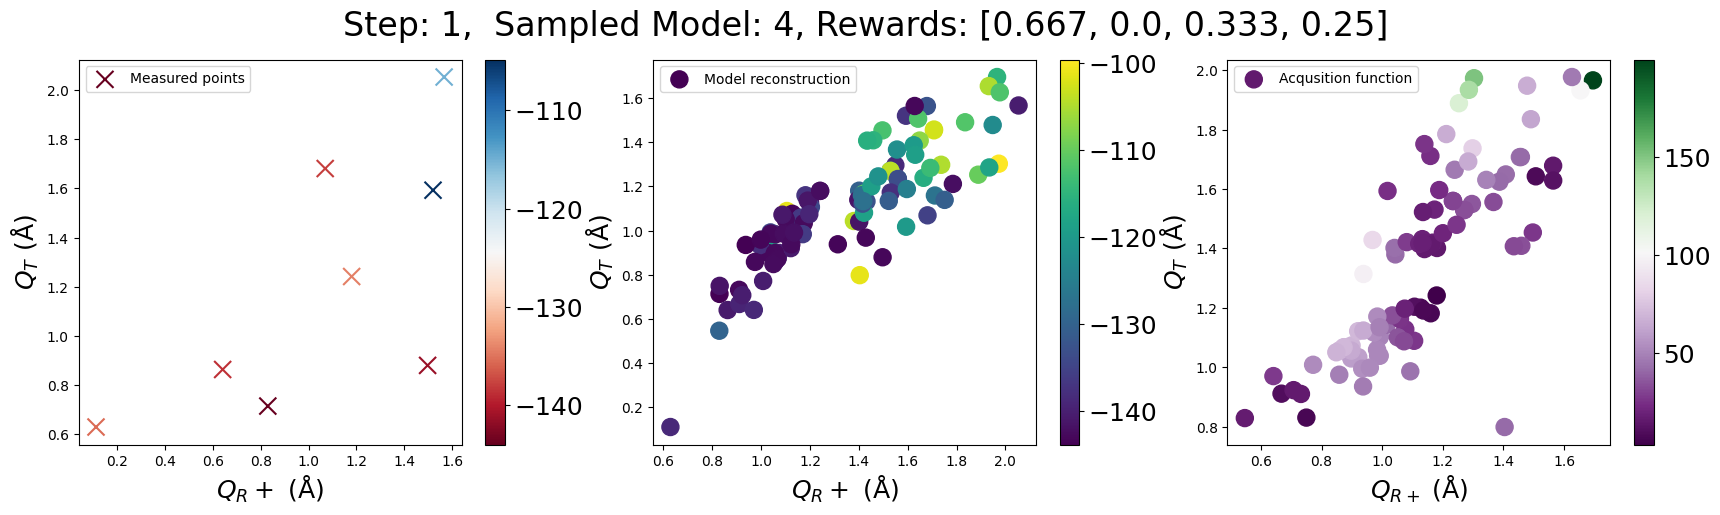

sample: 100%|██████████| 2000/2000 [00:04<00:00, 456.21it/s, 7 steps of size 5.87e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         a1    -53.87      0.99    -53.84    -55.54    -52.33   1188.29      1.00
         a2    -53.70      0.99    -53.71    -55.16    -51.94   1548.79      1.00
k_length[0]      0.52      0.08      0.53      0.38      0.66    971.11      1.00
k_length[1]      0.86      0.25      0.85      0.44      1.24   1214.29      1.00
  k_length1      0.52      0.08      0.53      0.38      0.66    971.11      1.00
  k_length2      0.86      0.25      0.85      0.44      1.24   1214.29      1.00
    k_scale   4200.87   1367.46   3903.82   2199.56   6187.49   1067.25      1.00
      noise      1.70      2.12      1.08      0.09      3.80    863.87      1.00

False
Exploration step 5/45
Using model 1


sample: 100%|██████████| 2000/2000 [00:06<00:00, 325.63it/s, 7 steps of size 5.40e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.01      1.42      2.76      1.00      5.05   1136.75      1.00
         a1    -53.87      1.06    -53.88    -55.68    -52.24   2196.36      1.00
         a2    -53.67      0.98    -53.67    -55.09    -51.97   1812.03      1.00
         a3      0.05      0.47      0.06     -0.71      0.80   1653.92      1.00
k_length[0]      0.51      0.09      0.52      0.37      0.66    694.41      1.00
k_length[1]      0.84      0.26      0.80      0.47      1.28    964.49      1.00
  k_length1      0.51      0.09      0.52      0.37      0.66    694.41      1.00
  k_length2      0.84      0.26      0.80      0.47      1.28    964.49      1.00
    k_scale   4119.49   1373.75   3843.39   2156.49   5918.08    972.89      1.00
      noise      1.73      2.24      1.08      0.08      3.79    973.20      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 4  reward (avg) 0.25
model 2:  counts 3  reward (a

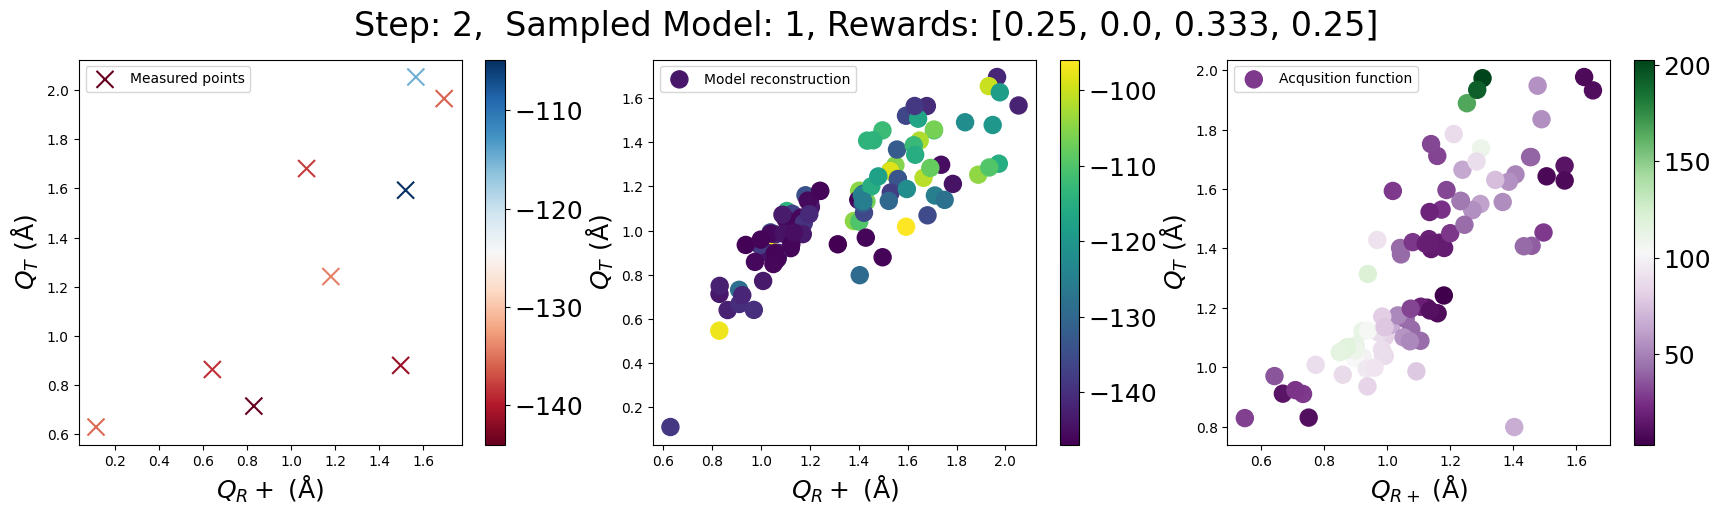

sample: 100%|██████████| 2000/2000 [00:06<00:00, 304.28it/s, 7 steps of size 5.93e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.18      0.43      1.10      0.53      1.79   1659.62      1.00
         a1    -53.90      1.00    -53.92    -55.48    -52.33   1497.21      1.00
         a2    -53.69      0.94    -53.71    -55.27    -52.21   1791.01      1.00
         a3      1.00      0.47      1.00      0.24      1.76   1787.34      1.00
      alpha    -14.73      0.94    -14.75    -16.31    -13.29   1872.26      1.00
k_length[0]      0.39      0.07      0.38      0.29      0.48    301.52      1.00
k_length[1]      0.75      0.22      0.72      0.42      1.10   1138.12      1.00
  k_length1      0.39      0.07      0.38      0.29      0.48    301.52      1.00
  k_length2      0.75      0.22      0.72      0.42      1.10   1138.12      1.00
    k_scale   5421.49   1760.67   5140.82   2750.63   7871.16   1084.36      1.00
      noise      2.11      4.28      1.05      0.06      4.14    126.26      1.01

False
Explorat

sample: 100%|██████████| 2000/2000 [00:06<00:00, 317.09it/s, 7 steps of size 4.94e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.01      1.43      2.74      0.93      5.04   1084.19      1.00
         a1    -53.87      1.04    -53.85    -55.56    -52.16   2378.80      1.00
         a2    -53.67      0.99    -53.66    -55.14    -51.87   1703.66      1.00
         a3      0.05      0.46      0.03     -0.70      0.83   1395.81      1.00
k_length[0]      0.36      0.06      0.36      0.26      0.44    952.66      1.00
k_length[1]      0.70      0.21      0.68      0.41      1.07   1072.15      1.00
  k_length1      0.36      0.06      0.36      0.26      0.44    952.66      1.00
  k_length2      0.70      0.21      0.68      0.41      1.07   1072.15      1.00
    k_scale   3919.63   1274.67   3705.75   2084.39   5555.39    818.79      1.00
      noise      2.02      3.55      1.12      0.05      4.24    550.17      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 4  reward (avg) 0.25
model 2:  counts 4  reward (a

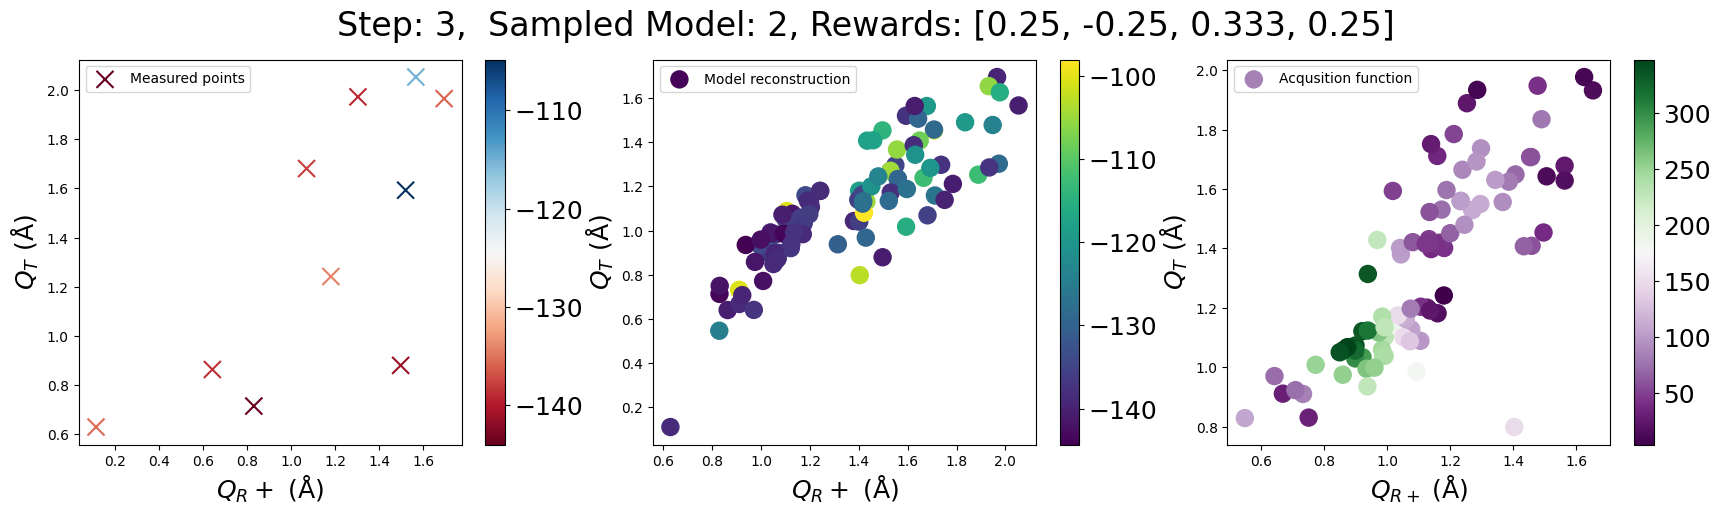

sample: 100%|██████████| 2000/2000 [00:06<00:00, 300.48it/s, 7 steps of size 4.96e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.18      0.44      1.13      0.53      1.86   1312.63      1.00
         a1    -53.84      1.01    -53.83    -55.39    -52.15   1549.49      1.00
         a2    -53.73      0.97    -53.74    -55.29    -52.11   1700.14      1.00
         a3      1.02      0.48      1.04      0.16      1.75   1217.65      1.00
      alpha    -14.72      0.95    -14.73    -16.37    -13.26   1860.82      1.00
k_length[0]      0.36      0.07      0.36      0.27      0.46   1297.13      1.00
k_length[1]      0.63      0.16      0.61      0.38      0.87   1472.75      1.00
  k_length1      0.36      0.07      0.36      0.27      0.46   1297.13      1.00
  k_length2      0.63      0.16      0.61      0.38      0.87   1472.75      1.00
    k_scale   5176.02   1679.77   4877.11   2792.90   7773.09   1108.76      1.00
      noise      1.73      2.16      1.02      0.07      3.88    851.80      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:06<00:00, 309.08it/s, 7 steps of size 5.13e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.01      1.39      2.78      1.05      5.11   1027.71      1.00
         a1    -53.86      1.03    -53.87    -55.37    -51.94   1983.48      1.00
         a2    -53.67      0.97    -53.64    -55.30    -52.17   1483.93      1.00
         a3      0.06      0.46      0.07     -0.74      0.79   1456.25      1.00
k_length[0]      0.34      0.06      0.33      0.25      0.44    755.66      1.00
k_length[1]      0.61      0.17      0.59      0.36      0.90    875.07      1.00
  k_length1      0.34      0.06      0.33      0.25      0.44    755.66      1.00
  k_length2      0.61      0.17      0.59      0.36      0.90    875.07      1.00
    k_scale   3748.53   1139.64   3567.68   2114.09   5268.09    811.19      1.00
      noise      2.01      4.30      1.05      0.05      3.92    235.22      1.01

False

CURRENT MODEL REWARDS
model 1:  counts 4  reward (avg) 0.25
model 2:  counts 4  reward (a

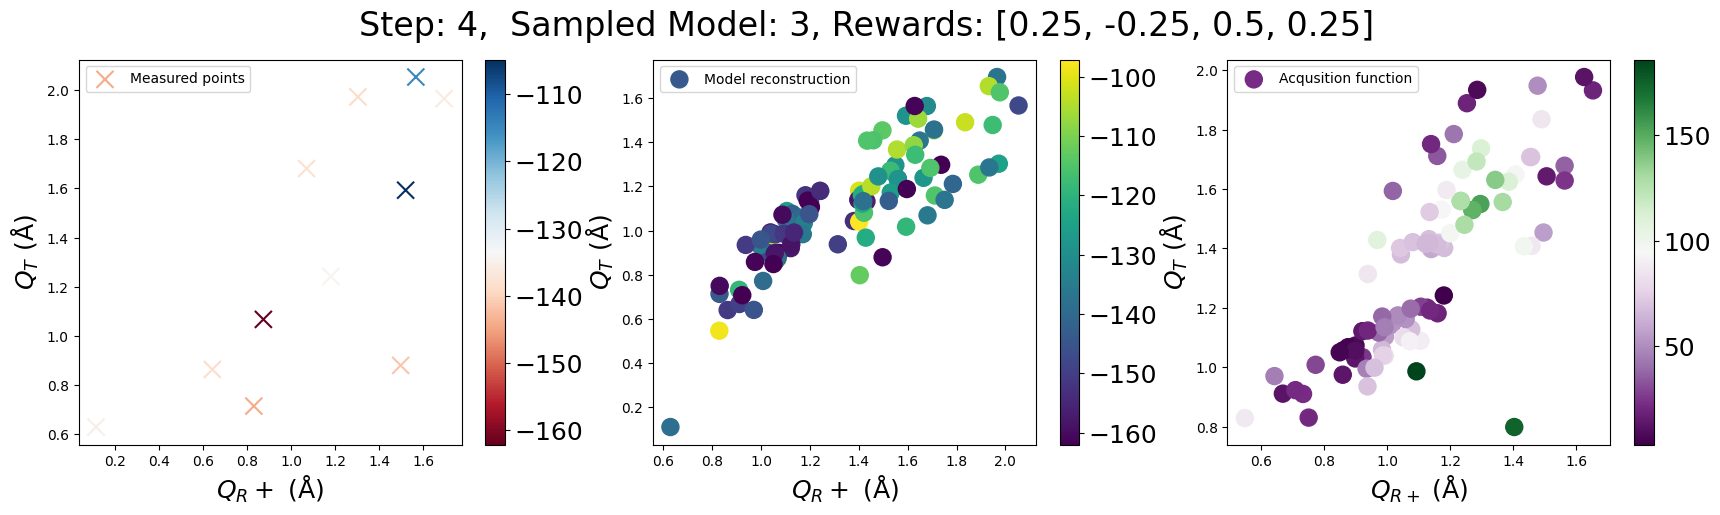

sample: 100%|██████████| 2000/2000 [00:06<00:00, 294.50it/s, 7 steps of size 5.93e-01. acc. prob=0.87] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.16      0.42      1.10      0.55      1.75   1473.99      1.00
         a1    -53.87      0.96    -53.87    -55.40    -52.29   1592.96      1.00
         a2    -53.69      0.98    -53.68    -55.37    -52.21   1930.92      1.00
         a3      1.02      0.49      1.01      0.20      1.76   1734.68      1.00
      alpha    -14.74      0.96    -14.78    -16.21    -13.03   2198.67      1.00
k_length[0]      0.34      0.05      0.33      0.27      0.41   1054.50      1.00
k_length[1]      0.69      0.18      0.68      0.39      0.96   1871.60      1.00
  k_length1      0.34      0.05      0.33      0.27      0.41   1054.50      1.00
  k_length2      0.69      0.18      0.68      0.39      0.96   1871.60      1.00
    k_scale   5092.49   1678.63   4818.80   2746.12   7454.23   1378.18      1.00
      noise      1.81      2.71      1.00      0.06      3.97    559.67      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:06<00:00, 303.31it/s, 7 steps of size 5.69e-01. acc. prob=0.88] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.01      1.48      2.70      0.86      4.99   1358.84      1.00
         a1    -53.83      1.03    -53.84    -55.52    -52.05   1799.29      1.00
         a2    -53.62      1.00    -53.60    -55.29    -52.03   1491.92      1.00
         a3      0.07      0.45      0.06     -0.62      0.85   1534.54      1.00
k_length[0]      0.34      0.13      0.32      0.24      0.41     31.42      1.03
k_length[1]      0.69      0.20      0.67      0.39      1.00    206.83      1.01
  k_length1      0.34      0.13      0.32      0.24      0.41     31.42      1.03
  k_length2      0.69      0.20      0.67      0.39      1.00    206.83      1.01
    k_scale   3742.06   1148.90   3552.69   1971.82   5374.17    746.35      1.00
      noise      4.90     16.80      1.13      0.04      6.19     38.19      1.04

False

CURRENT MODEL REWARDS
model 1:  counts 4  reward (avg) 0.25
model 2:  counts 4  reward (a

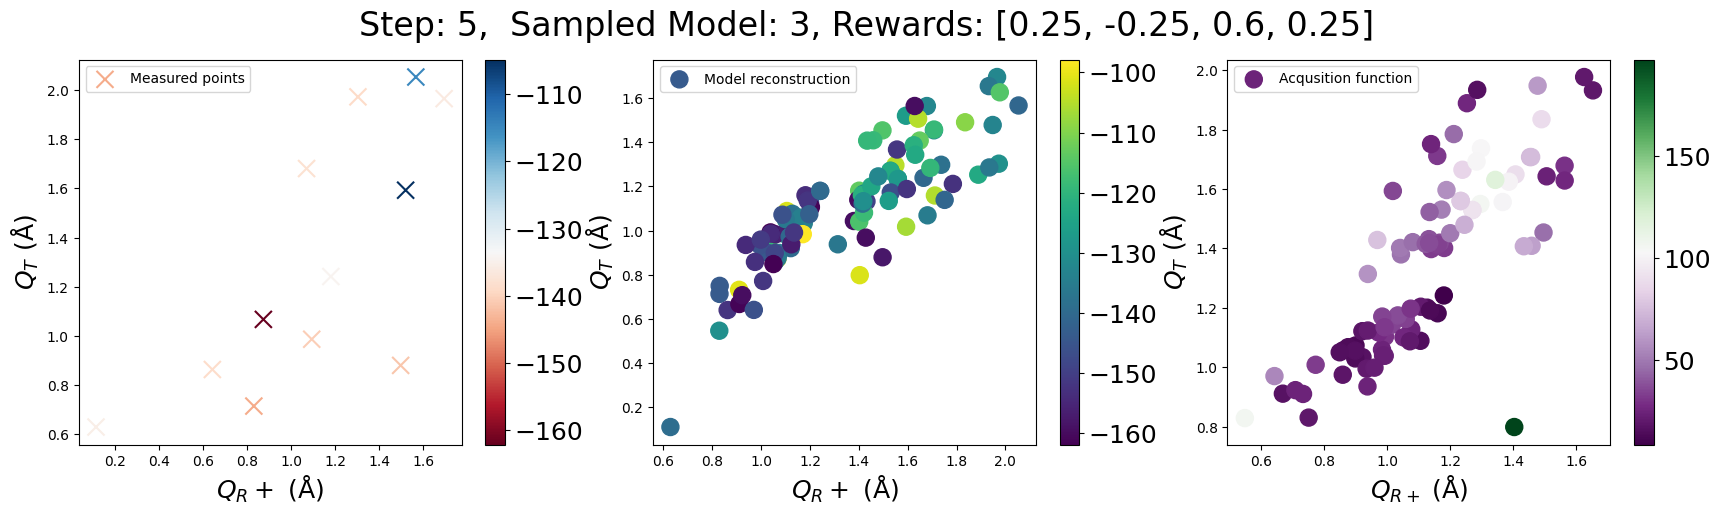

sample: 100%|██████████| 2000/2000 [00:06<00:00, 293.59it/s, 7 steps of size 4.92e-01. acc. prob=0.87] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.14      0.42      1.07      0.53      1.80   1194.75      1.00
         a1    -53.85      1.02    -53.89    -55.63    -52.28   1327.24      1.00
         a2    -53.67      0.98    -53.68    -55.07    -51.80   1225.52      1.00
         a3      1.02      0.49      1.03      0.18      1.76   1191.96      1.00
      alpha    -14.69      0.95    -14.71    -16.21    -13.16   1178.97      1.00
k_length[0]      0.33      0.05      0.32      0.26      0.39    558.68      1.00
k_length[1]      0.75      0.19      0.74      0.45      1.04    994.49      1.00
  k_length1      0.33      0.05      0.32      0.26      0.39    558.68      1.00
  k_length2      0.75      0.19      0.74      0.45      1.04    994.49      1.00
    k_scale   5158.91   1701.70   4811.52   2644.27   7576.21   1087.83      1.00
      noise      1.84      2.46      1.04      0.05      4.13    787.78      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:06<00:00, 298.92it/s, 7 steps of size 5.00e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.02      1.58      2.74      0.83      5.05    908.03      1.00
         a1    -53.84      1.05    -53.85    -55.69    -52.21   2075.17      1.00
         a2    -53.65      0.99    -53.65    -55.23    -52.03   1620.37      1.00
         a3      0.06      0.47      0.07     -0.61      0.95   1268.24      1.00
k_length[0]      0.34      0.11      0.31      0.23      0.40     37.22      1.01
k_length[1]      0.73      0.19      0.72      0.45      1.05    228.80      1.00
  k_length1      0.34      0.11      0.31      0.23      0.40     37.22      1.01
  k_length2      0.73      0.19      0.72      0.45      1.05    228.80      1.00
    k_scale   3749.55   1097.38   3589.76   2240.05   5330.24    977.98      1.00
      noise      4.75     12.51      1.19      0.06      6.79     36.81      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 4  reward (avg) 0.25
model 2:  counts 4  reward (a

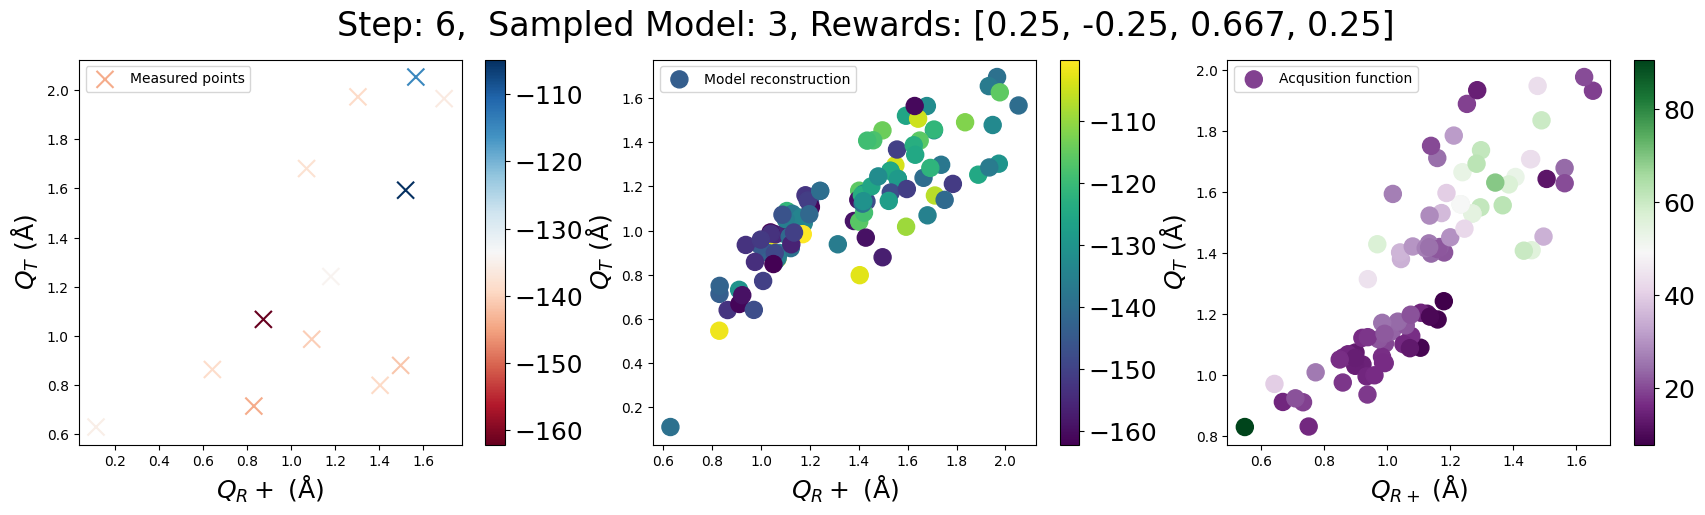

sample: 100%|██████████| 2000/2000 [00:07<00:00, 259.63it/s, 15 steps of size 2.97e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.12      0.40      1.06      0.49      1.69   1017.07      1.00
         a1    -53.82      1.01    -53.81    -55.49    -52.19   1128.96      1.00
         a2    -53.66      1.00    -53.63    -55.28    -52.14   1280.17      1.00
         a3      1.02      0.50      1.01      0.22      1.84   1275.48      1.00
      alpha    -14.76      0.95    -14.78    -16.34    -13.23   1113.20      1.00
k_length[0]      0.35      0.11      0.32      0.24      0.47    335.23      1.00
k_length[1]      0.68      0.23      0.67      0.31      1.01    480.87      1.00
  k_length1      0.35      0.11      0.32      0.24      0.47    335.23      1.00
  k_length2      0.68      0.23      0.67      0.31      1.01    480.87      1.00
    k_scale   5150.99   1837.90   4821.64   2694.24   7667.45    819.47      1.00
      noise      2.78      5.28      1.25      0.05      5.92    583.99      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:06<00:00, 288.98it/s, 7 steps of size 3.80e-01. acc. prob=0.89]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.06      1.53      2.75      0.91      5.15   1054.99      1.00
         a1    -53.88      1.02    -53.86    -55.50    -52.30   1060.93      1.00
         a2    -53.62      0.99    -53.61    -55.23    -51.98   1137.54      1.00
         a3      0.05      0.50      0.05     -0.80      0.86    887.58      1.00
k_length[0]      0.33      0.09      0.30      0.24      0.43    216.84      1.00
k_length[1]      0.68      0.21      0.69      0.34      1.01    425.66      1.00
  k_length1      0.33      0.09      0.30      0.24      0.43    216.84      1.00
  k_length2      0.68      0.21      0.69      0.34      1.01    425.66      1.00
    k_scale   3813.11   1111.47   3609.85   2251.05   5567.04    697.54      1.00
      noise      3.46      9.17      1.31      0.08      6.32    167.08      1.01

False

CURRENT MODEL REWARDS
model 1:  counts 4  reward (avg) 0.25
model 2:  counts 5  reward (a

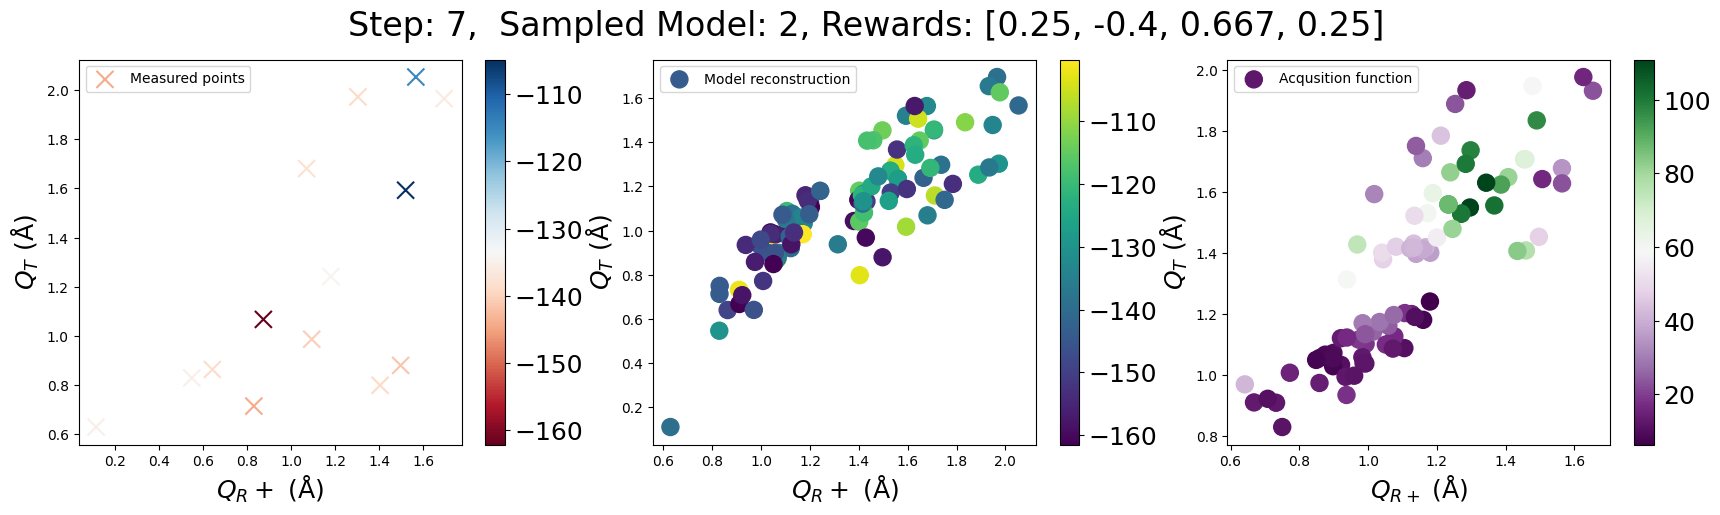

sample: 100%|██████████| 2000/2000 [00:06<00:00, 285.98it/s, 15 steps of size 3.85e-01. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.12      0.42      1.05      0.47      1.72    884.52      1.00
         a1    -53.79      1.06    -53.79    -55.46    -51.96    822.53      1.00
         a2    -53.64      0.98    -53.66    -55.07    -51.82    818.21      1.00
         a3      1.02      0.49      1.02      0.20      1.79   1037.52      1.00
      alpha    -14.73      0.95    -14.73    -16.44    -13.35    911.86      1.00
k_length[0]      0.31      0.03      0.30      0.26      0.35   1119.12      1.00
k_length[1]      0.83      0.19      0.83      0.51      1.11   1143.96      1.00
  k_length1      0.31      0.03      0.30      0.26      0.35   1119.12      1.00
  k_length2      0.83      0.19      0.83      0.51      1.11   1143.96      1.00
    k_scale   5207.64   1736.15   4908.17   2540.88   7596.84    931.60      1.00
      noise      1.71      2.12      1.00      0.04      3.60    873.81      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:07<00:00, 274.32it/s, 7 steps of size 6.18e-01. acc. prob=0.87] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      2.98      1.43      2.69      0.86      4.98   1446.37      1.00
         a1    -53.84      1.04    -53.84    -55.57    -52.15   1876.58      1.00
         a2    -53.61      1.00    -53.67    -55.30    -51.94   1210.52      1.00
         a3      0.07      0.46      0.08     -0.69      0.81   1917.42      1.00
k_length[0]      0.29      0.03      0.29      0.25      0.34   1039.33      1.00
k_length[1]      0.80      0.17      0.79      0.51      1.08   1079.33      1.00
  k_length1      0.29      0.03      0.29      0.25      0.34   1039.33      1.00
  k_length2      0.80      0.17      0.79      0.51      1.08   1079.33      1.00
    k_scale   3758.31   1160.48   3577.72   2103.15   5309.86    819.71      1.00
      noise      1.71      2.30      1.00      0.07      3.74    795.50      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 5  reward (avg) 0.4
model 2:  counts 5  reward (av

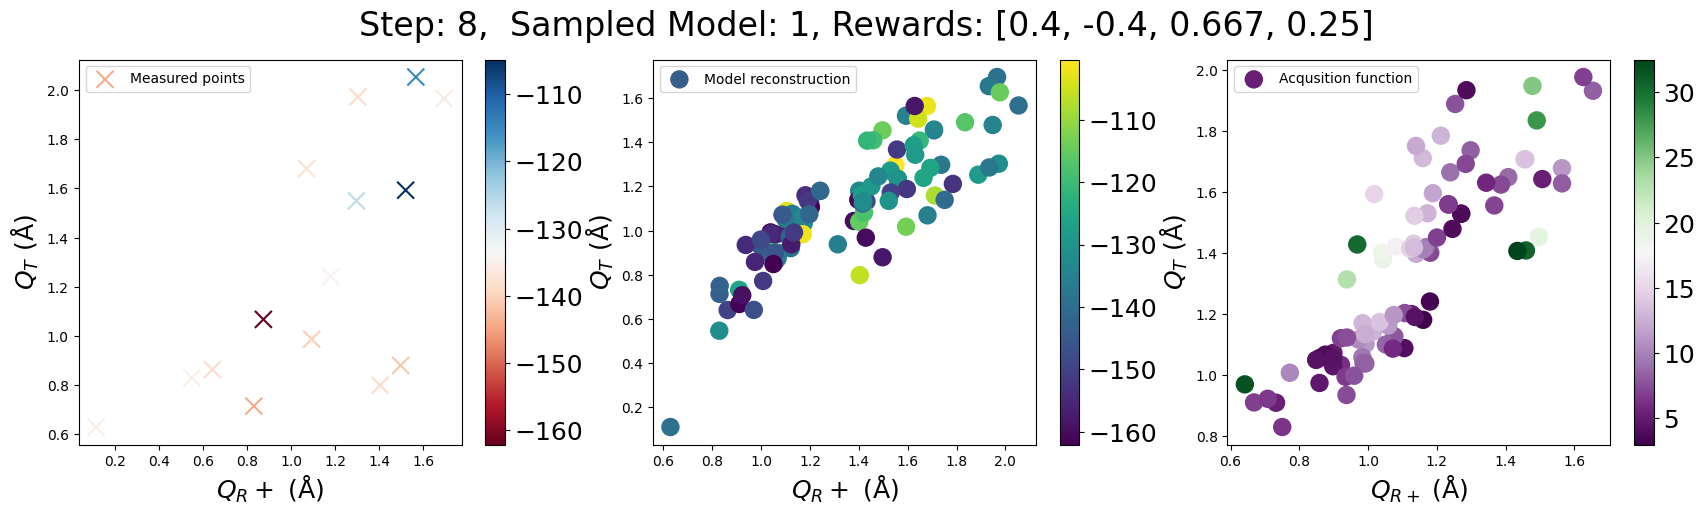

sample: 100%|██████████| 2000/2000 [00:06<00:00, 301.79it/s, 7 steps of size 5.09e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.16      0.43      1.10      0.50      1.81   1528.55      1.00
         a1    -53.81      0.99    -53.77    -55.45    -52.27   1754.58      1.00
         a2    -53.75      0.97    -53.79    -55.45    -52.29   1328.37      1.00
         a3      1.02      0.49      1.03      0.19      1.79   1404.93      1.00
      alpha    -14.71      0.94    -14.74    -16.22    -13.14   1857.72      1.00
k_length[0]      0.28      0.03      0.28      0.24      0.33    933.48      1.00
k_length[1]      0.59      0.10      0.59      0.42      0.75   1113.85      1.00
  k_length1      0.28      0.03      0.28      0.24      0.33    933.48      1.00
  k_length2      0.59      0.10      0.59      0.42      0.75   1113.85      1.00
    k_scale   4807.67   1486.78   4548.14   2586.43   6831.99   1035.80      1.00
      noise      1.82      2.33      1.05      0.08      4.06    792.55      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:06<00:00, 307.29it/s, 7 steps of size 4.91e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      2.96      1.40      2.69      0.86      4.88   1250.87      1.00
         a1    -53.79      1.05    -53.79    -55.49    -52.05   2021.88      1.00
         a2    -53.68      0.98    -53.68    -55.43    -52.27   1357.44      1.00
         a3      0.05      0.47      0.06     -0.71      0.82   1418.76      1.00
k_length[0]      0.27      0.04      0.27      0.22      0.33    158.39      1.00
k_length[1]      0.54      0.11      0.55      0.36      0.71    281.31      1.00
  k_length1      0.27      0.04      0.27      0.22      0.33    158.39      1.00
  k_length2      0.54      0.11      0.55      0.36      0.71    281.31      1.00
    k_scale   3550.76   1034.07   3368.24   2087.07   4917.51    812.08      1.00
      noise      1.96      2.98      1.13      0.04      4.35    738.29      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 5  reward (avg) 0.4
model 2:  counts 5  reward (av

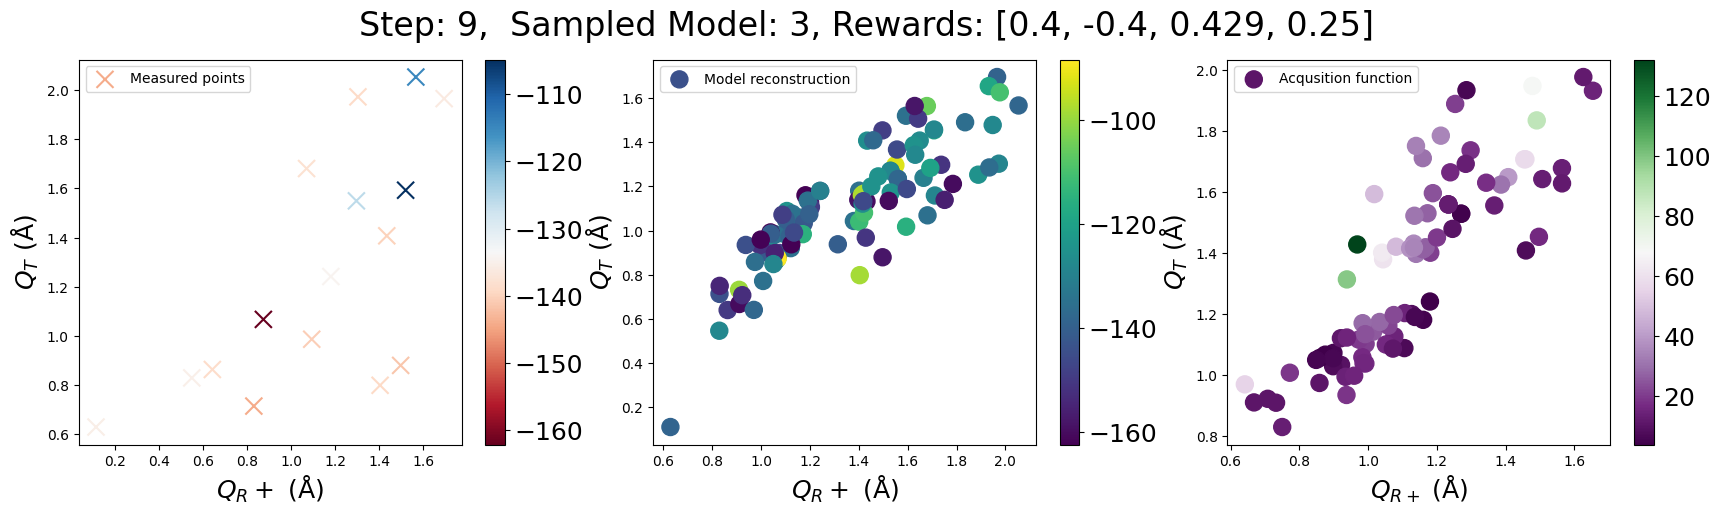

sample: 100%|██████████| 2000/2000 [00:07<00:00, 267.71it/s, 23 steps of size 3.91e-01. acc. prob=0.87]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.15      0.41      1.10      0.57      1.86    882.76      1.00
         a1    -53.81      1.04    -53.80    -55.45    -52.08    846.20      1.00
         a2    -53.75      1.01    -53.75    -55.32    -52.04    897.44      1.00
         a3      1.02      0.49      1.02      0.24      1.85    846.09      1.00
      alpha    -14.70      0.97    -14.74    -16.33    -13.17    852.30      1.00
k_length[0]      0.29      0.03      0.29      0.25      0.35    946.82      1.00
k_length[1]      0.52      0.08      0.52      0.40      0.67    957.07      1.00
  k_length1      0.29      0.03      0.29      0.25      0.35    946.82      1.00
  k_length2      0.52      0.08      0.52      0.40      0.67    957.07      1.00
    k_scale   4695.02   1421.23   4491.30   2643.39   6804.50    681.79      1.00
      noise      2.16      3.16      1.08      0.04      4.88    709.67      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:06<00:00, 326.05it/s, 7 steps of size 5.14e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      2.99      1.39      2.74      0.88      4.94   1275.43      1.00
         a1    -53.80      1.06    -53.80    -55.66    -52.14   2027.96      1.00
         a2    -53.69      1.00    -53.68    -55.50    -52.21   1716.84      1.00
         a3      0.07      0.48      0.08     -0.78      0.83   1765.34      1.00
k_length[0]      0.28      0.04      0.28      0.23      0.33    256.18      1.00
k_length[1]      0.50      0.09      0.50      0.36      0.64    514.98      1.00
  k_length1      0.28      0.04      0.28      0.23      0.33    256.18      1.00
  k_length2      0.50      0.09      0.50      0.36      0.64    514.98      1.00
    k_scale   3464.43    948.66   3335.61   2193.62   4909.48   1029.64      1.00
      noise      2.05      2.63      1.15      0.05      4.86   1010.99      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 5  reward (avg) 0.4
model 2:  counts 6  reward (av

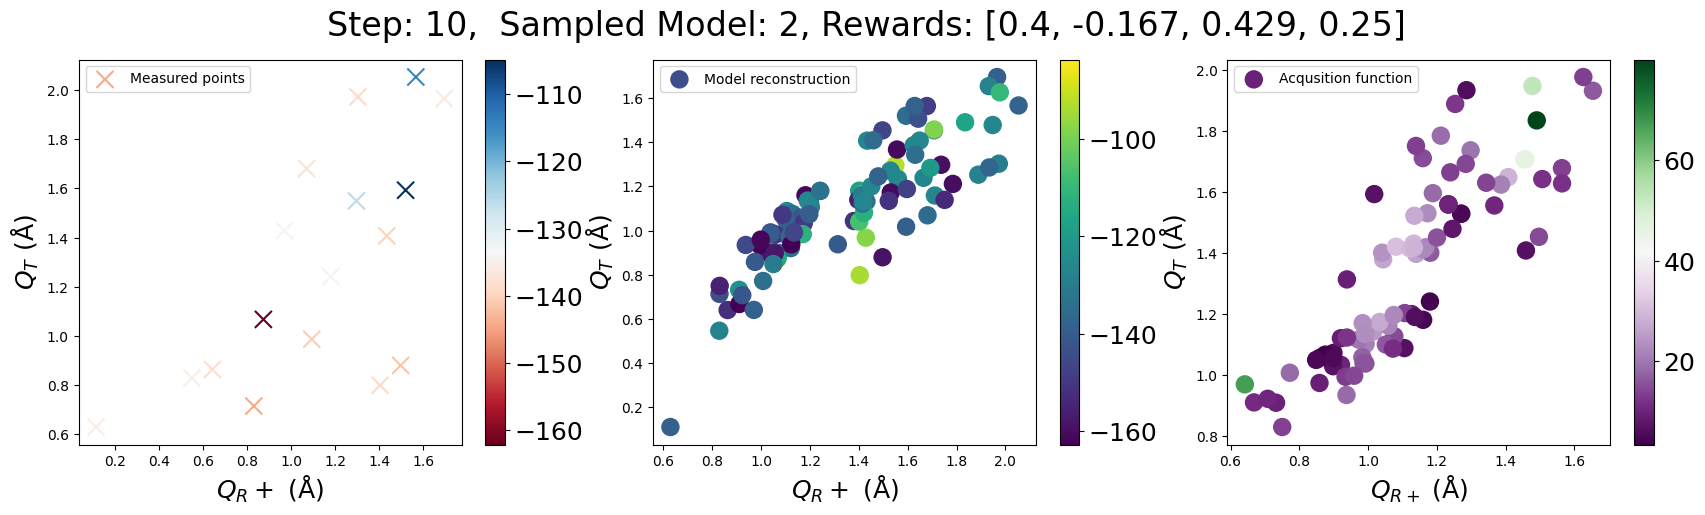

sample: 100%|██████████| 2000/2000 [00:06<00:00, 292.66it/s, 31 steps of size 1.55e-01. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.11      0.42      1.04      0.45      1.71    796.17      1.00
         a1    -53.78      1.03    -53.74    -55.38    -52.01    991.14      1.00
         a2    -53.66      0.97    -53.66    -55.08    -51.93    800.64      1.00
         a3      1.00      0.49      0.99      0.21      1.79    717.68      1.00
      alpha    -14.70      0.98    -14.69    -16.34    -13.15    784.42      1.00
k_length[0]      0.68      0.30      0.67      0.16      1.09     59.45      1.02
k_length[1]      0.82      0.31      0.83      0.22      1.23     15.15      1.11
  k_length1      0.68      0.30      0.67      0.16      1.09     59.45      1.02
  k_length2      0.82      0.31      0.83      0.22      1.23     15.15      1.11
    k_scale   5808.71   2116.16   5394.94   2714.89   8768.56    682.22      1.00
      noise     52.26     35.78     56.07      0.10     93.71     18.39      1.11

False
Explorat

sample: 100%|██████████| 2000/2000 [00:06<00:00, 320.84it/s, 31 steps of size 1.98e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.22      1.70      2.82      0.84      5.57    722.90      1.00
         a1    -53.82      1.01    -53.81    -55.41    -52.16    754.37      1.00
         a2    -53.69      1.01    -53.69    -55.36    -52.08    996.14      1.00
         a3      0.12      0.49      0.10     -0.68      0.89    724.87      1.00
k_length[0]      0.61      0.26      0.54      0.23      1.04     23.23      1.00
k_length[1]      0.54      0.35      0.30      0.19      1.07      9.45      1.00
  k_length1      0.61      0.26      0.54      0.23      1.04     23.23      1.00
  k_length2      0.54      0.35      0.30      0.19      1.07      9.45      1.00
    k_scale   4227.35   1401.73   3955.12   2346.96   6175.89    691.71      1.00
      noise     30.08     36.84      3.99      0.09     80.76     10.90      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 5  reward (avg) 0.4
model 2:  counts 6  reward (av

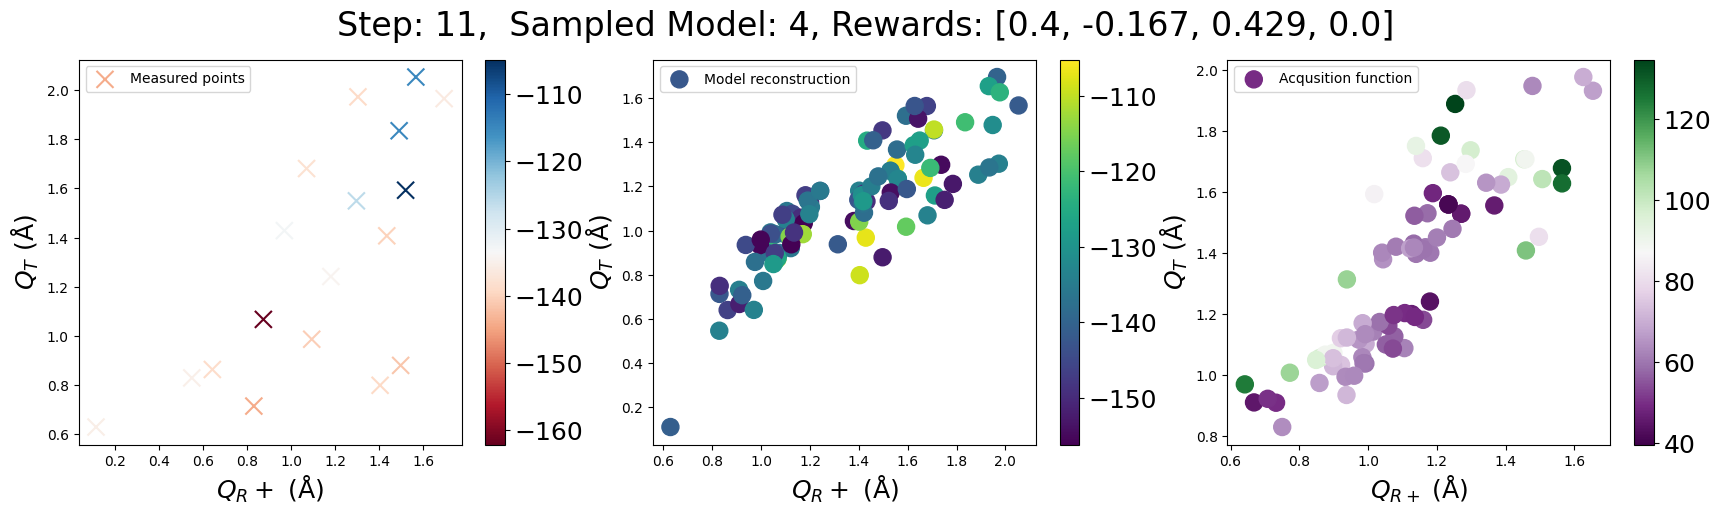

sample: 100%|██████████| 2000/2000 [00:06<00:00, 291.06it/s, 15 steps of size 1.54e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.08      0.37      1.02      0.53      1.69    490.80      1.00
         a1    -53.73      1.07    -53.75    -55.34    -51.89    803.88      1.00
         a2    -53.71      0.97    -53.73    -55.24    -52.10    681.37      1.00
         a3      1.01      0.50      1.01      0.24      1.90    682.85      1.00
      alpha    -14.63      0.98    -14.65    -16.20    -12.95    705.36      1.00
k_length[0]      0.53      0.21      0.47      0.27      0.82     51.48      1.02
k_length[1]      0.45      0.33      0.27      0.17      0.98      7.77      1.08
  k_length1      0.53      0.21      0.47      0.27      0.82     51.48      1.02
  k_length2      0.45      0.33      0.27      0.17      0.98      7.77      1.08
    k_scale   5702.10   1918.42   5359.68   3116.65   8781.53    599.54      1.00
      noise     28.61     43.22      2.19      0.04     94.92      7.99      1.09

False
Explorat

sample: 100%|██████████| 2000/2000 [00:06<00:00, 302.54it/s, 15 steps of size 3.92e-01. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.15      1.66      2.82      0.89      5.49    985.99      1.00
         a1    -53.79      1.00    -53.78    -55.40    -52.17    940.38      1.00
         a2    -53.65      0.98    -53.60    -55.26    -52.11    959.52      1.00
         a3      0.15      0.49      0.16     -0.64      0.95    853.51      1.00
k_length[0]      0.46      0.15      0.43      0.28      0.67    157.04      1.00
k_length[1]      0.27      0.16      0.23      0.17      0.31     25.55      1.04
  k_length1      0.46      0.15      0.43      0.28      0.67    157.04      1.00
  k_length2      0.27      0.16      0.23      0.17      0.31     25.55      1.04
    k_scale   4334.85   1359.75   4100.97   2487.98   6361.22    491.69      1.00
      noise      6.07     19.27      1.17      0.05      7.17     24.73      1.05

False

CURRENT MODEL REWARDS
model 1:  counts 5  reward (avg) 0.4
model 2:  counts 6  reward (av

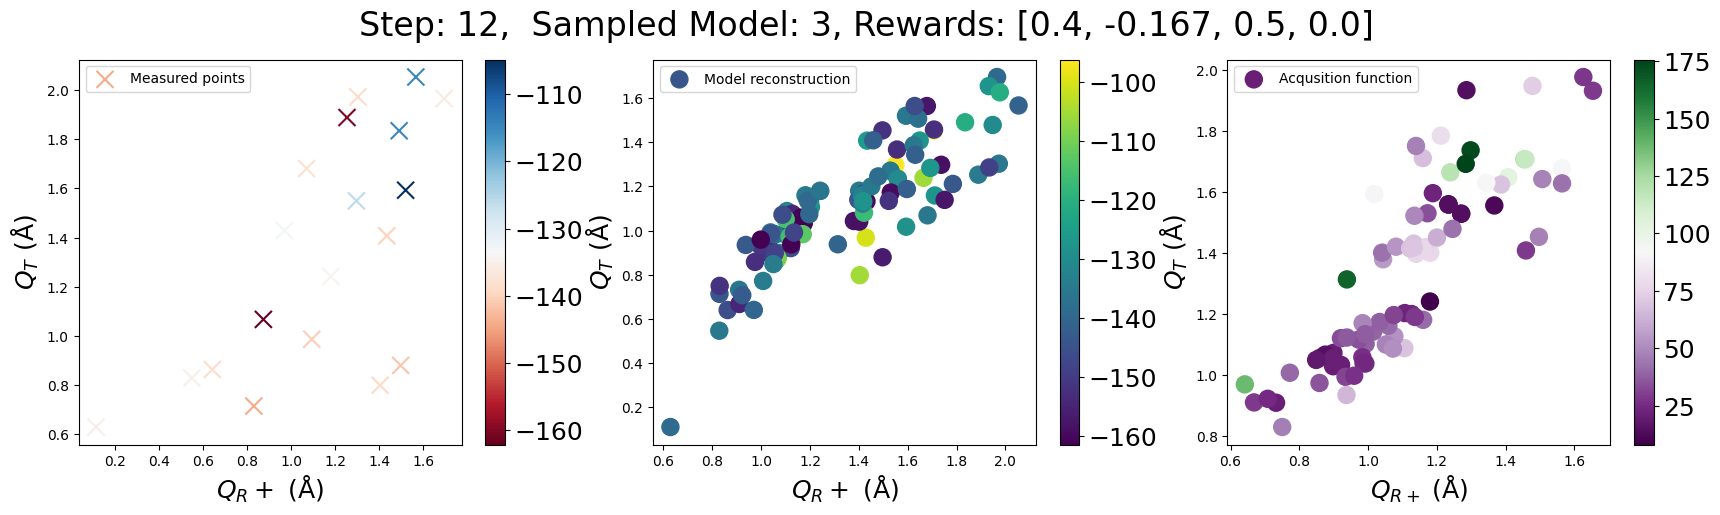

sample: 100%|██████████| 2000/2000 [00:07<00:00, 255.05it/s, 15 steps of size 1.31e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.09      0.38      1.04      0.47      1.68    734.85      1.00
         a1    -53.78      0.99    -53.72    -55.38    -52.19    841.30      1.00
         a2    -53.66      0.96    -53.64    -55.29    -52.13    896.03      1.00
         a3      1.02      0.50      1.03      0.31      1.91   1013.08      1.00
      alpha    -14.65      0.97    -14.62    -16.18    -13.05    720.15      1.00
k_length[0]      0.45      0.20      0.45      0.11      0.64     13.73      1.18
k_length[1]      0.47      0.32      0.27      0.18      0.93     10.94      1.05
  k_length1      0.45      0.20      0.45      0.11      0.64     13.73      1.18
  k_length2      0.47      0.32      0.27      0.18      0.93     10.94      1.05
    k_scale   5757.95   1845.72   5417.52   2999.24   8245.54    569.66      1.00
      noise     20.90     36.76      1.87      0.05     86.87      7.07      1.25



sample: 100%|██████████| 2000/2000 [00:06<00:00, 288.40it/s, 15 steps of size 1.40e-01. acc. prob=0.88]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.07      0.42      0.99      0.44      1.64    800.17      1.00
         a1    -53.72      0.98    -53.73    -55.41    -52.16    714.20      1.00
         a2    -53.69      1.03    -53.68    -55.38    -51.98    886.11      1.00
         a3      1.02      0.51      1.02      0.21      1.79    790.91      1.00
      alpha    -14.73      1.01    -14.75    -16.45    -13.20    857.19      1.00
k_length[0]      0.53      0.20      0.47      0.28      0.81     66.14      1.00
k_length[1]      0.55      0.36      0.29      0.18      1.07      6.39      1.05
  k_length1      0.53      0.20      0.47      0.28      0.81     66.14      1.00
  k_length2      0.55      0.36      0.29      0.18      1.07      6.39      1.05
    k_scale   5481.16   1971.28   5158.08   2623.37   8003.16    601.75      1.00
      noise     38.98     45.04     12.04      0.03    106.91      6.89      1.05

False
Explorat

sample: 100%|██████████| 2000/2000 [00:06<00:00, 295.54it/s, 31 steps of size 1.45e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.11      1.66      2.71      0.84      5.47    723.40      1.00
         a1    -53.81      1.05    -53.78    -55.45    -52.01    592.28      1.00
         a2    -53.64      1.00    -53.66    -55.34    -52.00    748.10      1.00
         a3      0.11      0.50      0.10     -0.63      1.00    765.95      1.00
k_length[0]      0.49      0.18      0.44      0.30      0.77     41.05      1.00
k_length[1]      0.42      0.32      0.25      0.18      0.95     15.43      1.01
  k_length1      0.49      0.18      0.44      0.30      0.77     41.05      1.00
  k_length2      0.42      0.32      0.25      0.18      0.95     15.43      1.01
    k_scale   4070.71   1244.57   3819.86   2221.45   5855.89    588.33      1.00
      noise     26.34     42.03      2.09      0.04     92.62     15.65      1.01

False

CURRENT MODEL REWARDS
model 1:  counts 5  reward (avg) 0.4
model 2:  counts 6  reward (av

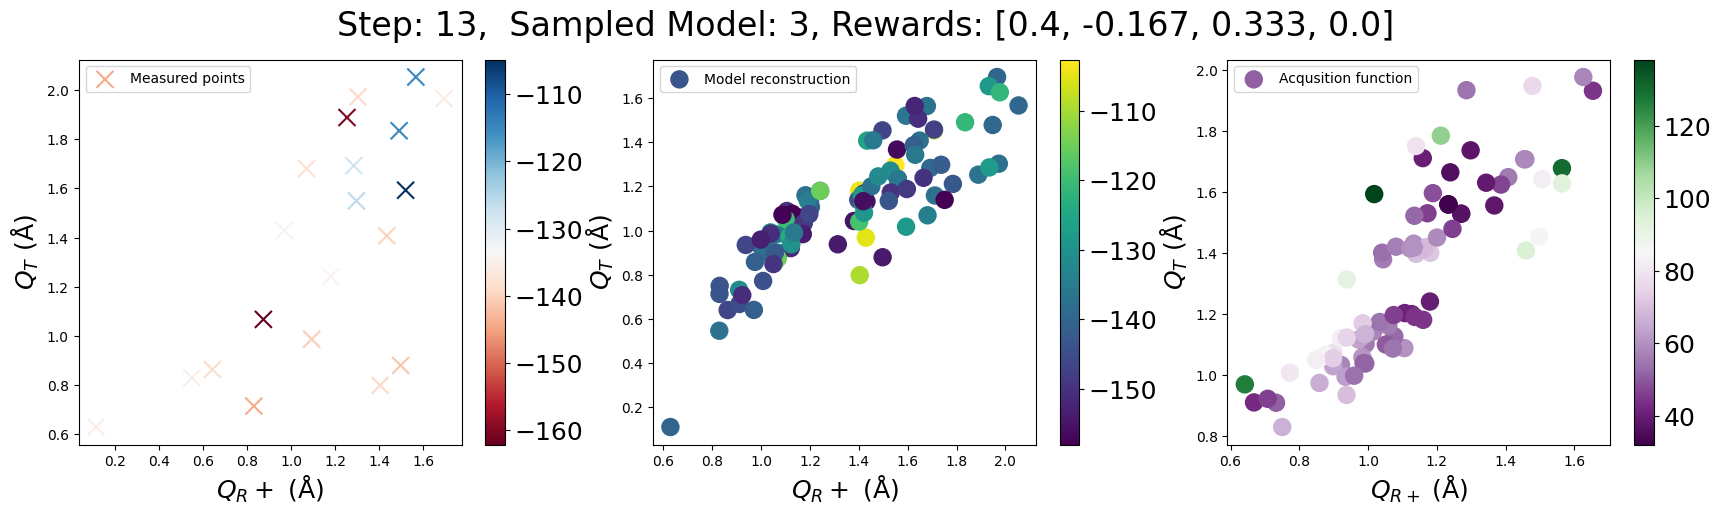

sample: 100%|██████████| 2000/2000 [00:06<00:00, 324.96it/s, 15 steps of size 1.26e-01. acc. prob=0.95]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         a1    -53.74      0.92    -53.73    -55.41    -52.42    579.11      1.00
         a2    -53.64      1.01    -53.70    -55.39    -52.14    586.04      1.00
k_length[0]      0.50      0.23      0.41      0.25      0.87    108.40      1.01
k_length[1]      0.65      0.33      0.67      0.16      1.06     43.58      1.04
  k_length1      0.50      0.23      0.41      0.25      0.87    108.40      1.01
  k_length2      0.65      0.33      0.67      0.16      1.06     43.58      1.04
    k_scale   3897.31   1246.47   3666.56   2069.12   5863.93    495.02      1.00
      noise     52.14     37.93     51.32      0.05    102.99     42.77      1.04

False
Exploration step 17/45
Using model 1


sample: 100%|██████████| 2000/2000 [00:07<00:00, 267.69it/s, 15 steps of size 2.09e-01. acc. prob=0.87]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.13      1.61      2.80      0.98      5.36    814.66      1.00
         a1    -53.87      1.03    -53.89    -55.68    -52.36    631.99      1.00
         a2    -53.69      1.03    -53.67    -55.33    -51.98    683.57      1.00
         a3      0.11      0.51      0.11     -0.64      1.03    840.13      1.01
k_length[0]      0.52      0.23      0.43      0.26      0.90    100.77      1.02
k_length[1]      0.58      0.35      0.60      0.17      1.07     23.61      1.08
  k_length1      0.52      0.23      0.43      0.26      0.90    100.77      1.02
  k_length2      0.58      0.35      0.60      0.17      1.07     23.61      1.08
    k_scale   3940.40   1295.45   3727.23   1972.02   5659.69    466.84      1.00
      noise     47.42     43.55     42.91      0.08    105.34     24.59      1.09

False

CURRENT MODEL REWARDS
model 1:  counts 6  reward (avg) 0.167
model 2:  counts 6  reward (

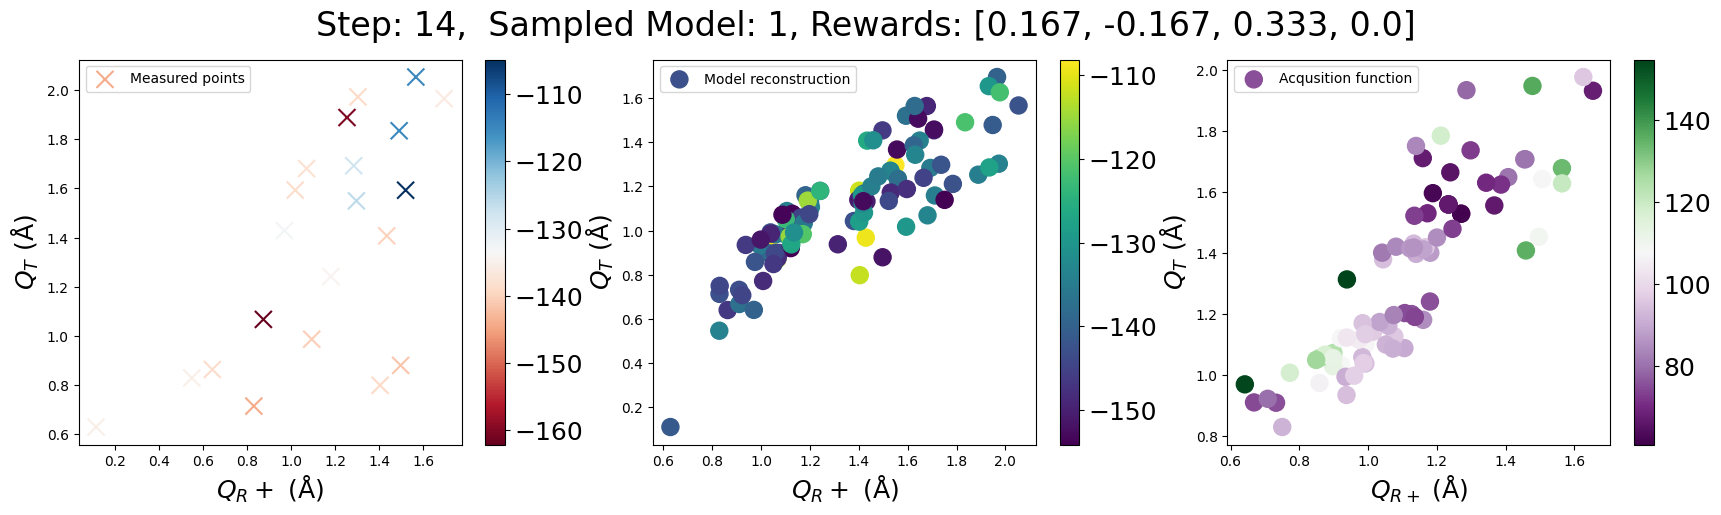

sample: 100%|██████████| 2000/2000 [00:08<00:00, 227.58it/s, 15 steps of size 1.54e-01. acc. prob=0.97]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.12      0.39      1.07      0.50      1.69    848.64      1.00
         a1    -53.78      1.03    -53.72    -55.31    -51.94    891.08      1.00
         a2    -53.69      0.97    -53.70    -55.23    -52.11    967.46      1.00
         a3      1.01      0.49      1.01      0.20      1.82   1063.97      1.00
      alpha    -14.75      1.00    -14.76    -16.48    -13.16   1016.40      1.01
k_length[0]      0.56      0.25      0.47      0.26      0.93    393.10      1.00
k_length[1]      0.81      0.27      0.78      0.47      1.34    253.17      1.00
  k_length1      0.56      0.25      0.47      0.26      0.93    393.10      1.00
  k_length2      0.81      0.27      0.78      0.47      1.34    253.17      1.00
    k_scale   5448.10   2014.57   4964.21   2634.58   8246.72    602.03      1.01
      noise     64.93     33.83     60.50     18.44    123.53    306.17      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:07<00:00, 255.07it/s, 15 steps of size 2.09e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.20      1.60      2.88      1.08      5.68    845.53      1.00
         a1    -53.84      0.98    -53.85    -55.48    -52.37    856.95      1.00
         a2    -53.71      0.99    -53.72    -55.34    -52.15    991.22      1.00
         a3      0.09      0.48      0.08     -0.65      0.94    889.08      1.00
k_length[0]      0.55      0.26      0.45      0.26      0.96    268.37      1.00
k_length[1]      0.76      0.28      0.74      0.18      1.13    188.22      1.00
  k_length1      0.55      0.26      0.45      0.26      0.96    268.37      1.00
  k_length2      0.76      0.28      0.74      0.18      1.13    188.22      1.00
    k_scale   3873.89   1304.49   3659.07   2048.38   5765.94    438.26      1.00
      noise     63.07     35.16     59.38      0.22    109.12    208.84      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 6  reward (avg) 0.167
model 2:  counts 6  reward (

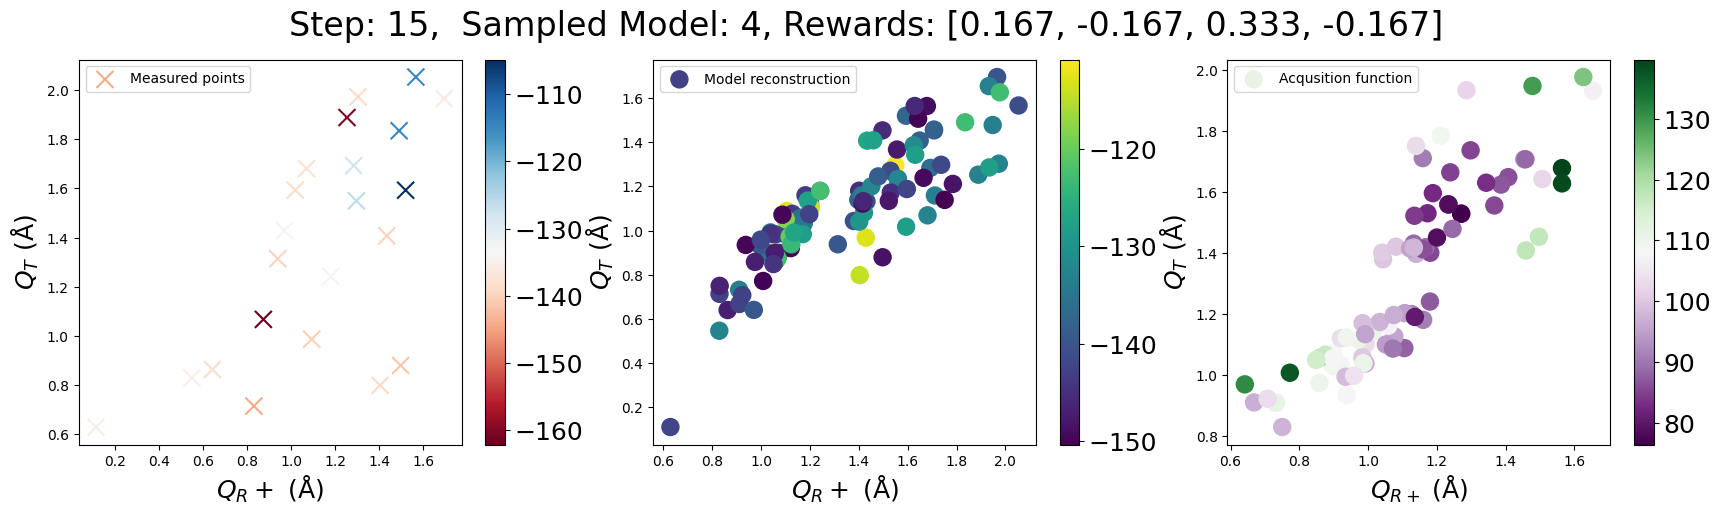

sample: 100%|██████████| 2000/2000 [00:06<00:00, 288.09it/s, 7 steps of size 5.19e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.12      0.42      1.05      0.47      1.67   1328.57      1.00
         a1    -53.80      1.03    -53.81    -55.36    -52.04   1222.59      1.00
         a2    -53.73      0.94    -53.74    -55.23    -52.13   1688.69      1.00
         a3      1.01      0.48      1.03      0.19      1.79   1351.13      1.00
      alpha    -14.70      0.97    -14.72    -16.15    -12.97   2042.51      1.00
k_length[0]      0.80      0.29      0.76      0.35      1.22    860.19      1.00
k_length[1]      0.95      0.30      0.92      0.44      1.38    859.70      1.00
  k_length1      0.80      0.29      0.76      0.35      1.22    860.19      1.00
  k_length2      0.95      0.30      0.92      0.44      1.38    859.70      1.00
    k_scale   6018.40   2439.17   5526.69   2878.70   9833.56   1058.21      1.00
      noise    106.88     36.53    101.81     48.75    155.74   1083.15      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:06<00:00, 318.13it/s, 7 steps of size 5.40e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.10      1.57      2.76      0.96      5.29    962.64      1.00
         a1    -53.79      1.07    -53.80    -55.38    -51.87   2131.88      1.00
         a2    -53.63      0.99    -53.62    -55.27    -52.05   1917.09      1.00
         a3      0.07      0.49      0.07     -0.70      0.88   1761.12      1.00
k_length[0]      0.78      0.28      0.75      0.36      1.22    581.92      1.00
k_length[1]      0.91      0.28      0.89      0.46      1.30    728.50      1.00
  k_length1      0.78      0.28      0.75      0.36      1.22    581.92      1.00
  k_length2      0.91      0.28      0.89      0.46      1.30    728.50      1.00
    k_scale   4163.20   1636.65   3796.67   2064.66   6261.60    774.27      1.00
      noise    107.84     36.35    101.74     52.14    161.67   1067.71      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 6  reward (avg) 0.167
model 2:  counts 6  reward (

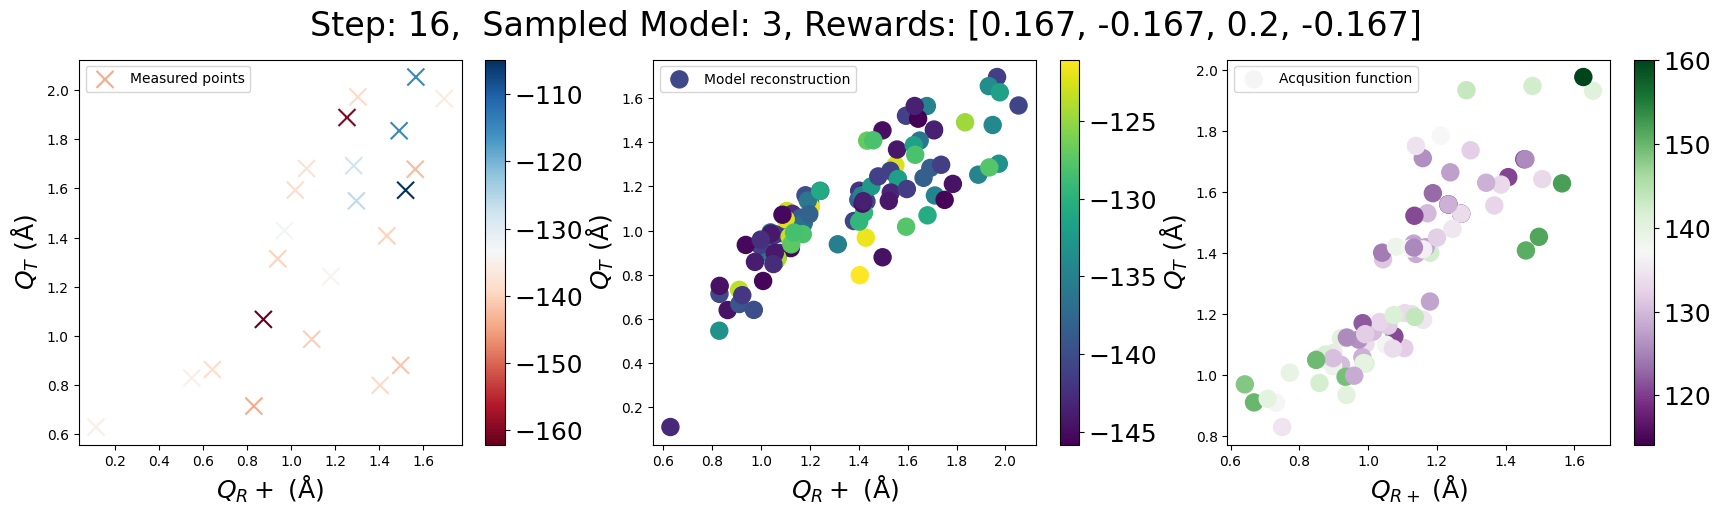

sample: 100%|██████████| 2000/2000 [00:06<00:00, 315.15it/s, 7 steps of size 4.26e-01. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.14      0.41      1.07      0.48      1.75   1115.75      1.00
         a1    -53.80      1.04    -53.82    -55.49    -52.20   1122.66      1.00
         a2    -53.73      0.96    -53.75    -55.33    -52.14    929.15      1.00
         a3      0.99      0.50      1.01      0.25      1.88    747.62      1.00
      alpha    -14.72      0.98    -14.78    -16.23    -13.06   1270.56      1.00
k_length[0]      0.69      0.27      0.65      0.30      1.06    523.41      1.00
k_length[1]      0.83      0.27      0.79      0.43      1.28    512.21      1.00
  k_length1      0.69      0.27      0.65      0.30      1.06    523.41      1.00
  k_length2      0.83      0.27      0.79      0.43      1.28    512.21      1.00
    k_scale   5955.73   2260.62   5497.98   2975.14   9268.31    648.52      1.00
      noise    104.74     36.19     99.75     47.23    153.83    678.05      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:08<00:00, 234.45it/s, 7 steps of size 5.15e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.09      1.56      2.74      0.80      5.22   1306.46      1.00
         a1    -53.75      1.07    -53.76    -55.44    -52.04   2414.00      1.00
         a2    -53.63      0.99    -53.63    -55.21    -51.98   1390.89      1.00
         a3      0.08      0.48      0.06     -0.65      0.90   1143.34      1.00
k_length[0]      0.68      0.27      0.64      0.29      1.06    575.66      1.00
k_length[1]      0.80      0.26      0.76      0.39      1.18    620.31      1.00
  k_length1      0.68      0.27      0.64      0.29      1.06    575.66      1.00
  k_length2      0.80      0.26      0.76      0.39      1.18    620.31      1.00
    k_scale   4159.27   1520.23   3887.49   2206.19   6323.38    729.92      1.00
      noise    105.23     38.31     98.46     45.67    155.58    791.48      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 7  reward (avg) 0.0
model 2:  counts 6  reward (av

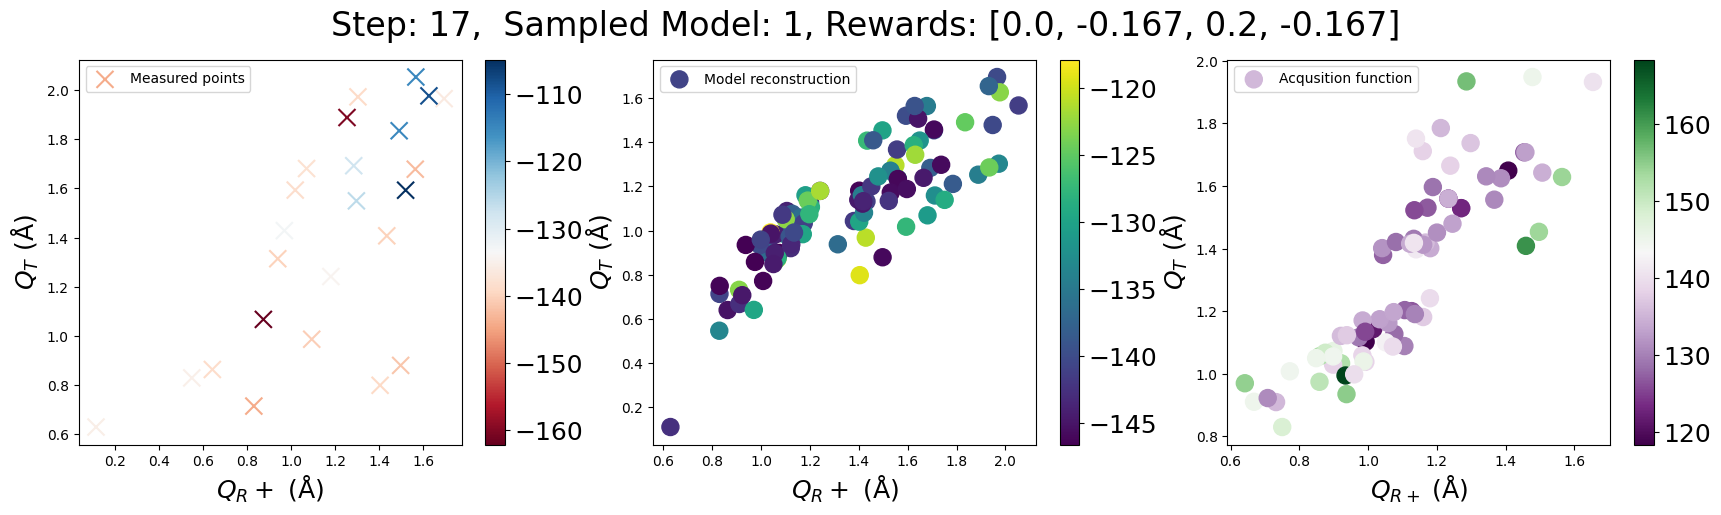

sample: 100%|██████████| 2000/2000 [00:07<00:00, 250.46it/s, 7 steps of size 4.31e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.13      0.42      1.07      0.47      1.73   1183.86      1.00
         a1    -53.80      1.05    -53.83    -55.59    -52.19   1380.64      1.00
         a2    -53.72      0.97    -53.75    -55.43    -52.24    977.61      1.00
         a3      1.00      0.50      1.03      0.24      1.87    945.50      1.00
      alpha    -14.68      0.98    -14.70    -16.19    -12.98   1155.28      1.00
k_length[0]      0.67      0.26      0.62      0.31      1.06    564.20      1.00
k_length[1]      0.82      0.27      0.77      0.40      1.23    622.79      1.00
  k_length1      0.67      0.26      0.62      0.31      1.06    564.20      1.00
  k_length2      0.82      0.27      0.77      0.40      1.23    622.79      1.00
    k_scale   5917.71   2280.47   5457.63   2913.44   9371.17    767.93      1.00
      noise     99.24     34.50     94.12     45.65    148.35    831.34      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:07<00:00, 267.97it/s, 7 steps of size 4.58e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.12      1.61      2.81      0.83      5.36    991.12      1.00
         a1    -53.80      1.05    -53.78    -55.42    -52.06   1313.10      1.00
         a2    -53.64      0.97    -53.64    -55.08    -52.01   1228.45      1.00
         a3      0.08      0.49      0.09     -0.75      0.87   1257.23      1.00
k_length[0]      0.67      0.26      0.63      0.32      1.07    523.69      1.00
k_length[1]      0.79      0.26      0.73      0.43      1.22    537.02      1.00
  k_length1      0.67      0.26      0.63      0.32      1.07    523.69      1.00
  k_length2      0.79      0.26      0.73      0.43      1.22    537.02      1.00
    k_scale   4158.21   1497.56   3875.44   2045.51   6227.76    651.38      1.00
      noise    100.24     36.20     95.38     48.50    150.25    618.38      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 8  reward (avg) 0.125
model 2:  counts 6  reward (

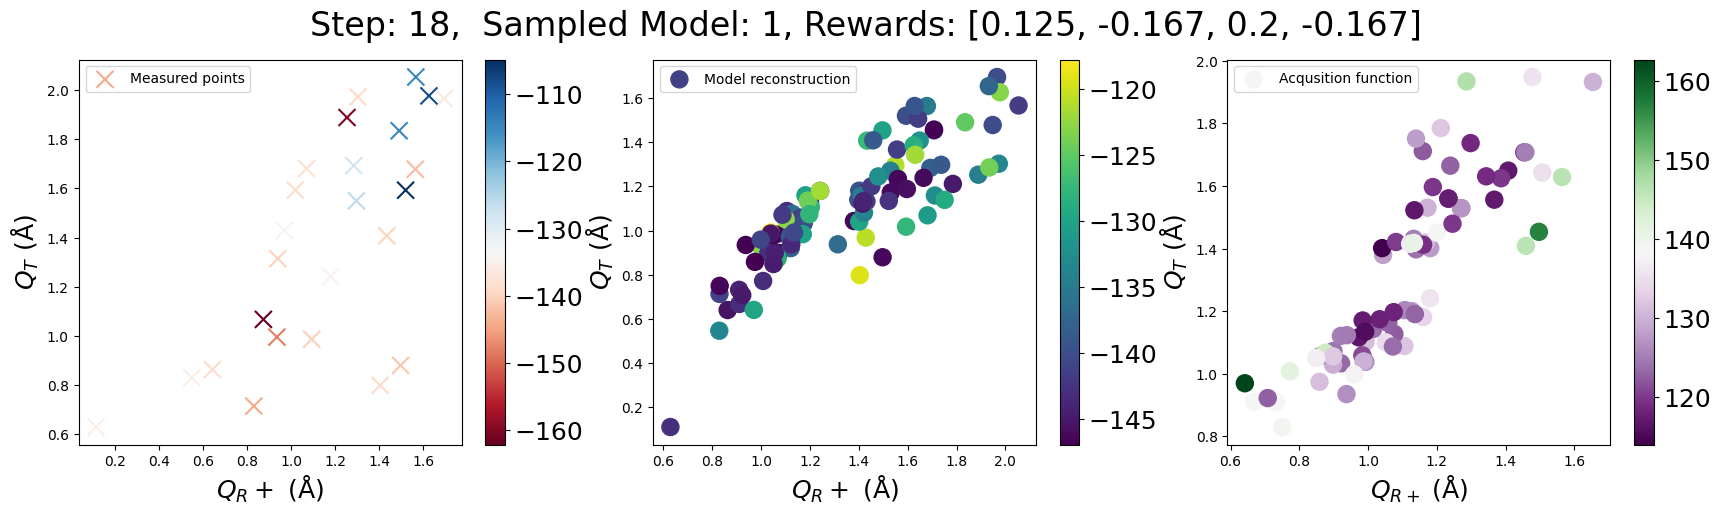

sample: 100%|██████████| 2000/2000 [00:07<00:00, 266.54it/s, 7 steps of size 5.46e-01. acc. prob=0.88]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.12      0.41      1.05      0.55      1.71   1478.30      1.00
         a1    -53.84      0.96    -53.84    -55.26    -52.23   1600.70      1.00
         a2    -53.72      0.94    -53.74    -55.11    -52.03   1668.97      1.00
         a3      1.01      0.49      1.02      0.10      1.71   1455.51      1.00
      alpha    -14.72      0.99    -14.74    -16.27    -13.04   1666.03      1.00
k_length[0]      0.66      0.24      0.60      0.31      1.01    684.10      1.00
k_length[1]      0.81      0.26      0.76      0.42      1.21    781.83      1.00
  k_length1      0.66      0.24      0.60      0.31      1.01    684.10      1.00
  k_length2      0.81      0.26      0.76      0.42      1.21    781.83      1.00
    k_scale   5838.97   2206.07   5451.37   2674.44   8853.57    841.69      1.00
      noise     94.77     31.77     89.76     45.56    141.43    924.69      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:06<00:00, 301.71it/s, 7 steps of size 4.76e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.12      1.64      2.77      0.83      5.29   1058.28      1.00
         a1    -53.77      1.07    -53.78    -55.49    -52.12   1703.04      1.00
         a2    -53.62      0.98    -53.60    -55.26    -52.09   1205.11      1.00
         a3      0.08      0.48      0.09     -0.69      0.90   1252.14      1.00
k_length[0]      0.66      0.25      0.62      0.32      1.04    552.10      1.00
k_length[1]      0.79      0.26      0.74      0.43      1.23    585.54      1.00
  k_length1      0.66      0.25      0.62      0.32      1.04    552.10      1.00
  k_length2      0.79      0.26      0.74      0.43      1.23    585.54      1.00
    k_scale   4157.18   1483.44   3858.93   2078.44   6295.07    693.55      1.00
      noise     96.31     34.13     90.67     47.42    145.22    702.60      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 8  reward (avg) 0.125
model 2:  counts 6  reward (

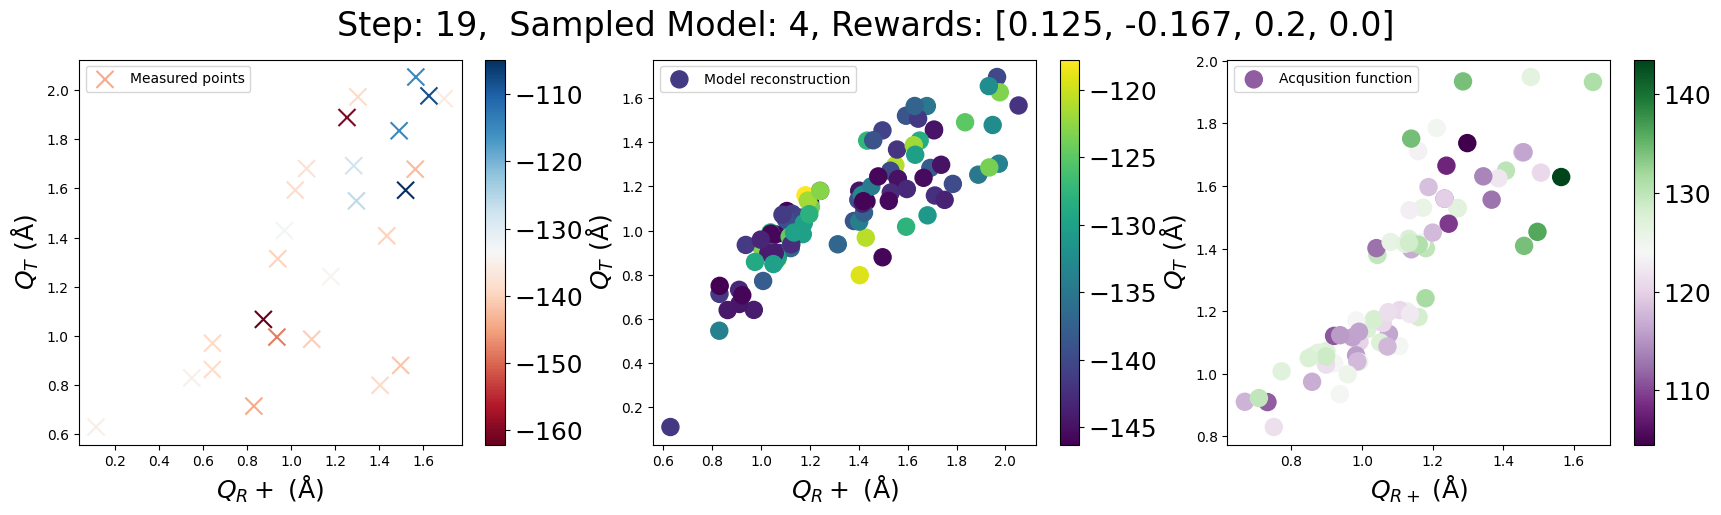

sample: 100%|██████████| 2000/2000 [00:06<00:00, 286.52it/s, 7 steps of size 4.80e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.14      0.43      1.07      0.53      1.79   1186.78      1.00
         a1    -53.81      1.04    -53.82    -55.22    -51.82   1448.89      1.00
         a2    -53.74      0.98    -53.74    -55.25    -52.01   1414.16      1.00
         a3      1.00      0.50      1.04      0.13      1.75   1146.65      1.00
      alpha    -14.72      0.97    -14.73    -16.26    -13.09   1559.38      1.00
k_length[0]      0.65      0.25      0.59      0.31      1.00    624.10      1.00
k_length[1]      0.80      0.26      0.75      0.38      1.18    678.80      1.00
  k_length1      0.65      0.25      0.59      0.31      1.00    624.10      1.00
  k_length2      0.80      0.26      0.75      0.38      1.18    678.80      1.00
    k_scale   5905.74   2255.29   5399.96   2627.18   8941.00    854.01      1.00
      noise     90.43     31.24     85.57     40.54    133.63    870.98      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:07<00:00, 259.97it/s, 7 steps of size 4.90e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.11      1.51      2.81      0.86      5.20   1159.80      1.00
         a1    -53.78      1.05    -53.82    -55.56    -52.19   1770.26      1.00
         a2    -53.63      0.97    -53.61    -55.09    -51.98   1134.00      1.00
         a3      0.07      0.49      0.08     -0.60      1.02   1297.71      1.00
k_length[0]      0.64      0.24      0.59      0.32      1.02    505.34      1.00
k_length[1]      0.77      0.26      0.71      0.40      1.16    561.66      1.00
  k_length1      0.64      0.24      0.59      0.32      1.02    505.34      1.00
  k_length2      0.77      0.26      0.71      0.40      1.16    561.66      1.00
    k_scale   4145.65   1546.40   3860.88   1909.30   6088.52    621.65      1.00
      noise     91.70     32.37     86.57     43.09    133.86    780.57      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 8  reward (avg) 0.125
model 2:  counts 6  reward (

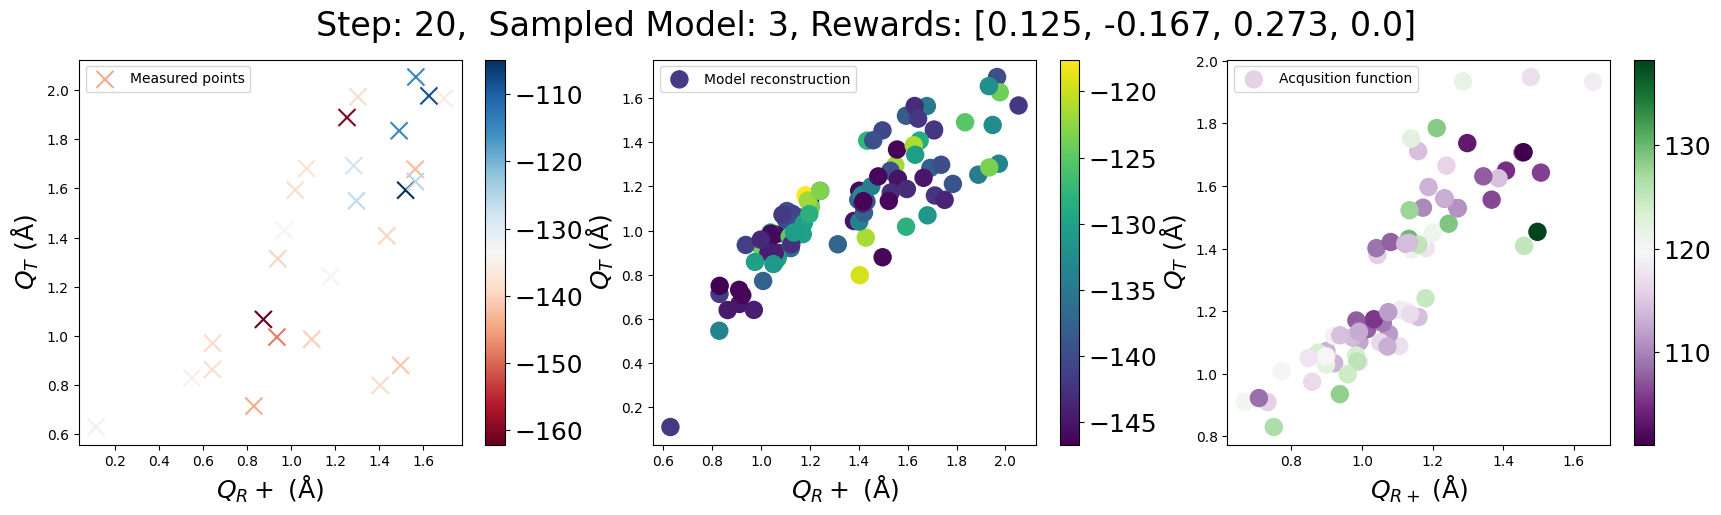

sample: 100%|██████████| 2000/2000 [00:08<00:00, 240.67it/s, 7 steps of size 4.28e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.15      0.43      1.09      0.51      1.80   1166.09      1.00
         a1    -53.79      1.05    -53.81    -55.56    -52.19   1136.56      1.00
         a2    -53.76      0.97    -53.78    -55.43    -52.21    986.88      1.00
         a3      1.00      0.50      1.02      0.22      1.83    975.02      1.00
      alpha    -14.66      0.98    -14.68    -16.08    -12.93   1235.03      1.00
k_length[0]      0.61      0.22      0.54      0.32      0.93    385.11      1.00
k_length[1]      0.74      0.21      0.70      0.42      1.08    502.12      1.00
  k_length1      0.61      0.22      0.54      0.32      0.93    385.11      1.00
  k_length2      0.74      0.21      0.70      0.42      1.08    502.12      1.00
    k_scale   5673.39   2125.09   5172.63   2805.03   8971.69    634.49      1.00
      noise     86.80     29.53     81.22     39.94    128.97    641.12      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:07<00:00, 260.92it/s, 3 steps of size 5.55e-01. acc. prob=0.88]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.06      1.48      2.74      0.99      5.11   1025.03      1.00
         a1    -53.84      1.03    -53.84    -55.72    -52.34   2053.84      1.00
         a2    -53.65      0.99    -53.62    -55.11    -51.93   1207.94      1.00
         a3      0.08      0.48      0.08     -0.66      0.93   1187.18      1.00
k_length[0]      0.59      0.23      0.53      0.29      0.94    658.85      1.00
k_length[1]      0.70      0.21      0.66      0.41      1.03    658.42      1.00
  k_length1      0.59      0.23      0.53      0.29      0.94    658.85      1.00
  k_length2      0.70      0.21      0.66      0.41      1.03    658.42      1.00
    k_scale   3920.98   1357.77   3712.18   1962.76   5729.41    636.08      1.00
      noise     88.26     30.38     82.74     42.01    131.13    940.96      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 8  reward (avg) 0.125
model 2:  counts 6  reward (

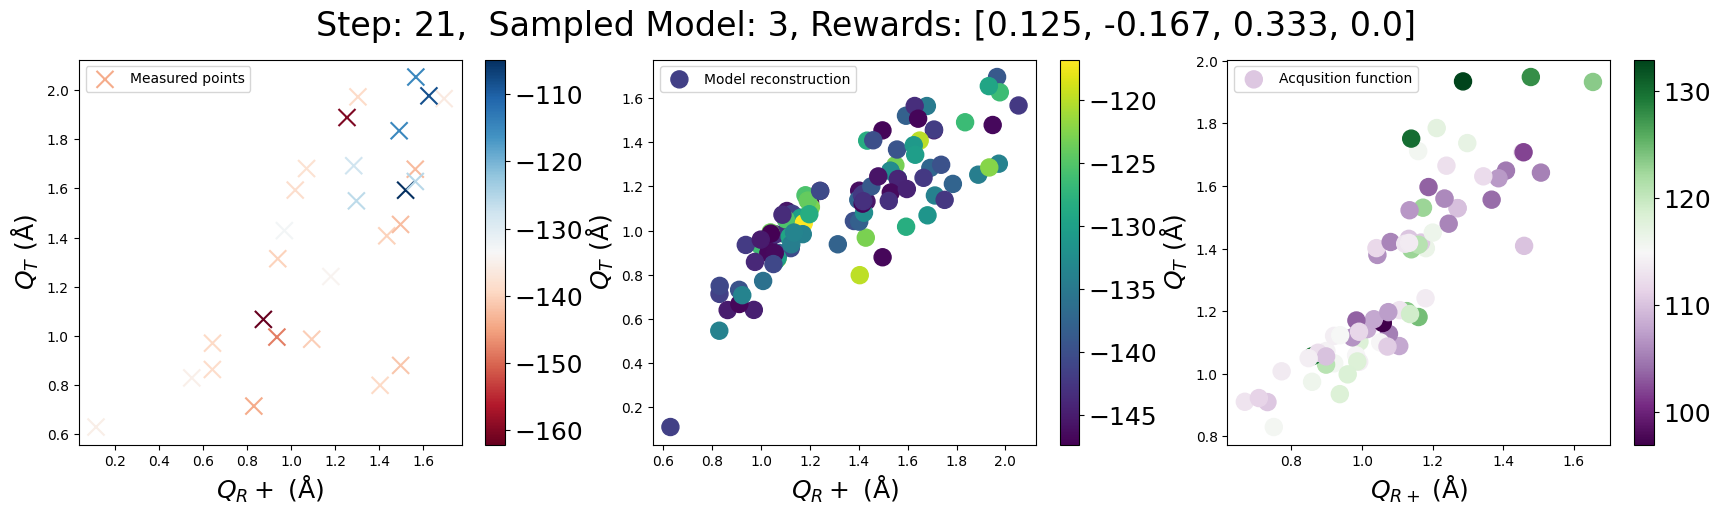

sample: 100%|██████████| 2000/2000 [00:07<00:00, 269.79it/s, 7 steps of size 4.73e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.14      0.44      1.06      0.50      1.78   1178.08      1.00
         a1    -53.80      1.06    -53.82    -55.61    -52.19   1313.25      1.00
         a2    -53.74      0.94    -53.74    -55.21    -52.07   1231.47      1.00
         a3      1.01      0.49      1.04      0.19      1.79   1223.01      1.00
      alpha    -14.69      0.98    -14.71    -16.33    -13.06   1644.65      1.00
k_length[0]      0.60      0.21      0.54      0.29      0.89    473.78      1.00
k_length[1]      0.73      0.20      0.70      0.42      1.05    509.48      1.00
  k_length1      0.60      0.21      0.54      0.29      0.89    473.78      1.00
  k_length2      0.73      0.20      0.70      0.42      1.05    509.48      1.00
    k_scale   5658.24   2142.99   5207.62   2537.79   8513.01    782.41      1.00
      noise     84.36     28.60     79.21     42.33    125.88    752.30      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:07<00:00, 284.55it/s, 7 steps of size 5.33e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.03      1.49      2.76      0.98      5.09   1100.90      1.00
         a1    -53.80      1.07    -53.82    -55.44    -51.96   2231.07      1.00
         a2    -53.65      0.97    -53.65    -55.24    -52.10   1195.35      1.00
         a3      0.07      0.49      0.08     -0.69      0.88   1420.67      1.00
k_length[0]      0.58      0.21      0.52      0.32      0.89    553.98      1.00
k_length[1]      0.69      0.21      0.66      0.39      1.01    571.28      1.01
  k_length1      0.58      0.21      0.52      0.32      0.89    553.98      1.00
  k_length2      0.69      0.21      0.66      0.39      1.01    571.28      1.01
    k_scale   3913.12   1386.19   3674.09   1869.00   5507.66    614.90      1.00
      noise     85.01     28.87     79.79     41.66    126.77    881.63      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 8  reward (avg) 0.125
model 2:  counts 6  reward (

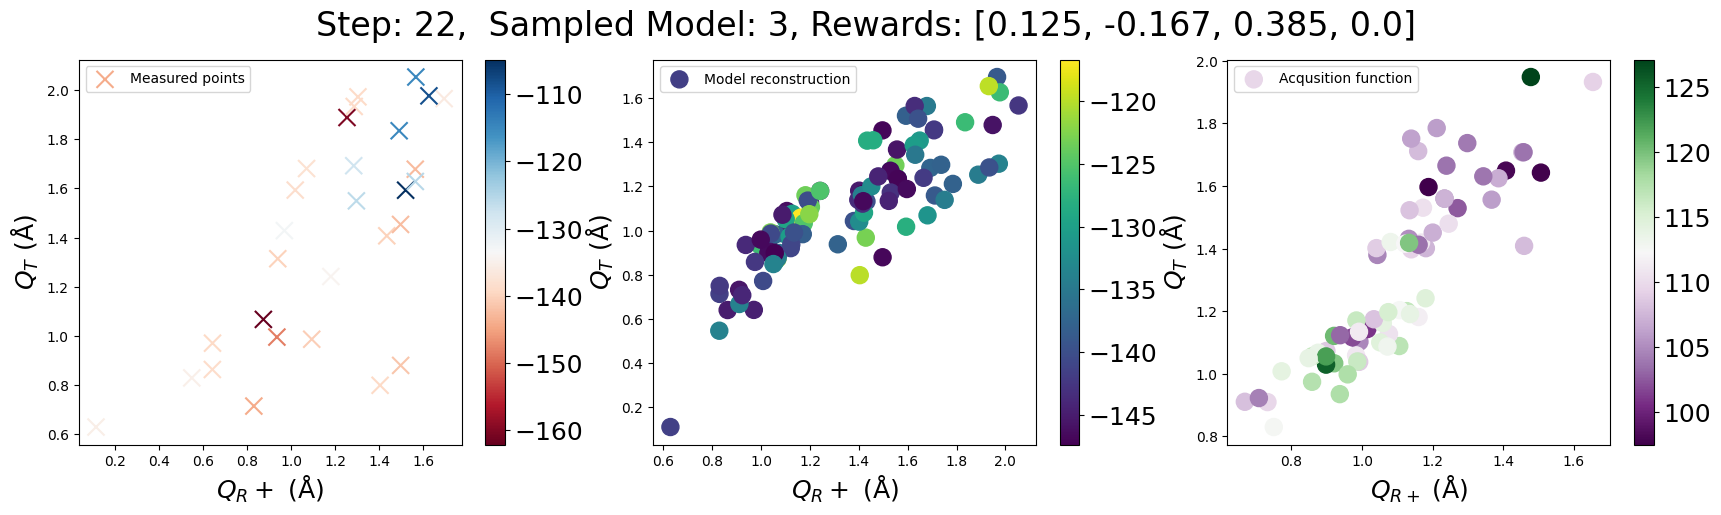

sample: 100%|██████████| 2000/2000 [00:07<00:00, 257.11it/s, 7 steps of size 4.94e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.12      0.42      1.04      0.47      1.72   1331.50      1.00
         a1    -53.80      1.04    -53.80    -55.34    -51.92   1453.02      1.00
         a2    -53.71      0.95    -53.71    -55.17    -52.04   1504.33      1.00
         a3      1.00      0.48      1.02      0.17      1.75   1141.63      1.00
      alpha    -14.68      0.95    -14.71    -16.15    -13.01   1980.85      1.00
k_length[0]      0.85      0.26      0.82      0.39      1.24    982.78      1.00
k_length[1]      0.94      0.28      0.89      0.47      1.35   1052.01      1.00
  k_length1      0.85      0.26      0.82      0.39      1.24    982.78      1.00
  k_length2      0.94      0.28      0.89      0.47      1.35   1052.01      1.00
    k_scale   6359.67   2509.44   5853.14   2528.59   9771.33   1021.17      1.00
      noise    124.69     34.28    119.37     69.96    171.66   1440.86      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:08<00:00, 244.38it/s, 7 steps of size 4.32e-01. acc. prob=0.95]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.11      1.65      2.73      0.84      5.34    994.56      1.00
         a1    -53.80      1.03    -53.82    -55.43    -52.07   1135.59      1.00
         a2    -53.64      0.99    -53.60    -55.29    -52.05   1206.74      1.00
         a3      0.08      0.50      0.08     -0.71      0.89   1049.72      1.00
k_length[0]      0.83      0.26      0.80      0.41      1.21    573.30      1.00
k_length[1]      0.89      0.26      0.86      0.50      1.27    606.28      1.00
  k_length1      0.83      0.26      0.80      0.41      1.21    573.30      1.00
  k_length2      0.89      0.26      0.86      0.50      1.27    606.28      1.00
    k_scale   4456.45   1776.18   4095.82   2010.04   6516.03    531.38      1.00
      noise    126.63     34.14    122.60     74.37    176.54    700.48      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 8  reward (avg) 0.125
model 2:  counts 6  reward (

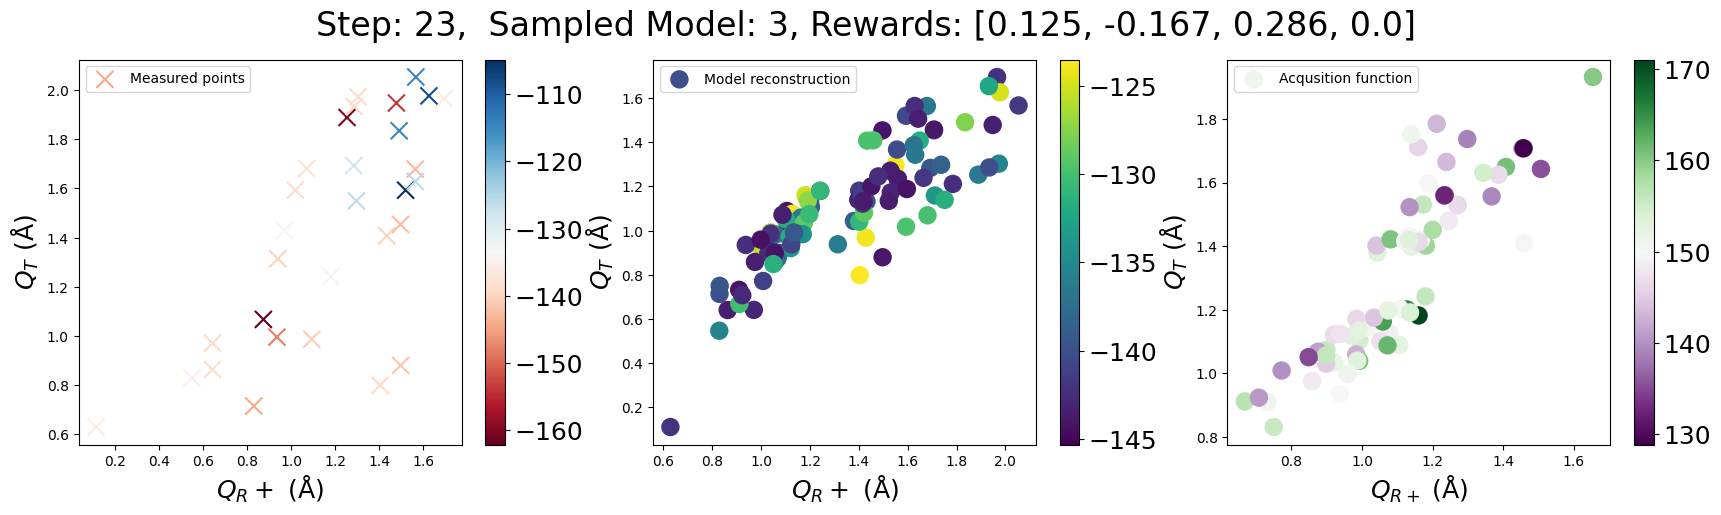

sample: 100%|██████████| 2000/2000 [00:08<00:00, 249.91it/s, 7 steps of size 5.10e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.12      0.43      1.04      0.50      1.72   1229.76      1.00
         a1    -53.80      1.02    -53.81    -55.29    -52.07   1290.42      1.00
         a2    -53.73      0.93    -53.73    -55.12    -52.09   1510.81      1.00
         a3      1.00      0.48      1.01      0.13      1.72   1445.91      1.00
      alpha    -14.71      0.95    -14.74    -16.38    -13.29   2014.08      1.00
k_length[0]      0.83      0.25      0.79      0.39      1.16   1081.77      1.00
k_length[1]      0.91      0.26      0.87      0.50      1.32   1130.80      1.00
  k_length1      0.83      0.25      0.79      0.39      1.16   1081.77      1.00
  k_length2      0.91      0.26      0.87      0.50      1.32   1130.80      1.00
    k_scale   6270.90   2457.22   5799.51   2687.06   9838.35   1052.63      1.00
      noise    132.89     36.00    127.39     77.51    183.60   1462.09      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:07<00:00, 283.47it/s, 7 steps of size 5.42e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.15      1.60      2.80      0.93      5.46   1272.82      1.00
         a1    -53.75      1.07    -53.72    -55.46    -51.95   2284.53      1.00
         a2    -53.65      0.98    -53.66    -55.07    -51.88   1685.08      1.00
         a3      0.09      0.47      0.10     -0.59      0.94   1114.67      1.00
k_length[0]      0.80      0.23      0.77      0.45      1.17    887.06      1.00
k_length[1]      0.85      0.25      0.83      0.44      1.23    984.74      1.00
  k_length1      0.80      0.23      0.77      0.45      1.17    887.06      1.00
  k_length2      0.85      0.25      0.83      0.44      1.23    984.74      1.00
    k_scale   4250.88   1555.73   3987.87   2152.20   6348.04    804.96      1.00
      noise    133.01     36.62    127.10     77.48    188.81   1400.94      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 8  reward (avg) 0.125
model 2:  counts 6  reward (

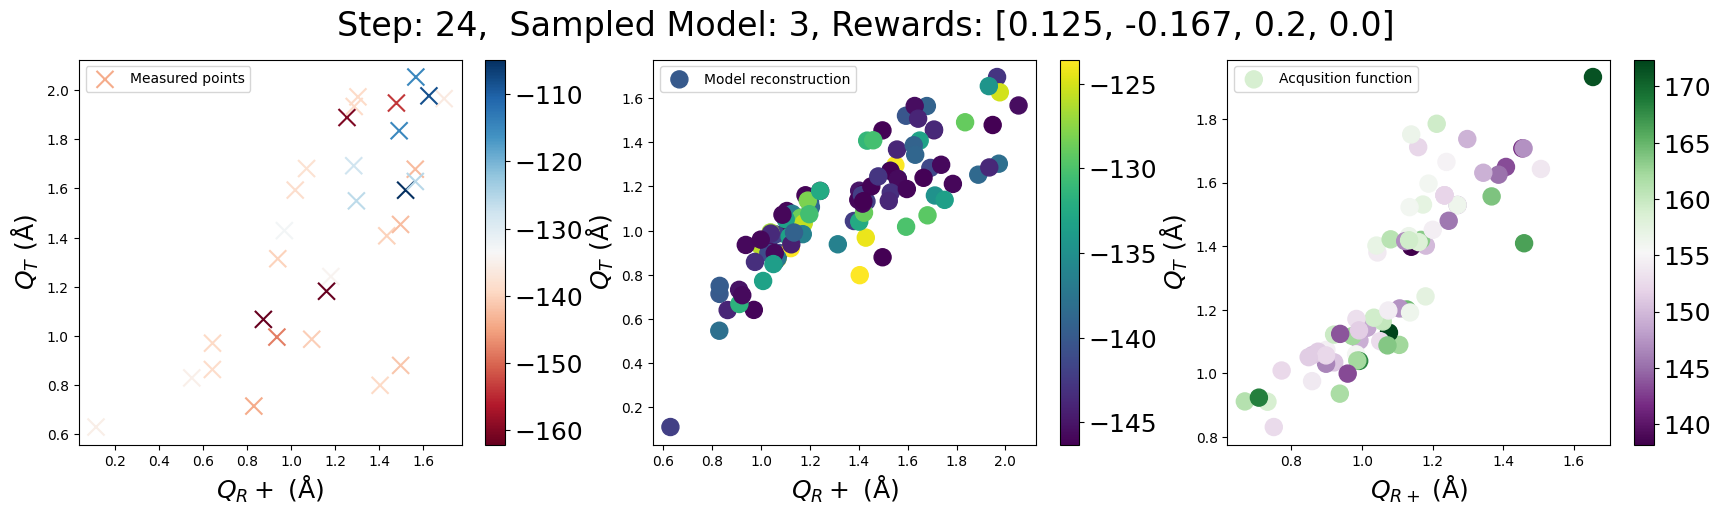

sample: 100%|██████████| 2000/2000 [00:15<00:00, 127.75it/s, 7 steps of size 4.92e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.12      0.44      1.05      0.49      1.75   1214.47      1.00
         a1    -53.79      1.04    -53.81    -55.47    -52.11   1458.96      1.00
         a2    -53.73      0.93    -53.73    -55.06    -51.96   1545.43      1.00
         a3      0.99      0.48      1.02      0.20      1.76   1254.97      1.00
      alpha    -14.69      0.95    -14.74    -16.40    -13.24   1899.46      1.00
k_length[0]      0.84      0.25      0.81      0.46      1.25   1084.39      1.00
k_length[1]      0.91      0.25      0.87      0.52      1.33   1102.05      1.00
  k_length1      0.84      0.25      0.81      0.46      1.25   1084.39      1.00
  k_length2      0.91      0.25      0.87      0.52      1.33   1102.05      1.00
    k_scale   6304.52   2447.21   5775.76   2808.94  10050.77   1083.76      1.00
      noise    131.45     35.01    126.47     77.90    181.59   1467.86      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:12<00:00, 155.99it/s, 7 steps of size 5.73e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.14      1.62      2.79      1.05      5.45    756.01      1.00
         a1    -53.72      1.05    -53.74    -55.49    -51.94   1847.34      1.00
         a2    -53.67      0.95    -53.67    -55.19    -52.06   1473.03      1.00
         a3      0.09      0.48      0.11     -0.60      0.98   1651.37      1.00
k_length[0]      0.82      0.24      0.79      0.46      1.20   1036.22      1.00
k_length[1]      0.87      0.25      0.84      0.51      1.28    905.81      1.00
  k_length1      0.82      0.24      0.79      0.46      1.20   1036.22      1.00
  k_length2      0.87      0.25      0.84      0.51      1.28    905.81      1.00
    k_scale   4282.80   1634.17   3970.20   2083.23   6408.57    901.17      1.00
      noise    131.63     35.84    126.66     79.66    189.47   1198.80      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 8  reward (avg) 0.125
model 2:  counts 6  reward (

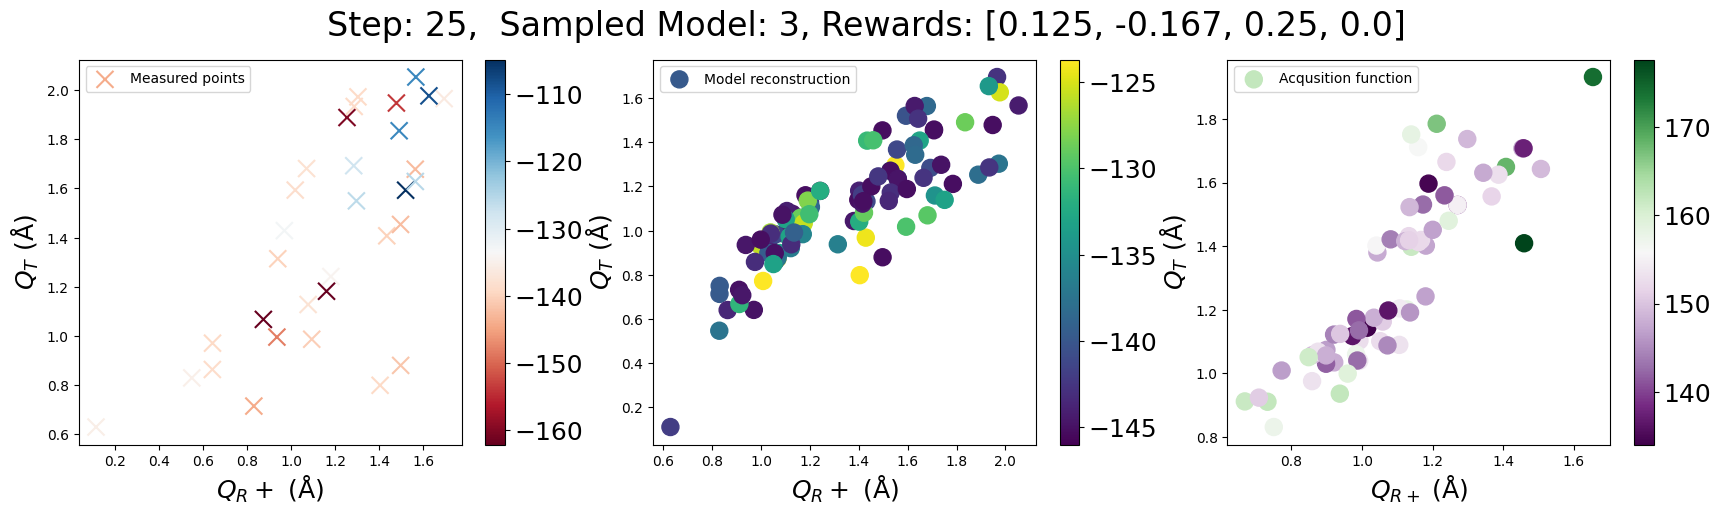

sample: 100%|██████████| 2000/2000 [00:15<00:00, 131.41it/s, 7 steps of size 5.52e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.10      0.40      1.04      0.47      1.64   1326.31      1.00
         a1    -53.79      1.02    -53.78    -55.37    -52.13   1578.71      1.00
         a2    -53.72      0.96    -53.71    -55.41    -52.20   1418.54      1.00
         a3      1.01      0.47      1.02      0.22      1.78   1570.23      1.00
      alpha    -14.71      0.94    -14.73    -16.25    -13.25   2255.12      1.00
k_length[0]      0.87      0.27      0.84      0.50      1.30   1185.51      1.00
k_length[1]      0.96      0.26      0.93      0.47      1.33   1260.60      1.00
  k_length1      0.87      0.27      0.84      0.50      1.30   1185.51      1.00
  k_length2      0.96      0.26      0.93      0.47      1.33   1260.60      1.00
    k_scale   6408.66   2561.25   5895.95   2813.19   9990.23   1136.23      1.00
      noise    133.50     35.69    127.37     77.07    181.58   1423.88      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:13<00:00, 142.88it/s, 7 steps of size 5.94e-01. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.12      1.58      2.74      0.88      5.26    893.06      1.00
         a1    -53.76      0.99    -53.77    -55.53    -52.26   1907.88      1.00
         a2    -53.66      0.98    -53.70    -55.32    -52.03   1167.35      1.00
         a3      0.11      0.47      0.12     -0.61      0.95   1520.65      1.00
k_length[0]      0.84      0.24      0.81      0.44      1.19   1006.15      1.00
k_length[1]      0.91      0.26      0.89      0.52      1.31    937.99      1.00
  k_length1      0.84      0.24      0.81      0.44      1.19   1006.15      1.00
  k_length2      0.91      0.26      0.89      0.52      1.31    937.99      1.00
    k_scale   4339.99   1615.53   4083.25   2024.14   6327.62    943.86      1.00
      noise    133.51     34.40    127.32     82.08    189.02   1098.10      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 8  reward (avg) 0.125
model 2:  counts 6  reward (

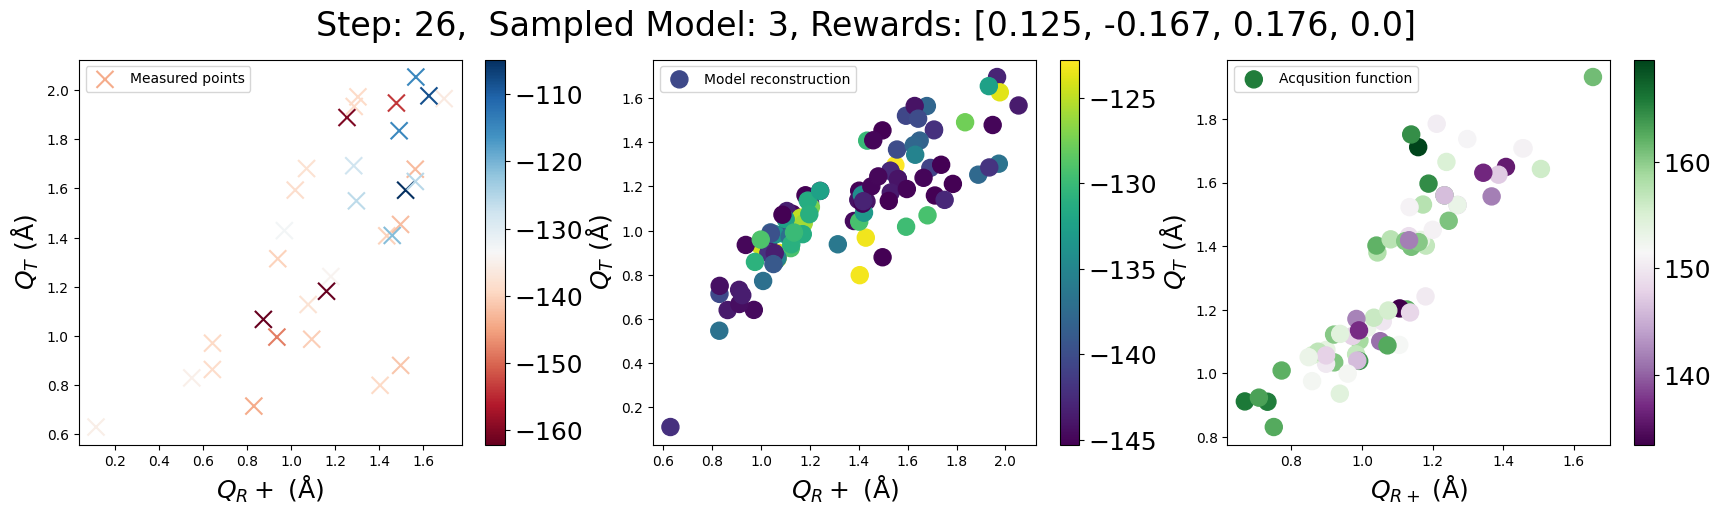

sample: 100%|██████████| 2000/2000 [00:14<00:00, 137.62it/s, 7 steps of size 5.32e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.11      0.42      1.04      0.46      1.67   1411.35      1.00
         a1    -53.80      1.01    -53.82    -55.46    -52.26   1404.09      1.00
         a2    -53.72      0.94    -53.72    -55.39    -52.25   1680.28      1.00
         a3      1.00      0.50      1.00      0.10      1.74   1524.97      1.00
      alpha    -14.71      0.94    -14.73    -16.40    -13.34   2029.50      1.00
k_length[0]      0.82      0.24      0.78      0.44      1.16   1264.45      1.00
k_length[1]      0.96      0.27      0.94      0.54      1.39   1182.91      1.00
  k_length1      0.82      0.24      0.78      0.44      1.16   1264.45      1.00
  k_length2      0.96      0.27      0.94      0.54      1.39   1182.91      1.00
    k_scale   6327.75   2493.57   5804.53   2594.96  10071.00   1113.08      1.00
      noise    142.58     35.83    137.64     90.13    196.57   1572.18      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:14<00:00, 136.55it/s, 7 steps of size 5.04e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.12      1.56      2.81      0.89      5.39   1130.60      1.00
         a1    -53.78      1.05    -53.77    -55.51    -52.11   1899.47      1.00
         a2    -53.65      0.97    -53.66    -55.19    -52.08   1408.58      1.00
         a3      0.08      0.46      0.09     -0.67      0.84   1569.45      1.00
k_length[0]      0.79      0.23      0.76      0.46      1.17    781.83      1.00
k_length[1]      0.91      0.25      0.88      0.52      1.29    839.03      1.00
  k_length1      0.79      0.23      0.76      0.46      1.17    781.83      1.00
  k_length2      0.91      0.25      0.88      0.52      1.29    839.03      1.00
    k_scale   4385.38   1671.27   4059.88   2085.74   6641.29    680.60      1.00
      noise    142.99     35.89    139.20     86.05    194.01   1129.79      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 8  reward (avg) 0.125
model 2:  counts 7  reward (

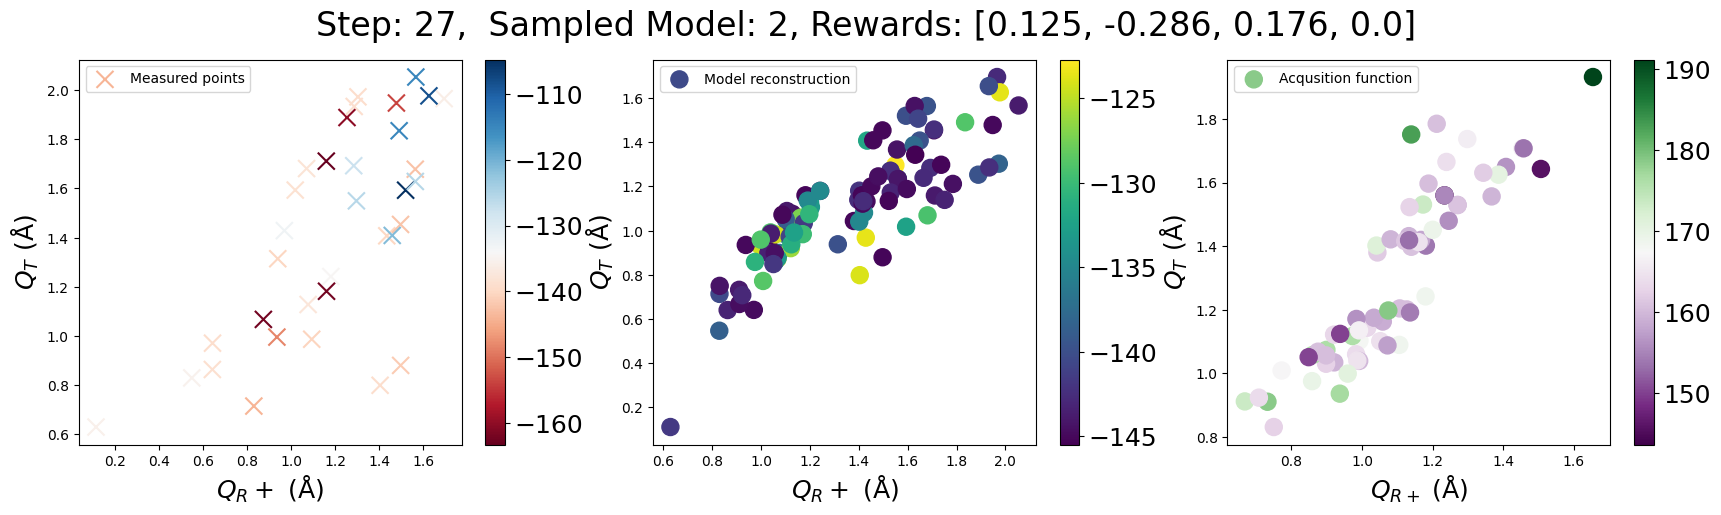

sample: 100%|██████████| 2000/2000 [00:15<00:00, 131.43it/s, 7 steps of size 4.74e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.12      0.42      1.04      0.48      1.71   1241.35      1.00
         a1    -53.79      1.05    -53.78    -55.38    -52.00   1452.61      1.00
         a2    -53.73      0.93    -53.73    -55.11    -52.02   1202.53      1.00
         a3      1.00      0.48      1.02      0.17      1.74   1139.75      1.00
      alpha    -14.69      0.98    -14.73    -16.09    -12.84   1590.03      1.00
k_length[0]      0.82      0.24      0.79      0.41      1.17   1030.81      1.00
k_length[1]      0.97      0.26      0.93      0.55      1.39   1026.77      1.00
  k_length1      0.82      0.24      0.79      0.41      1.17   1030.81      1.00
  k_length2      0.97      0.26      0.93      0.55      1.39   1026.77      1.00
    k_scale   6333.89   2460.53   5846.37   2930.46  10275.02    977.62      1.00
      noise    141.21     35.43    136.35     86.63    193.00   1132.88      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:15<00:00, 133.08it/s, 7 steps of size 6.19e-01. acc. prob=0.88]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.15      1.64      2.75      0.86      5.40    865.18      1.00
         a1    -53.76      1.03    -53.75    -55.43    -52.14   1985.71      1.00
         a2    -53.65      0.99    -53.66    -55.00    -51.60   1561.08      1.00
         a3      0.09      0.50      0.09     -0.70      0.93   1220.12      1.00
k_length[0]      0.80      0.23      0.77      0.46      1.16    826.04      1.00
k_length[1]      0.93      0.27      0.90      0.52      1.32    933.27      1.00
  k_length1      0.80      0.23      0.77      0.46      1.16    826.04      1.00
  k_length2      0.93      0.27      0.90      0.52      1.32    933.27      1.00
    k_scale   4328.15   1665.40   4059.90   2127.61   6366.83    802.90      1.00
      noise    142.58     36.97    136.84     88.80    204.29   1117.20      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 8  reward (avg) 0.125
model 2:  counts 7  reward (

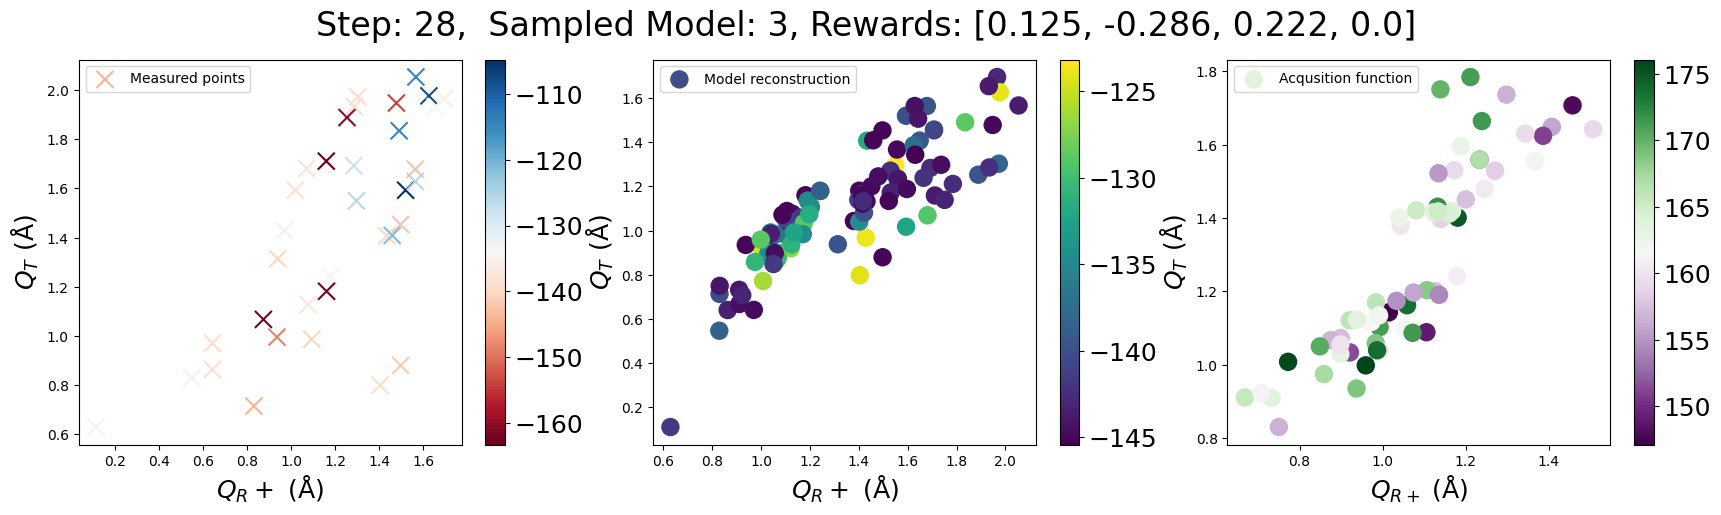

sample: 100%|██████████| 2000/2000 [00:16<00:00, 122.65it/s, 7 steps of size 4.81e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.11      0.41      1.05      0.47      1.70   1250.96      1.00
         a1    -53.78      1.04    -53.80    -55.57    -52.15   1534.33      1.00
         a2    -53.73      0.93    -53.73    -55.24    -52.14   1200.84      1.00
         a3      1.00      0.50      1.02      0.16      1.79   1108.76      1.00
      alpha    -14.68      0.99    -14.72    -16.29    -13.01   1622.91      1.00
k_length[0]      0.84      0.24      0.80      0.44      1.20   1052.80      1.00
k_length[1]      0.98      0.26      0.95      0.57      1.40   1106.35      1.00
  k_length1      0.84      0.24      0.80      0.44      1.20   1052.80      1.00
  k_length2      0.98      0.26      0.95      0.57      1.40   1106.35      1.00
    k_scale   6358.01   2522.70   5885.65   2706.38  10240.70   1045.82      1.00
      noise    141.26     34.53    135.75     83.60    188.51   1128.06      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:15<00:00, 129.52it/s, 7 steps of size 6.11e-01. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.16      1.65      2.80      0.79      5.32    852.27      1.00
         a1    -53.75      1.01    -53.76    -55.51    -52.20   1969.13      1.00
         a2    -53.63      0.97    -53.67    -55.29    -52.10   1028.08      1.00
         a3      0.09      0.47      0.09     -0.65      0.89   1737.20      1.00
k_length[0]      0.81      0.23      0.78      0.45      1.14    897.07      1.00
k_length[1]      0.94      0.26      0.91      0.55      1.36   1060.97      1.00
  k_length1      0.81      0.23      0.78      0.45      1.14    897.07      1.00
  k_length2      0.94      0.26      0.91      0.55      1.36   1060.97      1.00
    k_scale   4328.48   1677.53   3975.41   2074.49   6410.09    807.02      1.00
      noise    141.48     34.57    136.85     85.33    193.10   1486.36      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 8  reward (avg) 0.125
model 2:  counts 7  reward (

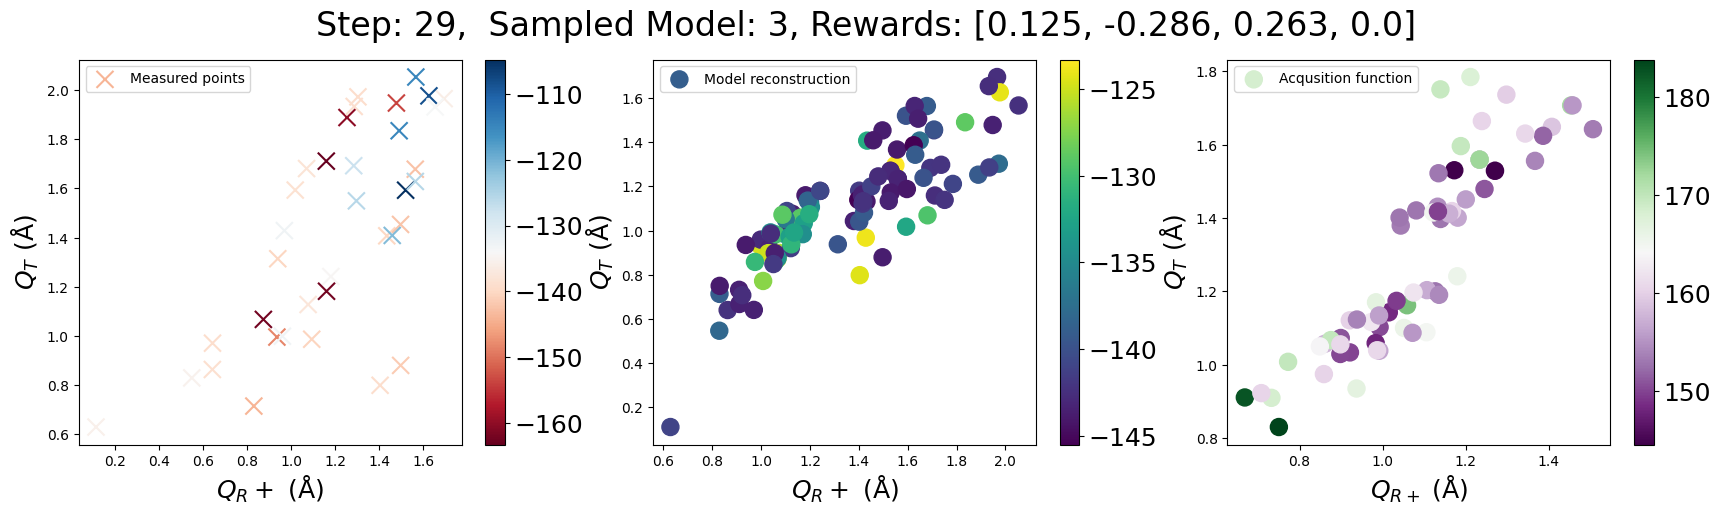

sample: 100%|██████████| 2000/2000 [00:16<00:00, 124.03it/s, 7 steps of size 5.90e-01. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.10      0.39      1.04      0.48      1.68   1250.25      1.00
         a1    -53.82      1.00    -53.82    -55.41    -52.14   1456.17      1.00
         a2    -53.70      0.98    -53.68    -55.31    -52.13   1599.11      1.00
         a3      1.02      0.48      1.01      0.15      1.71   1597.03      1.00
      alpha    -14.74      0.94    -14.74    -16.20    -13.18   2256.21      1.00
k_length[0]      0.84      0.25      0.80      0.48      1.24   1376.33      1.00
k_length[1]      0.99      0.26      0.96      0.58      1.41   1248.12      1.00
  k_length1      0.84      0.25      0.80      0.48      1.24   1376.33      1.00
  k_length2      0.99      0.26      0.96      0.58      1.41   1248.12      1.00
    k_scale   6476.67   2628.03   6001.24   2768.83  10124.82   1129.59      1.00
      noise    137.81     32.91    132.99     82.82    185.44   1465.20      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:15<00:00, 131.24it/s, 7 steps of size 5.98e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.11      1.63      2.79      0.96      5.30   1077.05      1.00
         a1    -53.74      1.03    -53.74    -55.37    -52.07   2120.87      1.00
         a2    -53.63      0.97    -53.62    -55.27    -52.09   1707.49      1.00
         a3      0.09      0.46      0.10     -0.63      0.88   1842.31      1.00
k_length[0]      0.81      0.24      0.78      0.48      1.21    810.29      1.00
k_length[1]      0.93      0.27      0.91      0.52      1.37   1070.14      1.00
  k_length1      0.81      0.24      0.78      0.48      1.21    810.29      1.00
  k_length2      0.93      0.27      0.91      0.52      1.37   1070.14      1.00
    k_scale   4357.86   1626.94   4001.19   2290.15   6756.53    740.27      1.00
      noise    138.23     33.93    133.77     84.94    191.83   1606.85      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 8  reward (avg) 0.125
model 2:  counts 7  reward (

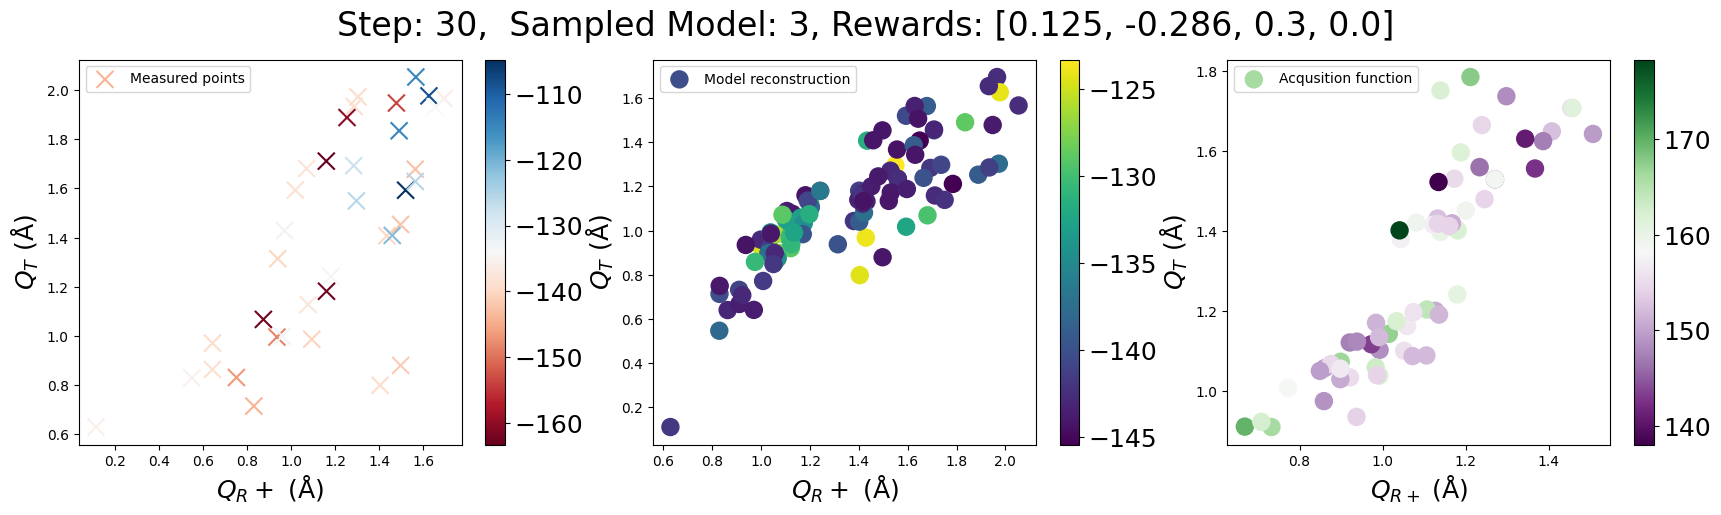

sample: 100%|██████████| 2000/2000 [00:16<00:00, 118.62it/s, 7 steps of size 5.69e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.11      0.41      1.05      0.47      1.67   1216.70      1.00
         a1    -53.80      1.01    -53.81    -55.40    -52.15   1494.05      1.00
         a2    -53.71      0.97    -53.69    -55.33    -52.17   1433.86      1.00
         a3      1.00      0.49      1.00      0.17      1.74   1607.72      1.00
      alpha    -14.71      0.95    -14.71    -16.32    -13.22   2609.92      1.00
k_length[0]      0.84      0.23      0.81      0.49      1.24   1293.85      1.00
k_length[1]      0.99      0.26      0.96      0.60      1.42   1354.46      1.00
  k_length1      0.84      0.23      0.81      0.49      1.24   1293.85      1.00
  k_length2      0.99      0.26      0.96      0.60      1.42   1354.46      1.00
    k_scale   6399.12   2497.64   5917.37   2693.11   9968.45   1093.64      1.00
      noise    136.20     32.85    131.40     84.93    183.22   1446.16      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:18<00:00, 109.29it/s, 7 steps of size 5.87e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.16      1.62      2.80      0.95      5.48    927.73      1.00
         a1    -53.78      1.06    -53.77    -55.38    -51.91   1973.49      1.00
         a2    -53.65      0.95    -53.68    -55.28    -52.13   1467.18      1.00
         a3      0.08      0.47      0.09     -0.66      0.89   1761.15      1.00
k_length[0]      0.82      0.23      0.78      0.46      1.17    905.92      1.00
k_length[1]      0.95      0.27      0.92      0.57      1.40   1064.68      1.00
  k_length1      0.82      0.23      0.78      0.46      1.17    905.92      1.00
  k_length2      0.95      0.27      0.92      0.57      1.40   1064.68      1.00
    k_scale   4379.70   1705.81   4019.81   2023.29   6490.22    692.56      1.00
      noise    136.60     32.69    132.09     85.03    187.54   1117.38      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 9  reward (avg) 0.222
model 2:  counts 7  reward (

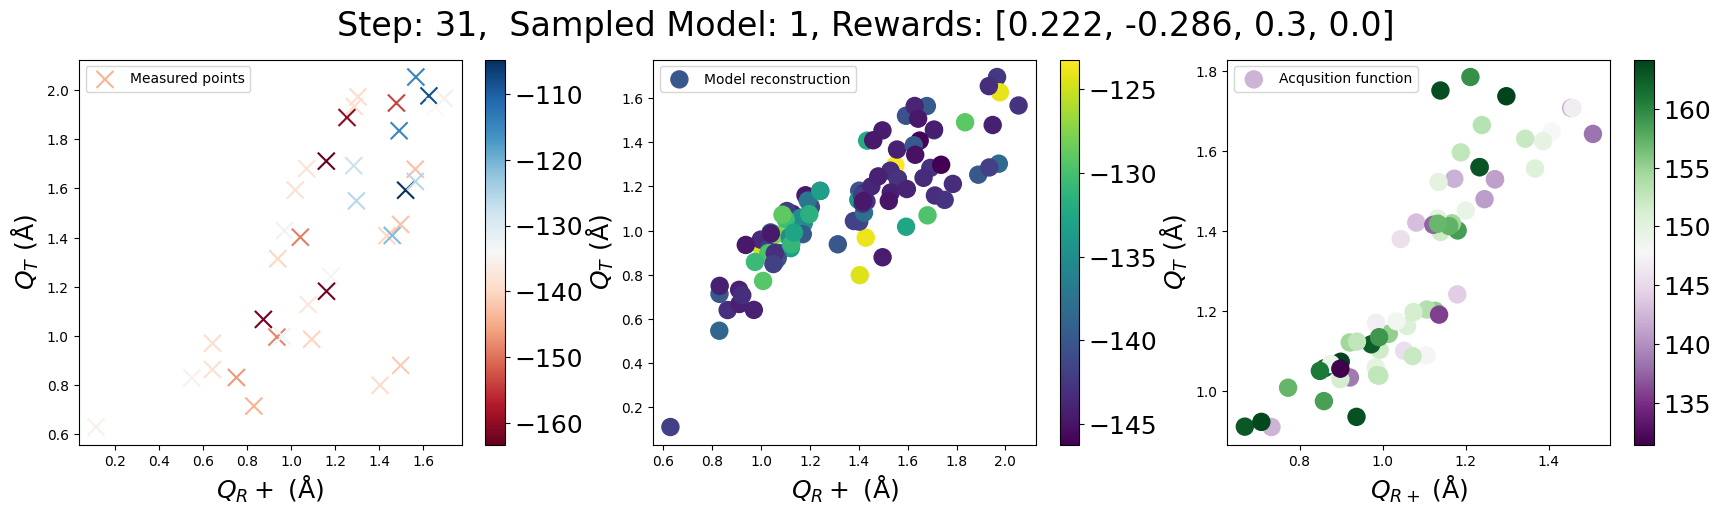

sample: 100%|██████████| 2000/2000 [00:16<00:00, 124.47it/s, 7 steps of size 5.47e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.10      0.41      1.03      0.46      1.63   1248.64      1.00
         a1    -53.80      1.02    -53.81    -55.44    -52.15   1405.22      1.00
         a2    -53.71      0.94    -53.72    -55.18    -52.11   1696.10      1.00
         a3      1.01      0.47      1.02      0.17      1.74   1554.91      1.00
      alpha    -14.72      0.96    -14.74    -16.29    -13.19   2253.90      1.00
k_length[0]      0.85      0.25      0.81      0.48      1.23   1315.49      1.00
k_length[1]      1.00      0.26      0.97      0.57      1.38   1130.04      1.00
  k_length1      0.85      0.25      0.81      0.48      1.23   1315.49      1.00
  k_length2      1.00      0.26      0.97      0.57      1.38   1130.04      1.00
    k_scale   6481.00   2549.09   5967.06   2783.53  10243.71   1071.29      1.00
      noise    132.97     31.49    128.86     80.48    175.20   1523.02      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:17<00:00, 116.64it/s, 7 steps of size 5.67e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.11      1.59      2.77      0.91      5.36   1185.37      1.00
         a1    -53.75      1.10    -53.76    -55.50    -51.94   2195.17      1.00
         a2    -53.64      0.97    -53.64    -55.25    -52.08   1377.21      1.00
         a3      0.08      0.47      0.08     -0.60      0.94   1957.49      1.00
k_length[0]      0.82      0.22      0.79      0.48      1.19   1068.64      1.00
k_length[1]      0.95      0.27      0.93      0.57      1.38   1127.74      1.00
  k_length1      0.82      0.22      0.79      0.48      1.19   1068.64      1.00
  k_length2      0.95      0.27      0.93      0.57      1.38   1127.74      1.00
    k_scale   4370.42   1654.67   4039.80   2014.78   6486.49    832.12      1.00
      noise    133.00     31.64    128.35     82.86    180.91   1315.83      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 9  reward (avg) 0.222
model 2:  counts 7  reward (

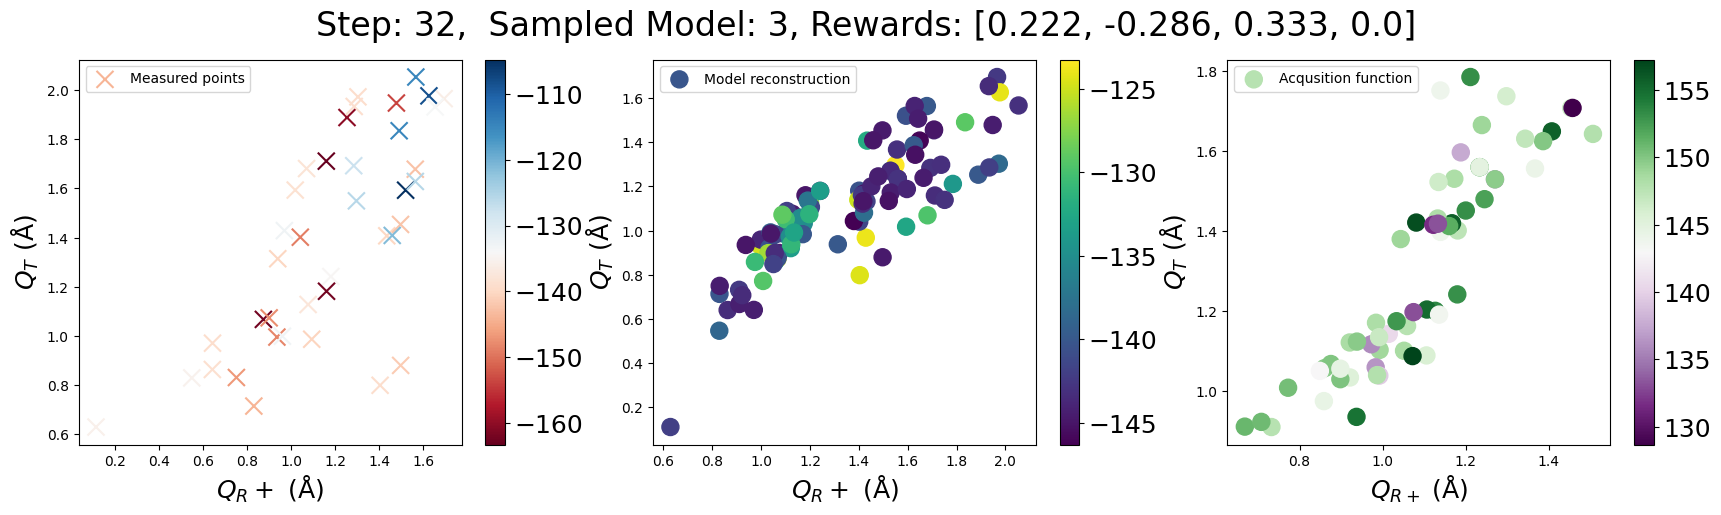

sample: 100%|██████████| 2000/2000 [00:16<00:00, 121.33it/s, 7 steps of size 5.45e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.11      0.42      1.04      0.50      1.72   1070.24      1.00
         a1    -53.80      1.01    -53.82    -55.45    -52.23   1528.30      1.00
         a2    -53.71      0.96    -53.71    -55.32    -52.16   1671.98      1.00
         a3      0.99      0.48      1.00      0.17      1.72   1488.18      1.00
      alpha    -14.70      0.96    -14.74    -16.35    -13.21   2368.84      1.00
k_length[0]      0.83      0.23      0.79      0.43      1.17   1260.79      1.00
k_length[1]      0.99      0.26      0.96      0.54      1.36   1292.10      1.00
  k_length1      0.83      0.23      0.79      0.43      1.17   1260.79      1.00
  k_length2      0.99      0.26      0.96      0.54      1.36   1292.10      1.00
    k_scale   6365.90   2486.05   5935.97   2776.98   9778.34    983.00      1.00
      noise    135.79     32.52    131.27     83.06    181.10   1409.53      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:16<00:00, 123.90it/s, 7 steps of size 5.52e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.15      1.59      2.80      0.97      5.31   1221.35      1.00
         a1    -53.76      1.09    -53.76    -55.59    -52.01   2606.38      1.00
         a2    -53.63      0.97    -53.62    -55.21    -52.06   1751.85      1.00
         a3      0.08      0.48      0.09     -0.62      0.95   1482.90      1.00
k_length[0]      0.80      0.22      0.76      0.45      1.15    995.31      1.00
k_length[1]      0.93      0.25      0.91      0.56      1.33   1093.13      1.00
  k_length1      0.80      0.22      0.76      0.45      1.15    995.31      1.00
  k_length2      0.93      0.25      0.91      0.56      1.33   1093.13      1.00
    k_scale   4319.56   1607.01   3984.89   2051.18   6267.94    829.59      1.00
      noise    135.77     32.13    130.78     87.74    187.58   1388.41      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 9  reward (avg) 0.222
model 2:  counts 7  reward (

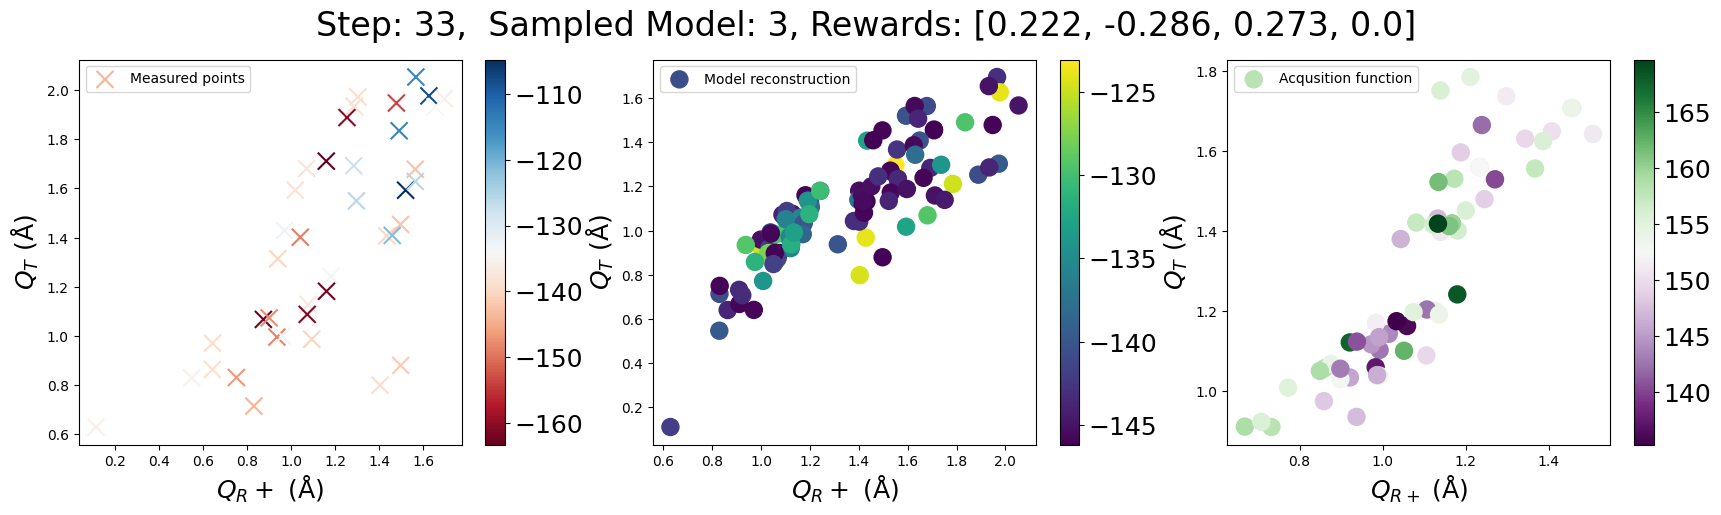

sample: 100%|██████████| 2000/2000 [00:19<00:00, 103.07it/s, 7 steps of size 5.53e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.11      0.42      1.05      0.45      1.68   1155.79      1.00
         a1    -53.82      1.02    -53.81    -55.44    -52.13   1446.50      1.00
         a2    -53.71      0.94    -53.71    -55.28    -52.20   1658.94      1.00
         a3      1.00      0.48      0.99      0.20      1.72   1535.79      1.00
      alpha    -14.71      0.94    -14.73    -16.24    -13.20   2056.34      1.00
k_length[0]      0.81      0.23      0.77      0.45      1.15   1265.40      1.00
k_length[1]      0.98      0.25      0.94      0.58      1.36   1265.24      1.00
  k_length1      0.81      0.23      0.77      0.45      1.15   1265.40      1.00
  k_length2      0.98      0.25      0.94      0.58      1.36   1265.24      1.00
    k_scale   6320.29   2473.20   5837.66   2636.29   9808.38   1085.82      1.00
      noise    136.26     32.54    131.36     88.64    188.00   1429.95      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:15<00:00, 132.76it/s, 7 steps of size 6.24e-01. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.17      1.70      2.79      0.77      5.45   1084.18      1.00
         a1    -53.80      1.06    -53.79    -55.51    -52.04   1965.58      1.00
         a2    -53.68      1.01    -53.70    -55.30    -51.97   1883.71      1.00
         a3      0.09      0.48      0.10     -0.71      0.85   1349.30      1.00
k_length[0]      0.78      0.21      0.76      0.45      1.10   1003.76      1.00
k_length[1]      0.93      0.24      0.90      0.57      1.31   1167.22      1.00
  k_length1      0.78      0.21      0.76      0.45      1.10   1003.76      1.00
  k_length2      0.93      0.24      0.90      0.57      1.31   1167.22      1.00
    k_scale   4352.70   1582.46   4064.60   2234.28   6310.17    832.05      1.00
      noise    137.87     32.65    133.26     86.73    187.42   1118.57      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 9  reward (avg) 0.222
model 2:  counts 7  reward (

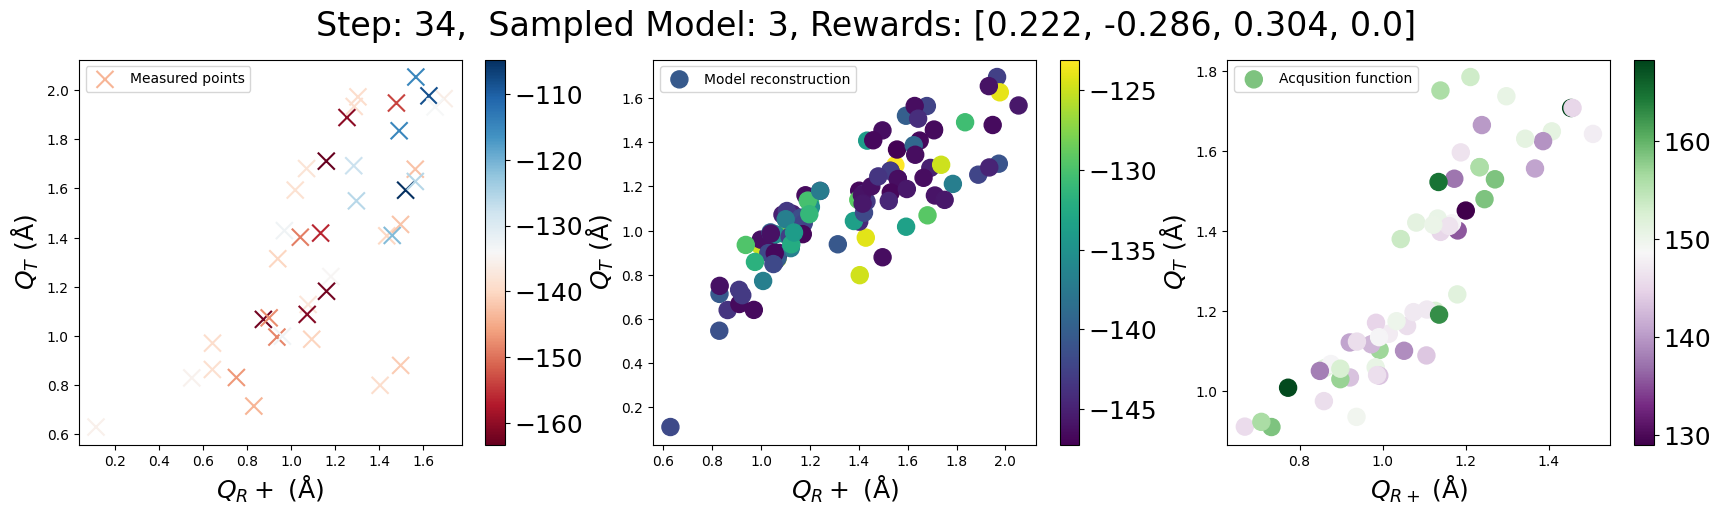

sample: 100%|██████████| 2000/2000 [00:16<00:00, 123.64it/s, 7 steps of size 5.31e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.12      0.43      1.04      0.46      1.68   1274.06      1.00
         a1    -53.81      1.01    -53.80    -55.45    -52.25   1552.25      1.00
         a2    -53.73      0.94    -53.72    -55.48    -52.31   1623.89      1.00
         a3      0.99      0.48      1.00      0.15      1.75   1351.77      1.00
      alpha    -14.70      0.94    -14.73    -16.07    -13.05   2252.06      1.00
k_length[0]      0.81      0.23      0.77      0.46      1.18   1323.35      1.00
k_length[1]      0.99      0.25      0.96      0.61      1.38   1338.66      1.00
  k_length1      0.81      0.23      0.77      0.46      1.18   1323.35      1.00
  k_length2      0.99      0.25      0.96      0.61      1.38   1338.66      1.00
    k_scale   6371.86   2448.68   5850.74   2757.20   9835.31   1140.75      1.00
      noise    132.28     29.45    129.47     89.24    178.99   1796.19      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:17<00:00, 115.76it/s, 7 steps of size 4.89e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.12      1.63      2.77      0.94      5.27    855.57      1.00
         a1    -53.79      1.03    -53.78    -55.61    -52.14   2376.99      1.00
         a2    -53.64      0.96    -53.67    -55.08    -51.98   1625.90      1.00
         a3      0.08      0.48      0.10     -0.64      0.95   1174.43      1.00
k_length[0]      0.78      0.22      0.74      0.41      1.11    952.22      1.00
k_length[1]      0.93      0.24      0.89      0.57      1.31    876.73      1.00
  k_length1      0.78      0.22      0.74      0.41      1.11    952.22      1.00
  k_length2      0.93      0.24      0.89      0.57      1.31    876.73      1.00
    k_scale   4355.19   1627.97   4042.86   2161.69   6638.66    740.80      1.00
      noise    133.62     29.82    131.18     85.62    175.69   1309.37      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 9  reward (avg) 0.222
model 2:  counts 7  reward (

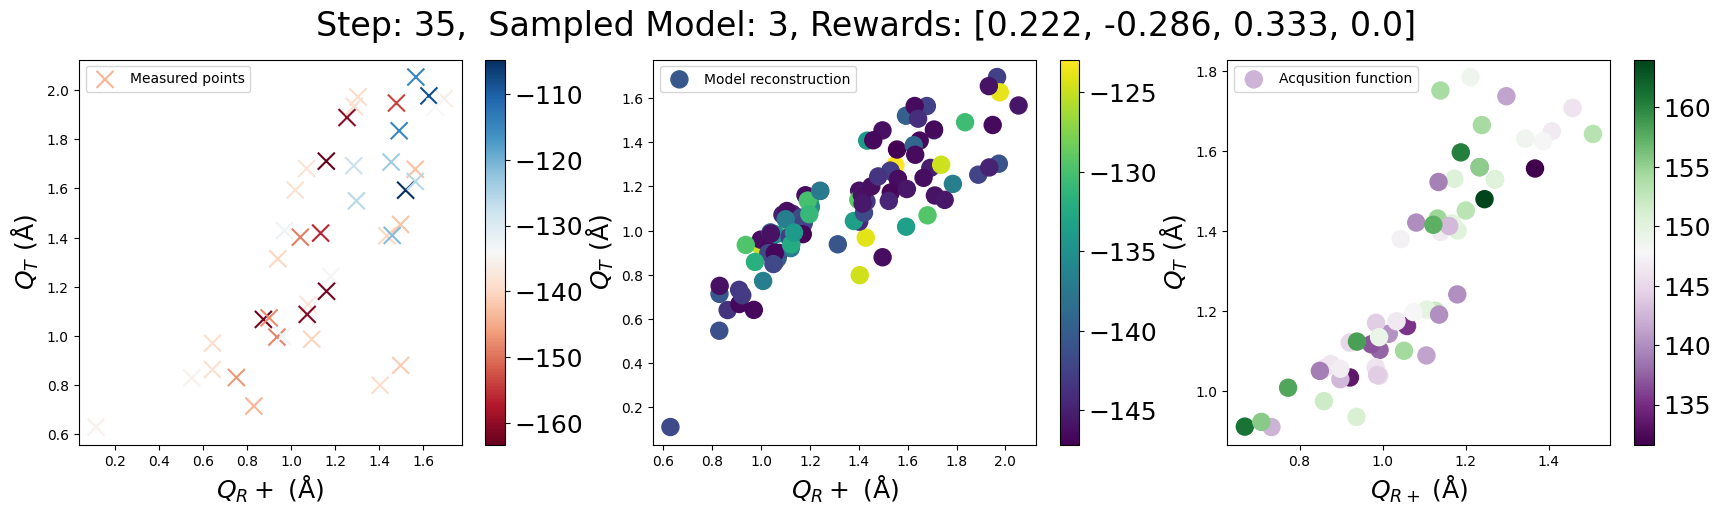

sample: 100%|██████████| 2000/2000 [00:17<00:00, 112.50it/s, 7 steps of size 5.39e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.11      0.42      1.04      0.46      1.66   1121.43      1.00
         a1    -53.83      1.02    -53.80    -55.44    -52.16   1438.47      1.00
         a2    -53.72      0.95    -53.71    -55.33    -52.18   1789.03      1.00
         a3      1.00      0.49      1.01      0.22      1.82   1568.85      1.00
      alpha    -14.70      0.94    -14.71    -16.25    -13.18   2317.62      1.00
k_length[0]      0.81      0.22      0.77      0.46      1.17   1405.03      1.00
k_length[1]      0.99      0.25      0.95      0.61      1.37   1255.55      1.00
  k_length1      0.81      0.22      0.77      0.46      1.17   1405.03      1.00
  k_length2      0.99      0.25      0.95      0.61      1.37   1255.55      1.00
    k_scale   6310.84   2405.69   5819.28   2713.82   9639.39   1105.28      1.00
      noise    130.03     29.02    126.59     86.08    174.12   1691.64      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:15<00:00, 129.15it/s, 7 steps of size 5.93e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.22      1.68      2.82      0.92      5.49    870.69      1.00
         a1    -53.76      1.04    -53.76    -55.57    -52.13   1759.93      1.00
         a2    -53.63      0.95    -53.62    -55.36    -52.20   1123.18      1.00
         a3      0.09      0.47      0.10     -0.66      0.85   1658.18      1.00
k_length[0]      0.78      0.21      0.75      0.47      1.12   1056.30      1.00
k_length[1]      0.94      0.24      0.91      0.58      1.35   1022.67      1.00
  k_length1      0.78      0.21      0.75      0.47      1.12   1056.30      1.00
  k_length2      0.94      0.24      0.91      0.58      1.35   1022.67      1.00
    k_scale   4334.02   1620.21   4058.88   2148.60   6470.13    726.91      1.00
      noise    130.58     29.08    126.76     83.44    175.02   1325.42      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 9  reward (avg) 0.222
model 2:  counts 7  reward (

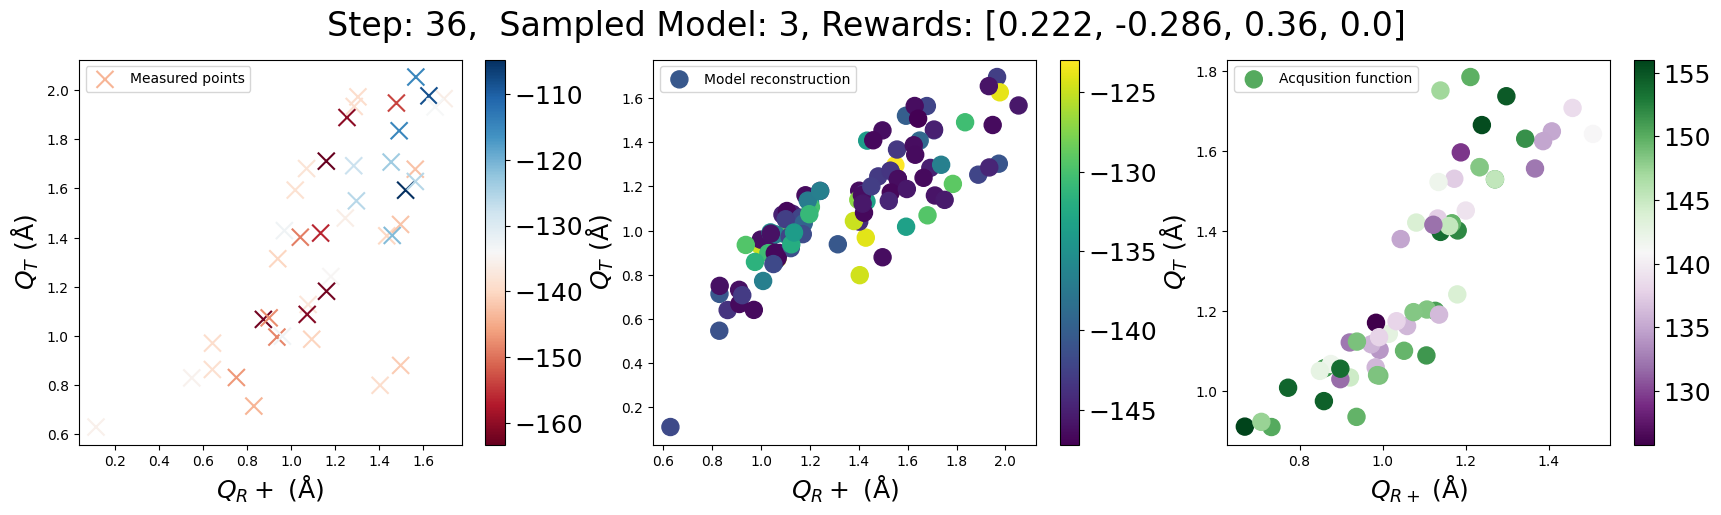

sample: 100%|██████████| 2000/2000 [00:18<00:00, 109.75it/s, 7 steps of size 5.57e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.12      0.42      1.05      0.46      1.67   1116.11      1.00
         a1    -53.82      1.02    -53.84    -55.36    -52.03   1736.56      1.00
         a2    -53.71      0.95    -53.71    -55.30    -52.18   1643.91      1.00
         a3      0.99      0.48      1.00      0.17      1.72   1489.26      1.00
      alpha    -14.70      0.96    -14.74    -16.29    -13.11   2211.20      1.00
k_length[0]      0.82      0.22      0.79      0.44      1.13   1316.16      1.00
k_length[1]      1.00      0.25      0.96      0.57      1.37   1373.63      1.00
  k_length1      0.82      0.22      0.79      0.44      1.13   1316.16      1.00
  k_length2      1.00      0.25      0.96      0.57      1.37   1373.63      1.00
    k_scale   6349.36   2383.19   5900.65   2800.95   9807.76   1021.91      1.00
      noise    128.16     29.05    125.15     85.13    172.19   1382.59      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:19<00:00, 102.75it/s, 7 steps of size 4.87e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.13      1.63      2.77      0.89      5.31    877.11      1.00
         a1    -53.79      1.03    -53.77    -55.51    -52.16   2021.43      1.00
         a2    -53.65      0.96    -53.65    -55.22    -52.09   1318.99      1.00
         a3      0.08      0.49      0.09     -0.66      0.97   1357.79      1.00
k_length[0]      0.79      0.22      0.75      0.44      1.13    850.24      1.00
k_length[1]      0.94      0.24      0.91      0.58      1.30    955.53      1.00
  k_length1      0.79      0.22      0.75      0.44      1.13    850.24      1.00
  k_length2      0.94      0.24      0.91      0.58      1.30    955.53      1.00
    k_scale   4438.58   1670.80   4108.86   2150.41   6772.62    709.50      1.00
      noise    128.22     28.13    125.48     85.62    170.79   1284.22      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 9  reward (avg) 0.222
model 2:  counts 7  reward (

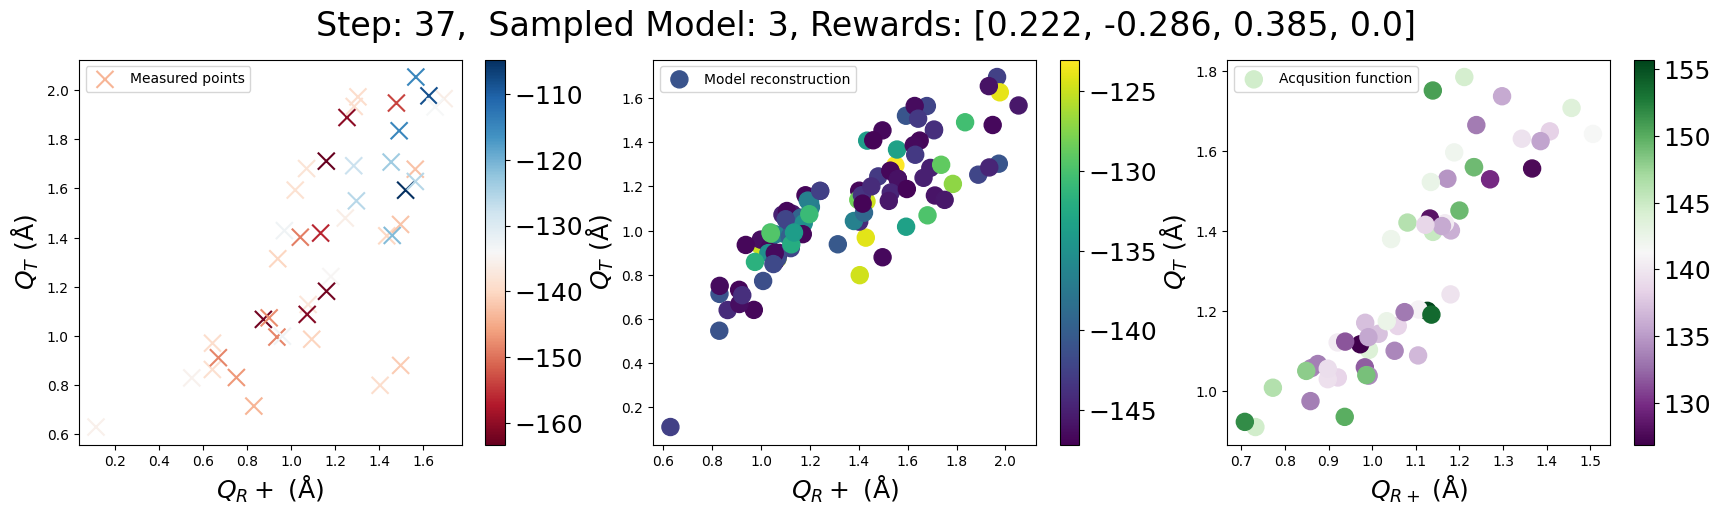

sample: 100%|██████████| 2000/2000 [00:23<00:00, 84.79it/s, 7 steps of size 5.74e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.12      0.42      1.05      0.51      1.73   1364.17      1.00
         a1    -53.83      0.99    -53.83    -55.41    -52.20   1480.51      1.00
         a2    -53.72      0.98    -53.73    -55.35    -52.18   1553.37      1.00
         a3      1.01      0.48      1.01      0.20      1.75   1497.40      1.00
      alpha    -14.73      0.93    -14.72    -16.43    -13.35   2252.68      1.00
k_length[0]      0.80      0.22      0.77      0.43      1.12   1569.77      1.00
k_length[1]      0.98      0.23      0.95      0.57      1.33   1091.68      1.00
  k_length1      0.80      0.22      0.77      0.43      1.12   1569.77      1.00
  k_length2      0.98      0.23      0.95      0.57      1.33   1091.68      1.00
    k_scale   6332.99   2449.87   5876.85   3101.88  10342.73    940.27      1.00
      noise    128.72     28.67    124.80     85.90    174.13   1165.90      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:17<00:00, 114.74it/s, 7 steps of size 6.88e-01. acc. prob=0.87]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.23      1.72      2.85      0.78      5.62   1039.27      1.00
         a1    -53.80      1.05    -53.79    -55.39    -52.04   1709.25      1.00
         a2    -53.64      1.05    -53.64    -55.31    -51.87   1591.13      1.00
         a3      0.10      0.48      0.12     -0.62      0.91   1316.56      1.00
k_length[0]      0.78      0.21      0.75      0.43      1.06   1040.24      1.00
k_length[1]      0.94      0.24      0.91      0.55      1.27   1087.66      1.00
  k_length1      0.78      0.21      0.75      0.43      1.06   1040.24      1.00
  k_length2      0.94      0.24      0.91      0.55      1.27   1087.66      1.00
    k_scale   4352.65   1646.82   4062.32   2123.68   6512.23    962.57      1.00
      noise    129.90     29.77    125.55     81.34    173.82   1164.80      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 9  reward (avg) 0.222
model 2:  counts 7  reward (

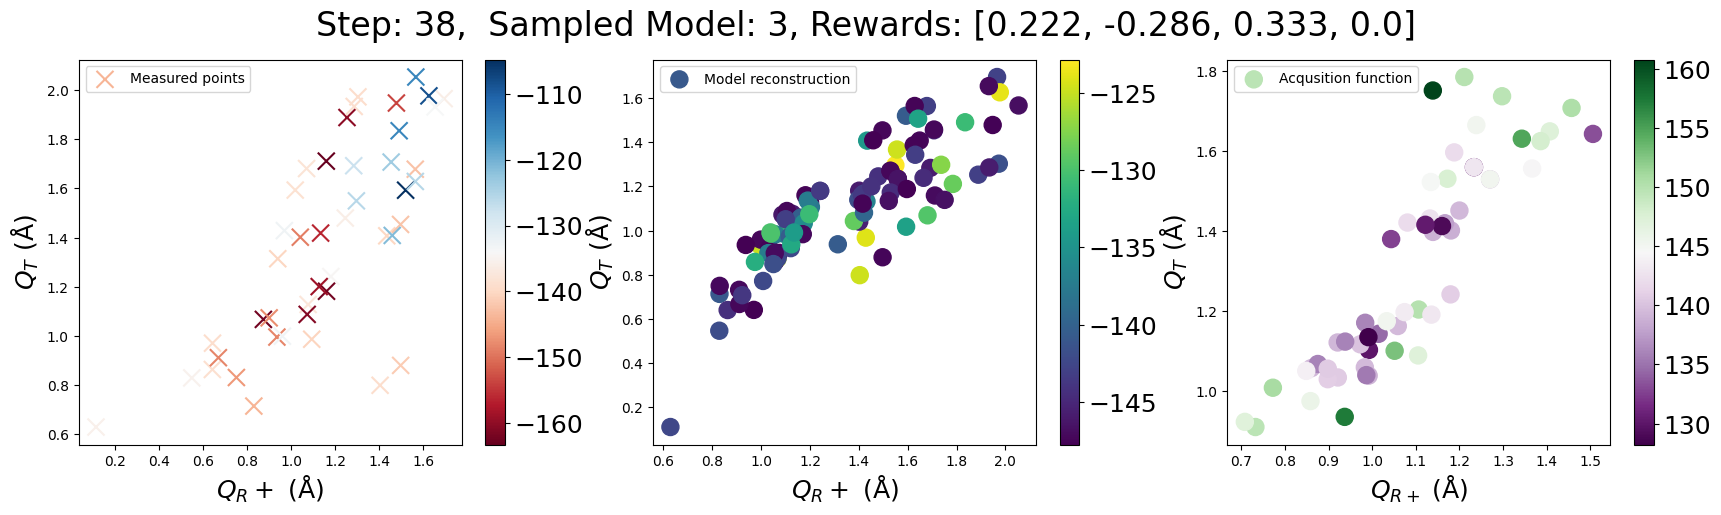

sample: 100%|██████████| 2000/2000 [00:18<00:00, 107.90it/s, 7 steps of size 5.14e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.12      0.43      1.05      0.48      1.72   1330.60      1.00
         a1    -53.81      1.02    -53.81    -55.47    -52.25   1614.18      1.00
         a2    -53.72      0.93    -53.72    -55.09    -51.91   1726.96      1.00
         a3      0.99      0.48      1.01      0.14      1.74   1387.65      1.00
      alpha    -14.69      0.96    -14.72    -16.17    -12.99   1795.65      1.00
k_length[0]      0.81      0.23      0.78      0.45      1.17   1394.96      1.00
k_length[1]      0.98      0.24      0.95      0.61      1.35   1325.79      1.00
  k_length1      0.81      0.23      0.78      0.45      1.17   1394.96      1.00
  k_length2      0.98      0.24      0.95      0.61      1.35   1325.79      1.00
    k_scale   6358.00   2441.46   5865.85   2700.16   9690.86   1133.58      1.00
      noise    126.53     27.05    123.86     86.88    169.94   1873.90      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:18<00:00, 106.97it/s, 7 steps of size 6.40e-01. acc. prob=0.88]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.18      1.80      2.71      0.83      5.55   1013.06      1.00
         a1    -53.77      1.03    -53.74    -55.41    -52.12   2062.25      1.00
         a2    -53.64      0.99    -53.65    -55.22    -51.90   1809.78      1.00
         a3      0.11      0.48      0.12     -0.69      0.85   1504.29      1.00
k_length[0]      0.79      0.21      0.77      0.44      1.07   1073.75      1.00
k_length[1]      0.93      0.23      0.91      0.58      1.28   1206.52      1.00
  k_length1      0.79      0.21      0.77      0.44      1.07   1073.75      1.00
  k_length2      0.93      0.23      0.91      0.58      1.28   1206.52      1.00
    k_scale   4329.76   1600.47   4033.22   2214.06   6586.93    890.01      1.00
      noise    128.10     28.49    124.09     79.86    169.09   1436.77      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 9  reward (avg) 0.222
model 2:  counts 7  reward (

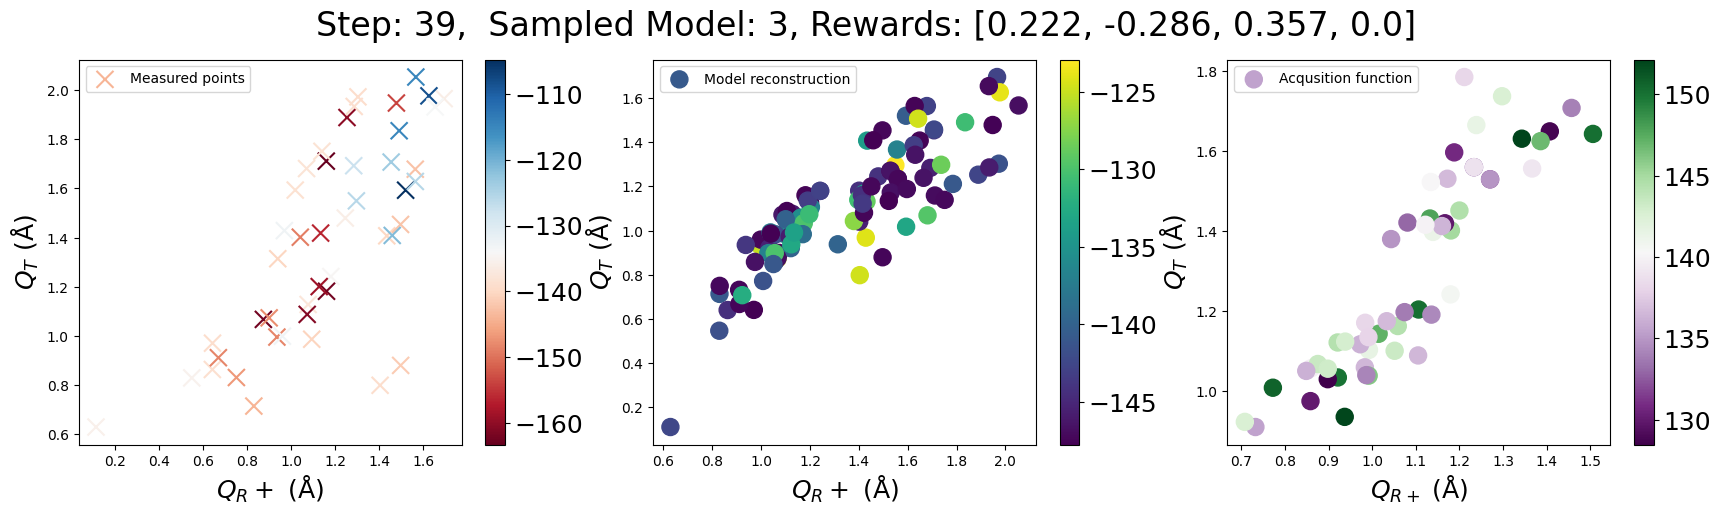

sample: 100%|██████████| 2000/2000 [00:19<00:00, 100.25it/s, 7 steps of size 5.58e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.12      0.43      1.05      0.43      1.70   1025.79      1.00
         a1    -53.83      1.01    -53.83    -55.41    -52.23   1569.42      1.00
         a2    -53.68      0.95    -53.67    -55.21    -52.14   1477.27      1.00
         a3      1.00      0.48      1.01      0.22      1.75   1599.94      1.00
      alpha    -14.70      0.98    -14.74    -16.28    -13.05   2367.82      1.00
k_length[0]      0.81      0.23      0.78      0.46      1.20   1460.68      1.00
k_length[1]      0.99      0.25      0.96      0.59      1.37   1547.85      1.00
  k_length1      0.81      0.23      0.78      0.46      1.20   1460.68      1.00
  k_length2      0.99      0.25      0.96      0.59      1.37   1547.85      1.00
    k_scale   6505.00   2551.24   5951.61   2456.19   9823.32   1103.33      1.00
      noise    140.99     30.51    138.92     92.74    186.01   1487.85      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:18<00:00, 107.72it/s, 7 steps of size 5.52e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.20      1.64      2.81      1.04      5.53    815.07      1.00
         a1    -53.76      1.06    -53.74    -55.64    -52.15   1898.66      1.00
         a2    -53.61      0.96    -53.62    -55.26    -52.14   2164.93      1.00
         a3      0.10      0.47      0.12     -0.60      0.93   1383.69      1.00
k_length[0]      0.78      0.21      0.75      0.45      1.10    985.17      1.00
k_length[1]      0.92      0.24      0.90      0.55      1.28   1263.06      1.00
  k_length1      0.78      0.21      0.75      0.45      1.10    985.17      1.00
  k_length2      0.92      0.24      0.90      0.55      1.28   1263.06      1.00
    k_scale   4425.14   1613.80   4085.56   2183.74   6623.53    876.55      1.00
      noise    142.04     30.58    138.44     92.80    189.54   1334.64      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 9  reward (avg) 0.222
model 2:  counts 7  reward (

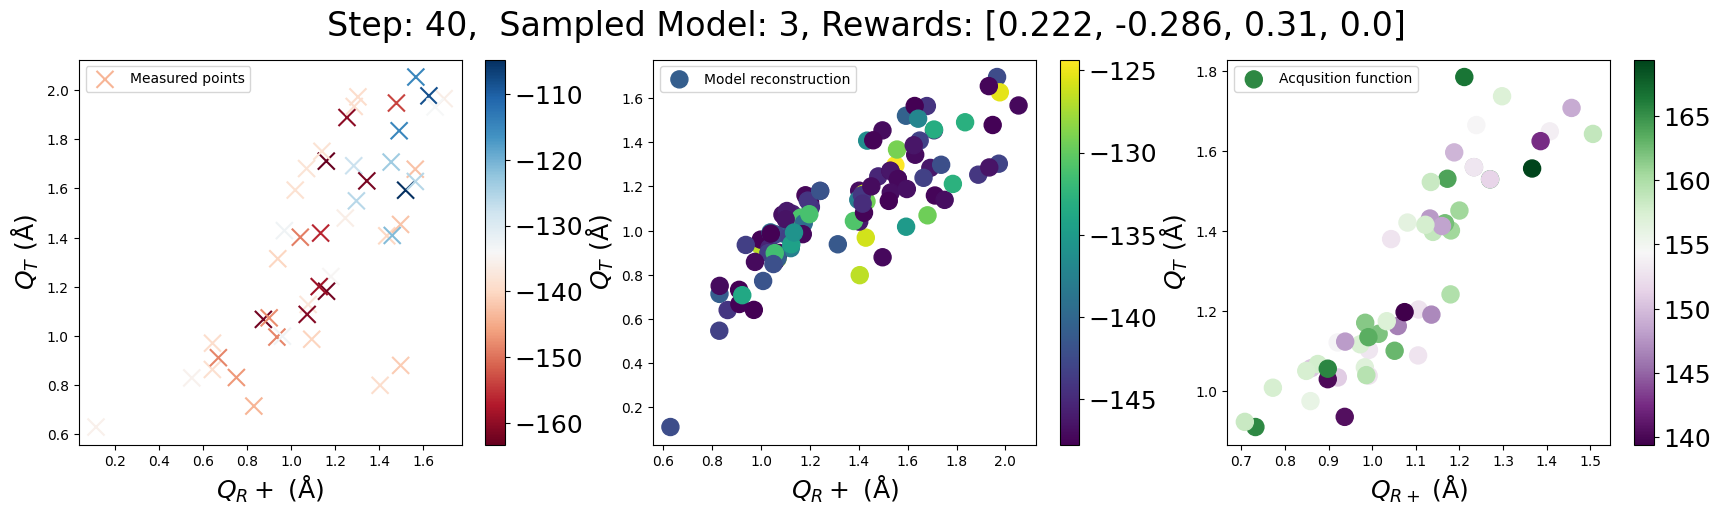

sample: 100%|██████████| 2000/2000 [00:19<00:00, 101.50it/s, 7 steps of size 5.04e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.12      0.43      1.05      0.46      1.69   1359.81      1.00
         a1    -53.79      1.04    -53.78    -55.57    -52.24   1671.22      1.00
         a2    -53.72      0.93    -53.72    -55.00    -51.86   1495.17      1.00
         a3      0.99      0.49      1.01      0.18      1.75   1205.75      1.00
      alpha    -14.68      0.97    -14.71    -16.25    -13.07   2053.09      1.00
k_length[0]      0.82      0.23      0.79      0.44      1.18   1358.67      1.00
k_length[1]      1.00      0.24      0.97      0.61      1.37   1275.39      1.00
  k_length1      0.82      0.23      0.79      0.44      1.18   1358.67      1.00
  k_length2      1.00      0.24      0.97      0.61      1.37   1275.39      1.00
    k_scale   6457.66   2537.14   5905.57   2649.66  10090.89   1150.52      1.00
      noise    145.81     30.67    142.68    101.93    193.78   1332.51      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:17<00:00, 113.28it/s, 7 steps of size 6.71e-01. acc. prob=0.87]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.21      1.68      2.78      0.84      5.47   1059.37      1.00
         a1    -53.81      1.03    -53.79    -55.45    -52.04   1371.39      1.00
         a2    -53.60      0.98    -53.65    -55.20    -51.98   1461.57      1.00
         a3      0.09      0.49      0.11     -0.70      0.86   1345.70      1.00
k_length[0]      0.81      0.22      0.77      0.48      1.15   1014.84      1.00
k_length[1]      0.95      0.23      0.93      0.58      1.31   1110.54      1.00
  k_length1      0.81      0.22      0.77      0.48      1.15   1014.84      1.00
  k_length2      0.95      0.23      0.93      0.58      1.31   1110.54      1.00
    k_scale   4476.07   1671.01   4131.60   1986.49   6717.73    895.18      1.00
      noise    146.14     30.74    142.74    100.04    194.40   1015.96      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 9  reward (avg) 0.222
model 2:  counts 7  reward (

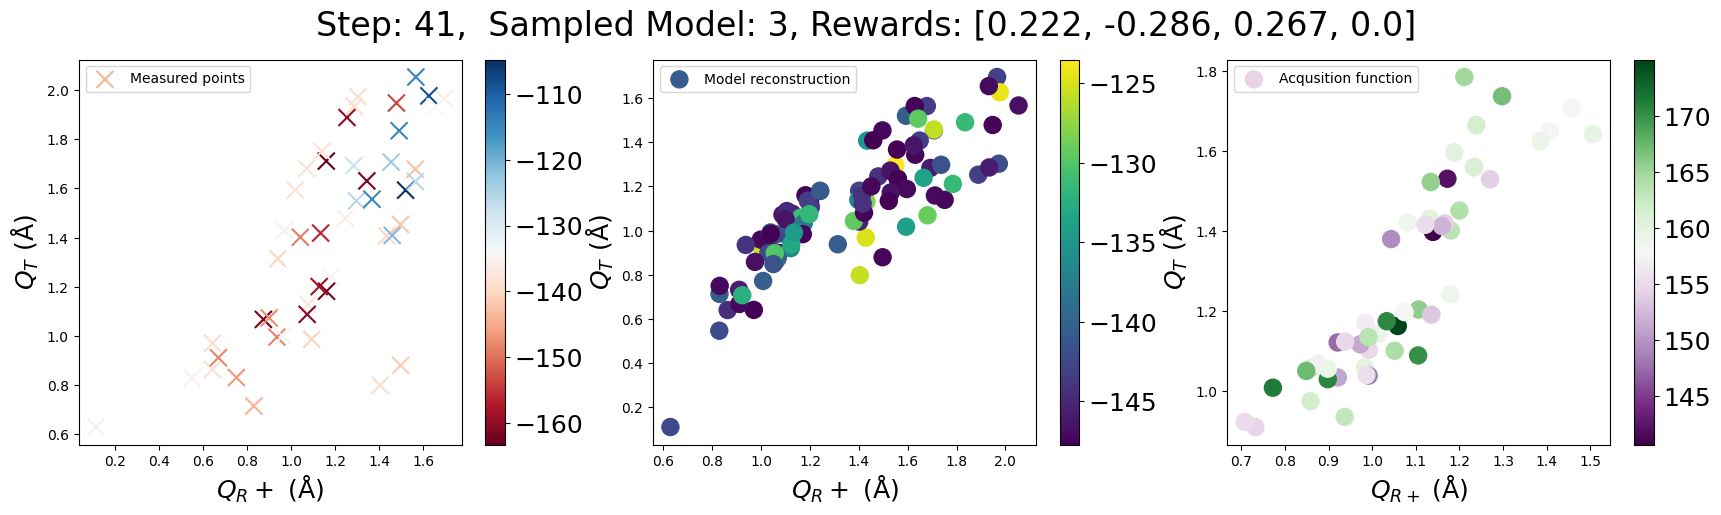

sample: 100%|██████████| 2000/2000 [00:18<00:00, 109.69it/s, 7 steps of size 5.02e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.12      0.43      1.05      0.46      1.68   1371.22      1.00
         a1    -53.79      1.04    -53.80    -55.35    -52.04   1575.67      1.00
         a2    -53.72      0.93    -53.72    -54.99    -51.87   1526.48      1.00
         a3      0.99      0.48      1.00      0.12      1.72   1362.67      1.00
      alpha    -14.71      0.95    -14.74    -16.29    -13.16   1841.66      1.00
k_length[0]      0.83      0.23      0.79      0.44      1.17   1337.21      1.00
k_length[1]      1.00      0.25      0.97      0.62      1.38   1351.68      1.00
  k_length1      0.83      0.23      0.79      0.44      1.17   1337.21      1.00
  k_length2      1.00      0.25      0.97      0.62      1.38   1351.68      1.00
    k_scale   6450.23   2515.36   5867.10   2789.36   9996.16   1194.55      1.00
      noise    142.55     29.54    138.84     95.11    187.13   1238.28      1.00

False
Explorat

sample: 100%|██████████| 2000/2000 [00:17<00:00, 113.84it/s, 7 steps of size 6.21e-01. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      3.18      1.71      2.73      0.84      5.45   1070.85      1.00
         a1    -53.76      1.03    -53.74    -55.34    -52.08   1906.17      1.00
         a2    -53.64      0.96    -53.63    -55.23    -52.01   1673.07      1.00
         a3      0.11      0.49      0.12     -0.71      0.90   1304.40      1.00
k_length[0]      0.79      0.22      0.77      0.50      1.17   1014.35      1.00
k_length[1]      0.95      0.25      0.92      0.59      1.35   1296.17      1.00
  k_length1      0.79      0.22      0.77      0.50      1.17   1014.35      1.00
  k_length2      0.95      0.25      0.92      0.59      1.35   1296.17      1.00
    k_scale   4372.85   1613.56   4078.71   2143.27   6490.40    895.64      1.00
      noise    143.82     30.33    139.97     98.04    193.78   1454.88      1.00

False

CURRENT MODEL REWARDS
model 1:  counts 9  reward (avg) 0.222
model 2:  counts 7  reward (

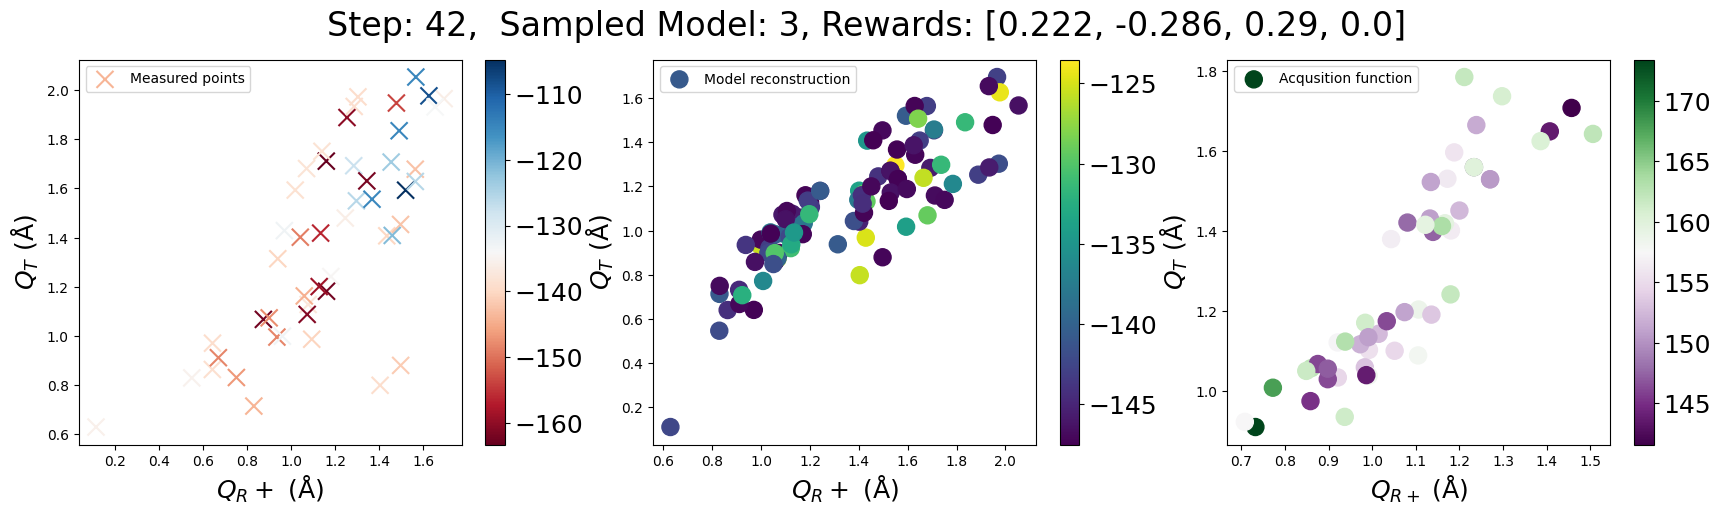

sample: 100%|██████████| 2000/2000 [00:17<00:00, 111.52it/s, 7 steps of size 5.64e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.12      0.42      1.05      0.43      1.66   1153.92      1.00
         a1    -53.82      1.04    -53.82    -55.48    -52.09   1494.03      1.00
         a2    -53.69      0.96    -53.70    -55.37    -52.24   1475.23      1.00
         a3      1.00      0.47      1.00      0.21      1.74   1392.94      1.00
      alpha    -14.72      0.94    -14.71    -16.18    -13.10   2449.64      1.00
k_length[0]      0.82      0.23      0.78      0.50      1.21   1316.99      1.00
k_length[1]      1.00      0.24      0.97      0.62      1.38   1291.82      1.00
  k_length1      0.82      0.23      0.78      0.50      1.21   1316.99      1.00
  k_length2      1.00      0.24      0.97      0.62      1.38   1291.82      1.00
    k_scale   6486.82   2557.88   6000.59   2922.88  10317.02   1007.28      1.00
      noise    141.58     29.78    137.58     95.29    187.85   1573.96      1.00

False


In [14]:
exploration_steps = 45
eps = 0.4
warmup_steps = 3
models = [comb1, comb2, comb3, comb4]
model_priors = [comb1_priors, comb2_priors, comb3_priors, comb4_priors]
save_reconstruction = True  # available only for exploration phase

onp.random.seed(55)  # rng seed for epsilon-greedy sampling
record = onp.zeros((len(models), 2))
model_choices = []
obj_history = []
rewards_save = []

# Warm-up phase
for w in range(warmup_steps):
    print("Warmup step {}/{}".format(w+1, warmup_steps))
    obj_median_all, obj_all = [], []
    # Iterate over probabilistic models in the list
    for i, model in enumerate(models):
        # for each model, run BI and store uncertainty values

        k_prior = kernel_prior1
        #print(models[i])

        obj, _ = step(models[i], model_priors[i], k_prior, X_train, y_train, X_test, num_restarts=2)
        record[i, 0] += 1
        obj_all.append(obj)
        obj_median_all.append(jnp.nanmedian(obj).item())  # (one can use integral uncertainty instead of median)
    # 'Reward' a model that has the smallest integral/median uncertainty
    idx = onp.argmin(obj_median_all)
    obj = obj_all[idx]

    model_choices.append(idx)
    record[idx, 1] += 1
    # Store the integral/median uncertainty
    obj_history.append(obj_median_all[idx])
    # Compute the next measurement point using the predictive uncertainty of rewarded model
    obj = obj_all[idx]
    next_point_idx = obj.argmax()
    next_point = indices_test[next_point_idx]
    # Evaluate the function in the suggested point
    measured_point = y_test[next_point_idx]
    # Update training/test data
    ((X_train, y_train, indices_train),
    (X_test, y_test, indices_test)) = update_datapoints(
        next_point_idx, (X_train, y_train, indices_train), (X_test, y_test, indices_test))
# Average over the number of warmup steps
record[:, 1] = record[:, 1] / warmup_steps

# Run exploration
for e in range(exploration_steps - warmup_steps):
    print("Exploration step {}/{}".format(e+warmup_steps+1, exploration_steps))
    # Choose model according to epsilon-greedy policy
    if onp.random.random() > eps:
        idx = get_best_model(record)
    else:
        idx = onp.random.randint(len(models))
    model_choices.append(idx)
    print("Using model {}".format(idx+1))
    # Derive acqusition function with the selected model

    k_prior = kernel_prior1

    obj, m_post = step(models[i], model_priors[i], k_prior,
                      X_train, y_train, X_test, num_restarts=2)
    # Get reward
    r = get_reward(obj_history, obj)
    # Update records
    record = update_record(record, idx, r)
    obj_history.append(jnp.nanmedian(obj).item())
    # Evaluate function in the suggested point
    next_point_idx = obj.argmax()
    next_point = indices_test[next_point_idx]
    measured_point = y_test[next_point_idx]

    # Display the current model rewards
    print("\nCURRENT MODEL REWARDS")
    for i, r in enumerate(record):
        print("model {}:  counts {}  reward (avg) {}".format(i+1, (int(r[0])), onp.round(r[1], 3)))
    # Display tjhe suggested point
    print("\nNEXT POINT ID: {}, NEXT POINT VALUE: {}".format(next_point_idx, X_test[next_point_idx]))

    rewards_save.append(record[:,1])

    if save_reconstruction:
        # plot current reconstruction and acqusition function
        y_pred, y_sampled = m_post.predict(gpax.utils.get_keys()[1], X_all)
        plot_results_new(X_train, y_train, X_test, y_pred, y_sampled.squeeze(), obj, idx+1, record[:, 1],  e=e)
    # Update training/test data
    ((X_train, y_train, indices_train),
    (X_test, y_test, indices_test)) = update_datapoints(
        next_point_idx, (X_train, y_train, indices_train), (X_test, y_test, indices_test))
    model_won = onp.argmax(record[:,1])

    _, gp_model = step(models[model_won], model_priors[model_won], k_prior,
                      X_train, y_train, X_test, num_restarts=2)
    y_pred_tr, y_sampled_tr = gp_model.predict(gpax.utils.get_keys()[1], X_train)
    y_pred_test, y_sampled_test = gp_model.predict(gpax.utils.get_keys()[1], X_test)

View average reward associated with each model:

(note that it counts the warmup steps where all the models were evaluated)

In [16]:
for i, r in enumerate(record):
    print("model {}:  counts {}  reward (avg) {}".format(i+1, (int(r[0])), onp.round(r[1], 3)))

model 1:  counts 9  reward (avg) 0.222
model 2:  counts 7  reward (avg) -0.286
model 3:  counts 31  reward (avg) 0.29
model 4:  counts 7  reward (avg) 0.0


Use the model with the highest average reward

In [17]:
_, gp_model = step(models[2], model_priors[2], k_prior, X_train, y_train, X_test, num_restarts=2)
y_pred_tr, y_sampled_tr = gp_model.predict(gpax.utils.get_keys()[1], X_train, n=50)
y_pred_test, y_sampled_test = gp_model.predict(gpax.utils.get_keys()[1], X_test, n=50)

sample: 100%|██████████| 2000/2000 [00:11<00:00, 177.29it/s, 7 steps of size 5.64e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.12      0.42      1.05      0.43      1.66   1153.92      1.00
         a1    -53.82      1.04    -53.82    -55.48    -52.09   1494.03      1.00
         a2    -53.69      0.96    -53.70    -55.37    -52.24   1475.23      1.00
         a3      1.00      0.47      1.00      0.21      1.74   1392.94      1.00
      alpha    -14.72      0.94    -14.71    -16.18    -13.10   2449.64      1.00
k_length[0]      0.82      0.23      0.78      0.50      1.21   1316.99      1.00
k_length[1]      1.00      0.24      0.97      0.62      1.38   1291.82      1.00
  k_length1      0.82      0.23      0.78      0.50      1.21   1316.99      1.00
  k_length2      1.00      0.24      0.97      0.62      1.38   1291.82      1.00
    k_scale   6486.82   2557.88   6000.59   2922.88  10317.02   1007.28      1.00
      noise    141.58     29.78    137.58     95.29    187.85   1573.96      1.00

False


In [18]:
#_, gp_model = step_new(models[1], model_priors[1], k_prior, X_train, y_train, X_test, num_restarts=2, print_summary=0)
_, gp_model = step(models[2], model_priors[2], k_prior, X_train, y_train, X_test, num_restarts=2)
y_pred_tr, y_sampled_tr = gp_model.predict(gpax.utils.get_keys()[1], X_train, n=50)
y_pred_test, y_sampled_test = gp_model.predict(gpax.utils.get_keys()[1], X_test, n=50)
y_pred_all, y_sampled_all = gp_model.predict(gpax.utils.get_keys()[1], X_all, n=50)

sample: 100%|██████████| 2000/2000 [00:12<00:00, 154.03it/s, 7 steps of size 5.64e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      QAFEA      1.12      0.42      1.05      0.43      1.66   1153.92      1.00
         a1    -53.82      1.04    -53.82    -55.48    -52.09   1494.03      1.00
         a2    -53.69      0.96    -53.70    -55.37    -52.24   1475.23      1.00
         a3      1.00      0.47      1.00      0.21      1.74   1392.94      1.00
      alpha    -14.72      0.94    -14.71    -16.18    -13.10   2449.64      1.00
k_length[0]      0.82      0.23      0.78      0.50      1.21   1316.99      1.00
k_length[1]      1.00      0.24      0.97      0.62      1.38   1291.82      1.00
  k_length1      0.82      0.23      0.78      0.50      1.21   1316.99      1.00
  k_length2      1.00      0.24      0.97      0.62      1.38   1291.82      1.00
    k_scale   6486.82   2557.88   6000.59   2922.88  10317.02   1007.28      1.00
      noise    141.58     29.78    137.58     95.29    187.85   1573.96      1.00

False


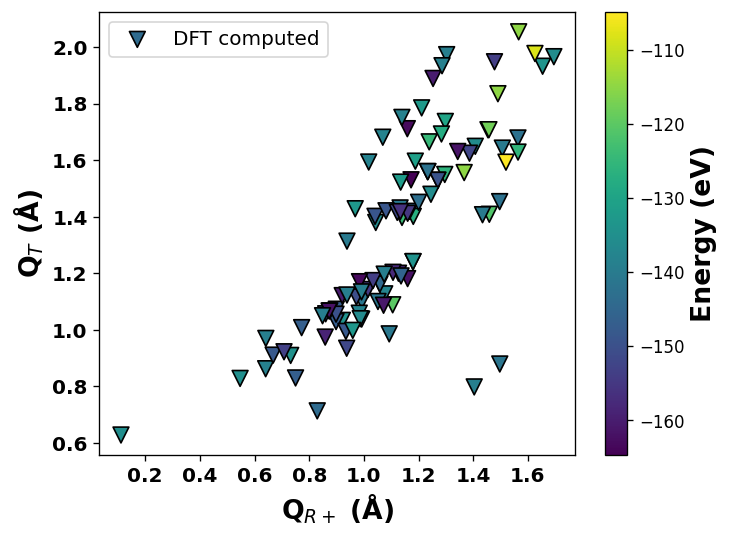

In [19]:
# Plot original & prediction
plt.figure(dpi=120)
s=90
plt.scatter(X_all[:,0], X_all[:,1], marker = 'v',edgecolor='black', c=y_all, s=s, label='DFT computed', zorder=2,cmap='viridis')

plt.xlabel("Q$_{R+}$ (Å)", fontdict={'fontsize' : 16}, fontweight = "bold")
plt.ylabel("Q$_{T}$ (Å)", fontdict={'fontsize' : 16}, fontweight = "bold")
cbar = plt.colorbar(label="Energy (eV)")
cbar.set_label(label="Energy (eV)", fontdict={'fontsize' : 16}, fontweight = "bold")
plt.legend(fontsize=12)
plt.xticks(fontsize = 12, weight = "bold")
plt.yticks(fontsize = 12, weight = "bold")
#plt.colorbar()
plt.show()

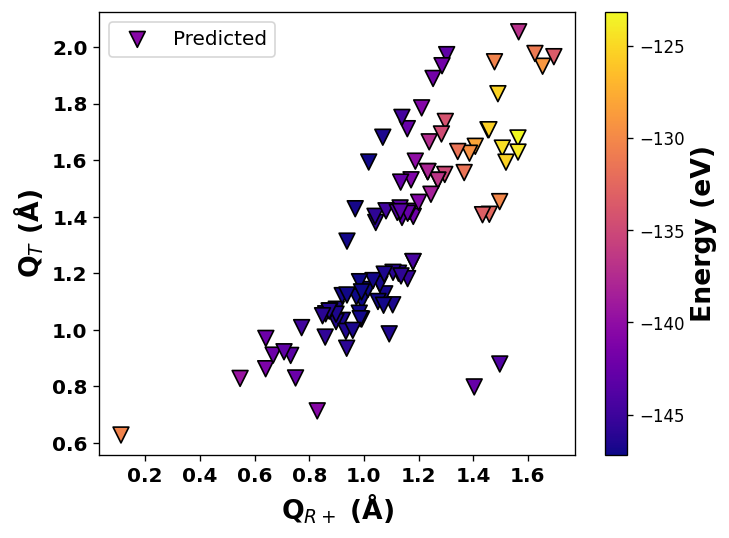

In [20]:
# Plot original & prediction
plt.figure(dpi=120)
s=90
plt.scatter(X_all[:,0], X_all[:,1], marker = 'v',edgecolor='black', c=y_pred_all, s=s, label='Predicted', zorder=1,cmap='plasma')

plt.xlabel("Q$_{R+}$ (Å)", fontdict={'fontsize' : 16}, fontweight = "bold")
plt.ylabel("Q$_{T}$ (Å)", fontdict={'fontsize' : 16}, fontweight = "bold")
cbar = plt.colorbar(label="Energy (eV)")
cbar.set_label(label="Energy (eV)", fontdict={'fontsize' : 16}, fontweight = "bold")
plt.legend(fontsize=12)
plt.xticks(fontsize = 12, weight = "bold")
plt.yticks(fontsize = 12, weight = "bold")
#plt.colorbar()
plt.show()